In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import lightgbm as lgb
import xgboost
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv("../data/processed/data.csv", parse_dates=["date_forecast", "date_calc"])

## Find Estimated Mistake

In [3]:
drop_cols = [
    "hour_sin",
    "month_sin",
    "hour_cos",
    "month_cos",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    "date_forecast"
]

reduced_data = data.drop(drop_cols, axis=1).copy()

observed = reduced_data[reduced_data["data_type"] == "observed"].drop(
    columns=["data_type"]
)
estimated = reduced_data[reduced_data["data_type"] == "estimated"].drop(
    columns=["data_type"]
)

pool_observed = catboost.Pool(
    data=observed[
        [column for column in observed.columns if not column in ["pv_measurement"]]
    ],
    cat_features=["location"],
    label=observed[["pv_measurement"]],
)
pool_estimated = catboost.Pool(
    data=estimated[
        [column for column in estimated.columns if not column in ["pv_measurement"]]
    ],
    cat_features=["location"],
)

model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="MAE")

model.fit(
    pool_observed,
    verbose=False,
)

predictions = model.predict(pool_estimated)

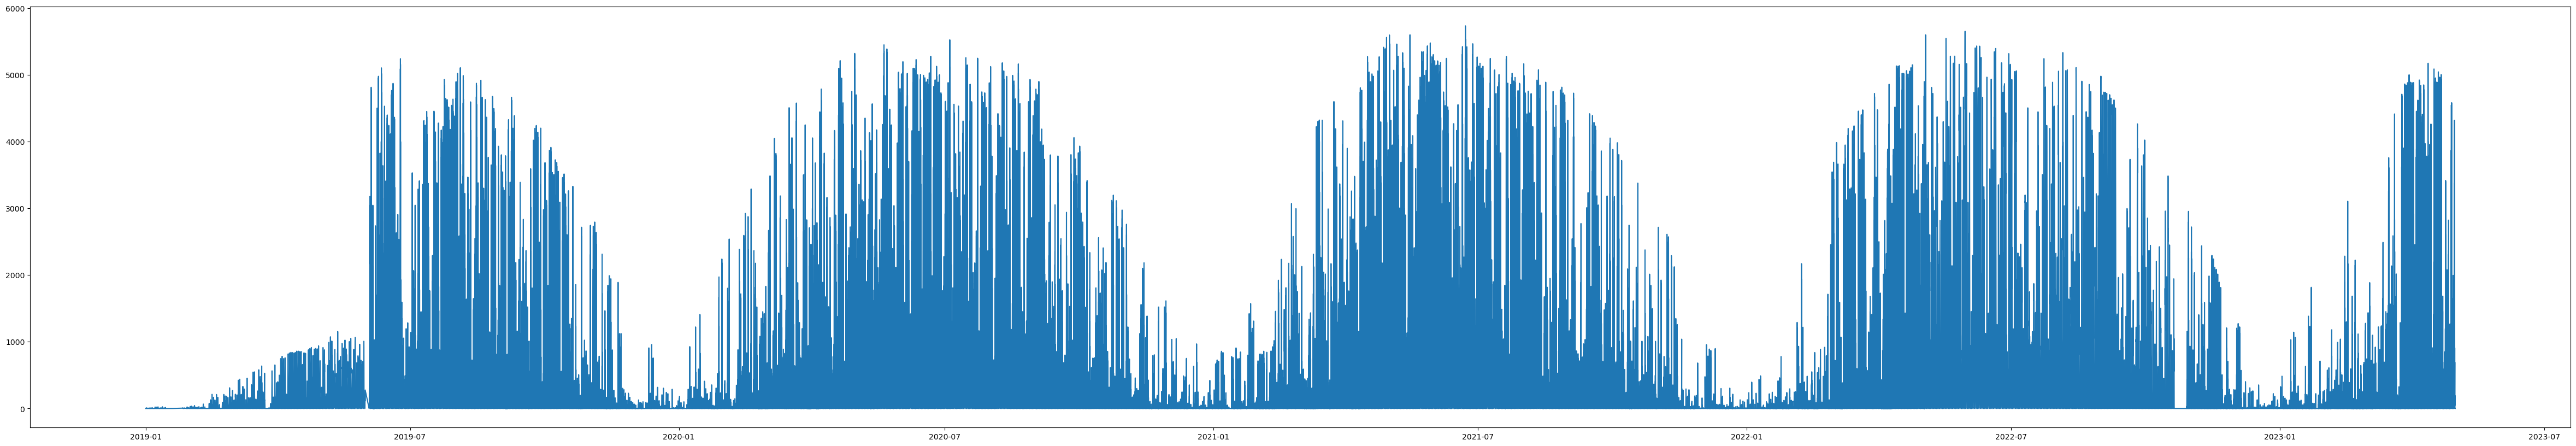

In [10]:
plot_data = data[data["data_type"].isin(["observed", "estimated"])].copy()

plt.figure(figsize=(60, 10))
plt.plot(plot_data["date_forecast"], plot_data["pv_measurement"])

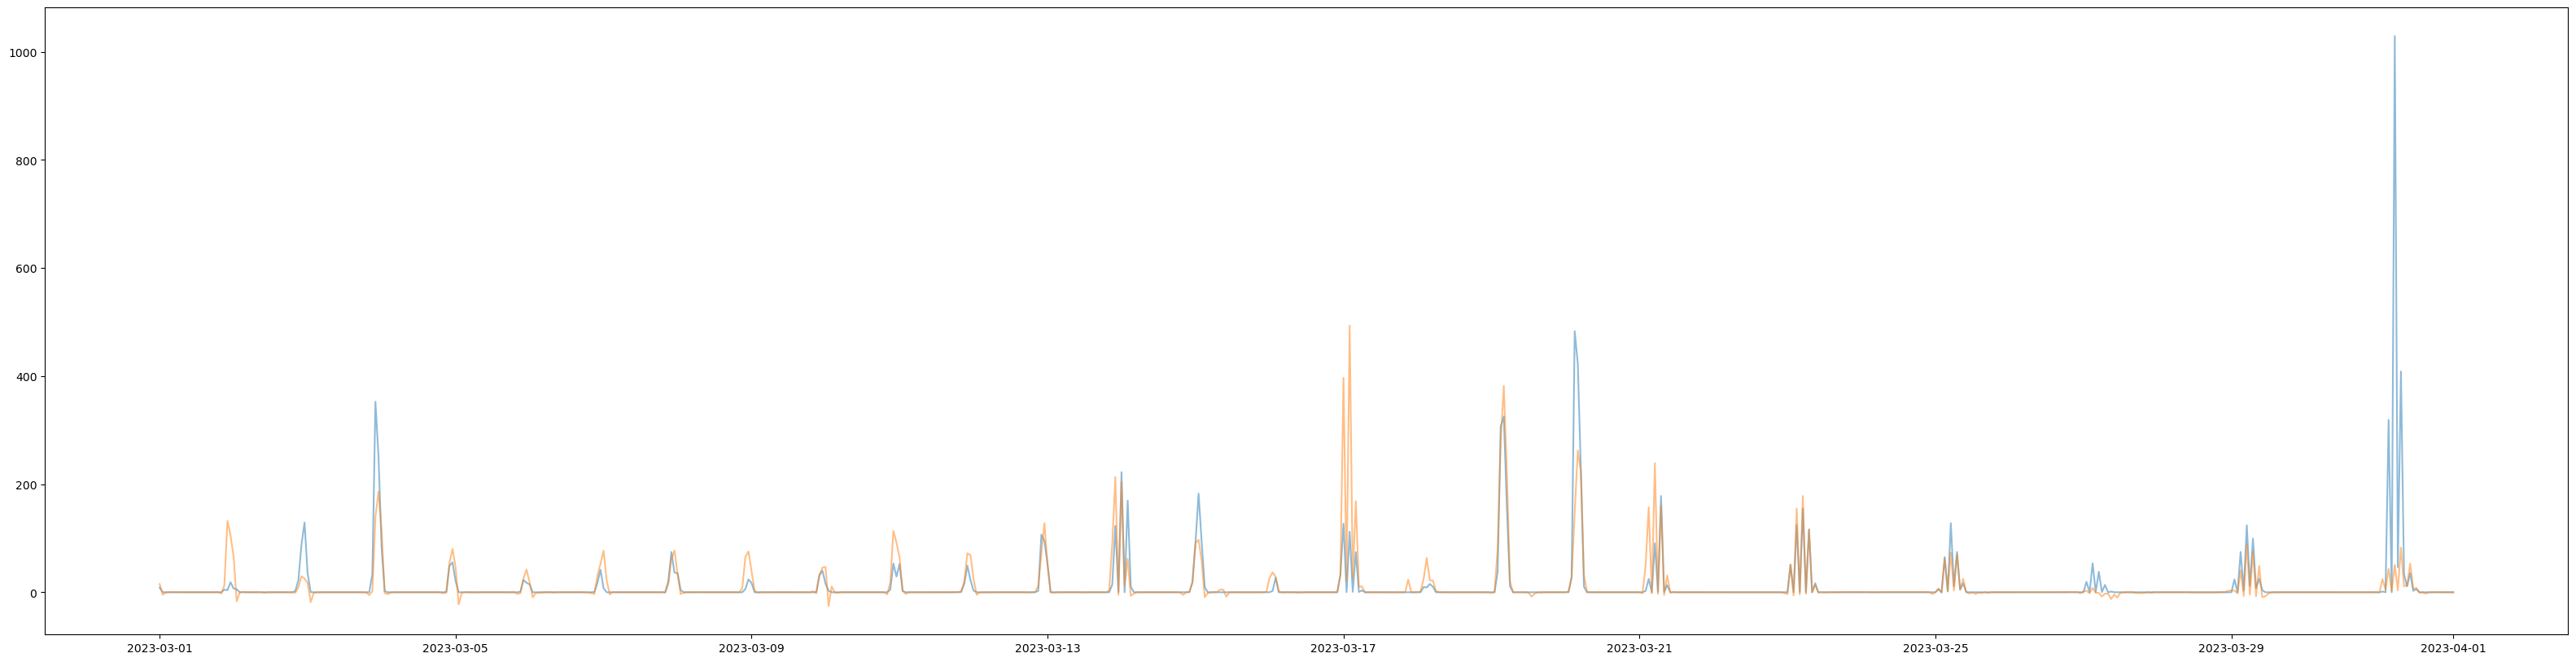

In [8]:
location = "A"
plot_data = data[(data["data_type"] == "estimated") & (data["location"] == location)].copy().reset_index(drop=True)
indices = plot_data[
    (plot_data["date_forecast"] >= "2023-03-01")
    & (plot_data["date_forecast"] <= "2023-04-01")
].index

plt.figure(figsize=(40, 10))
plt.plot(plot_data.iloc[indices]["date_forecast"], estimated.iloc[indices]["pv_measurement"], alpha=0.5)
plt.plot(plot_data.iloc[indices]["date_forecast"], predictions[indices], alpha=0.5)

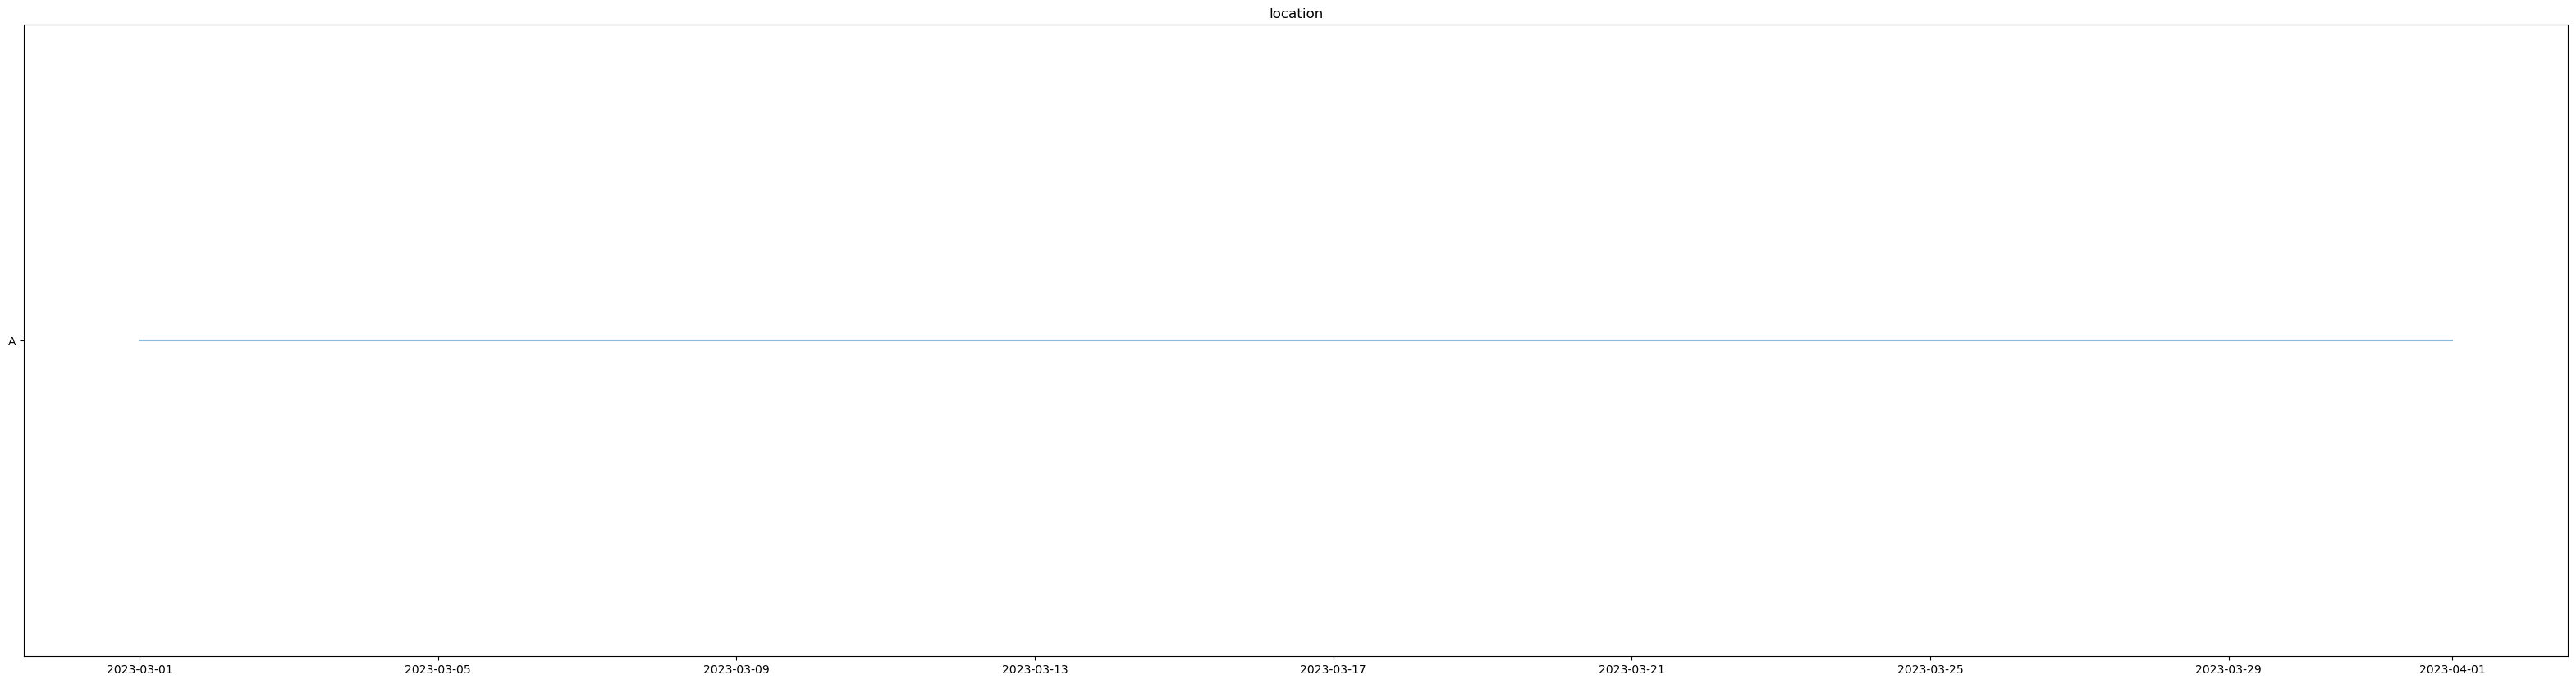

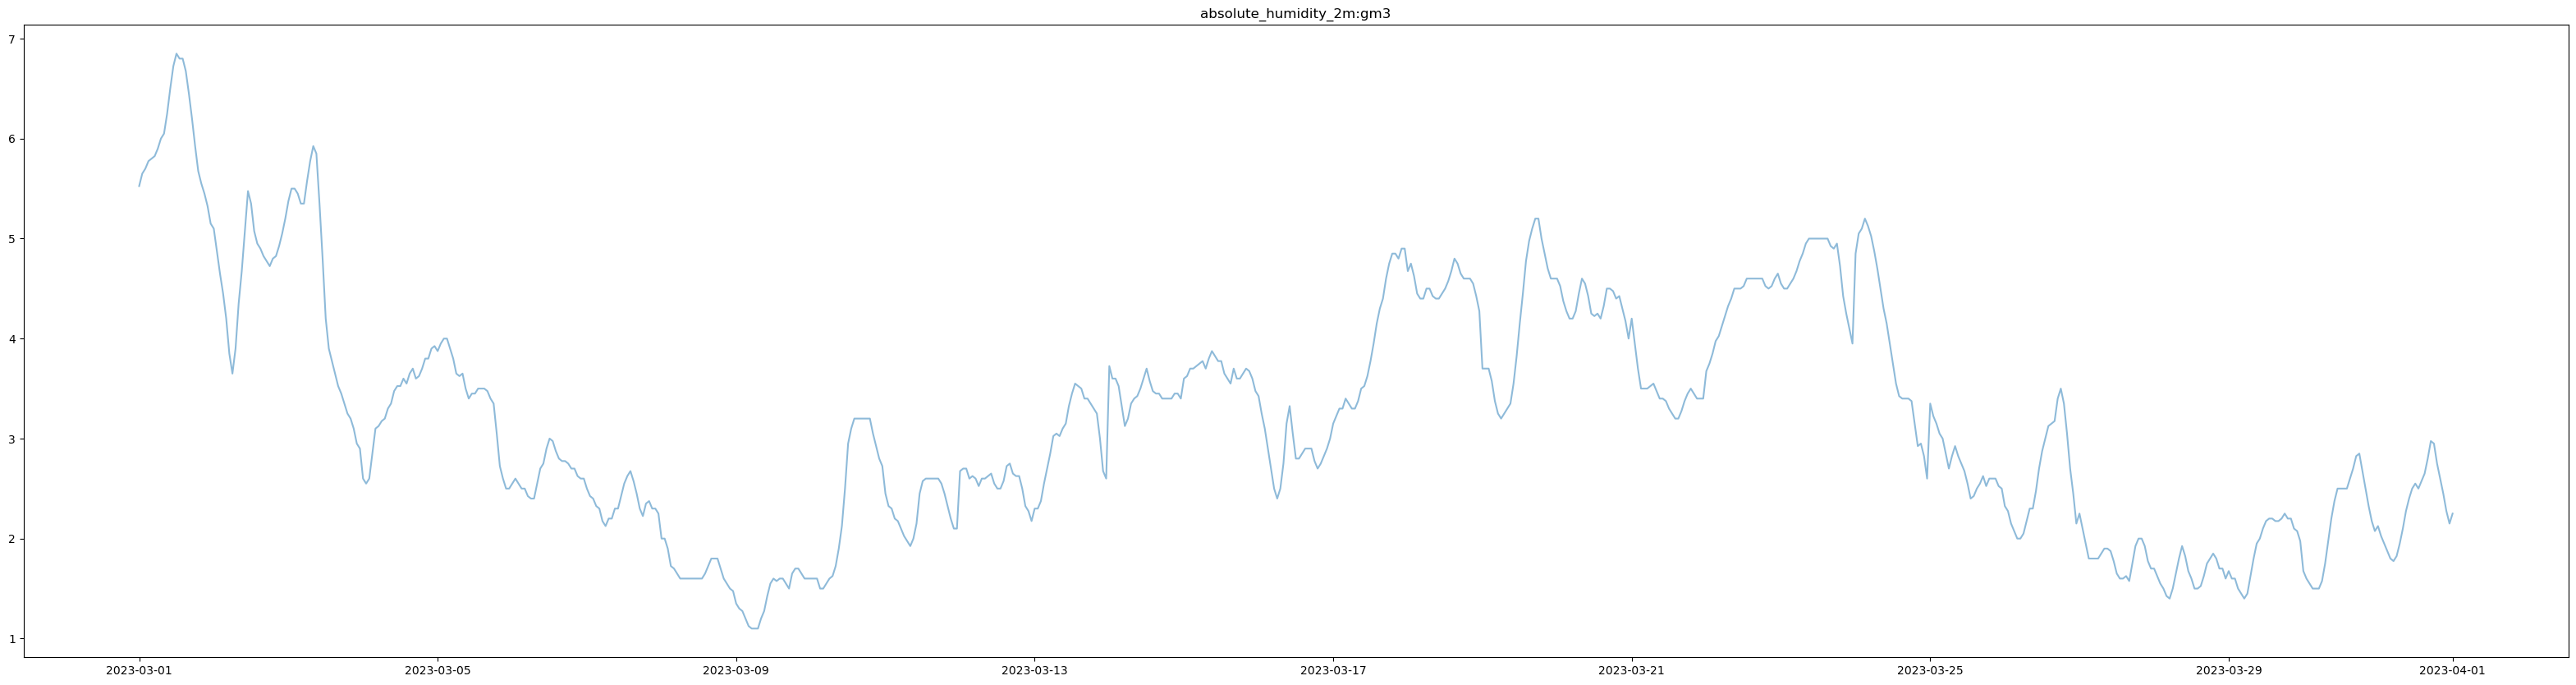

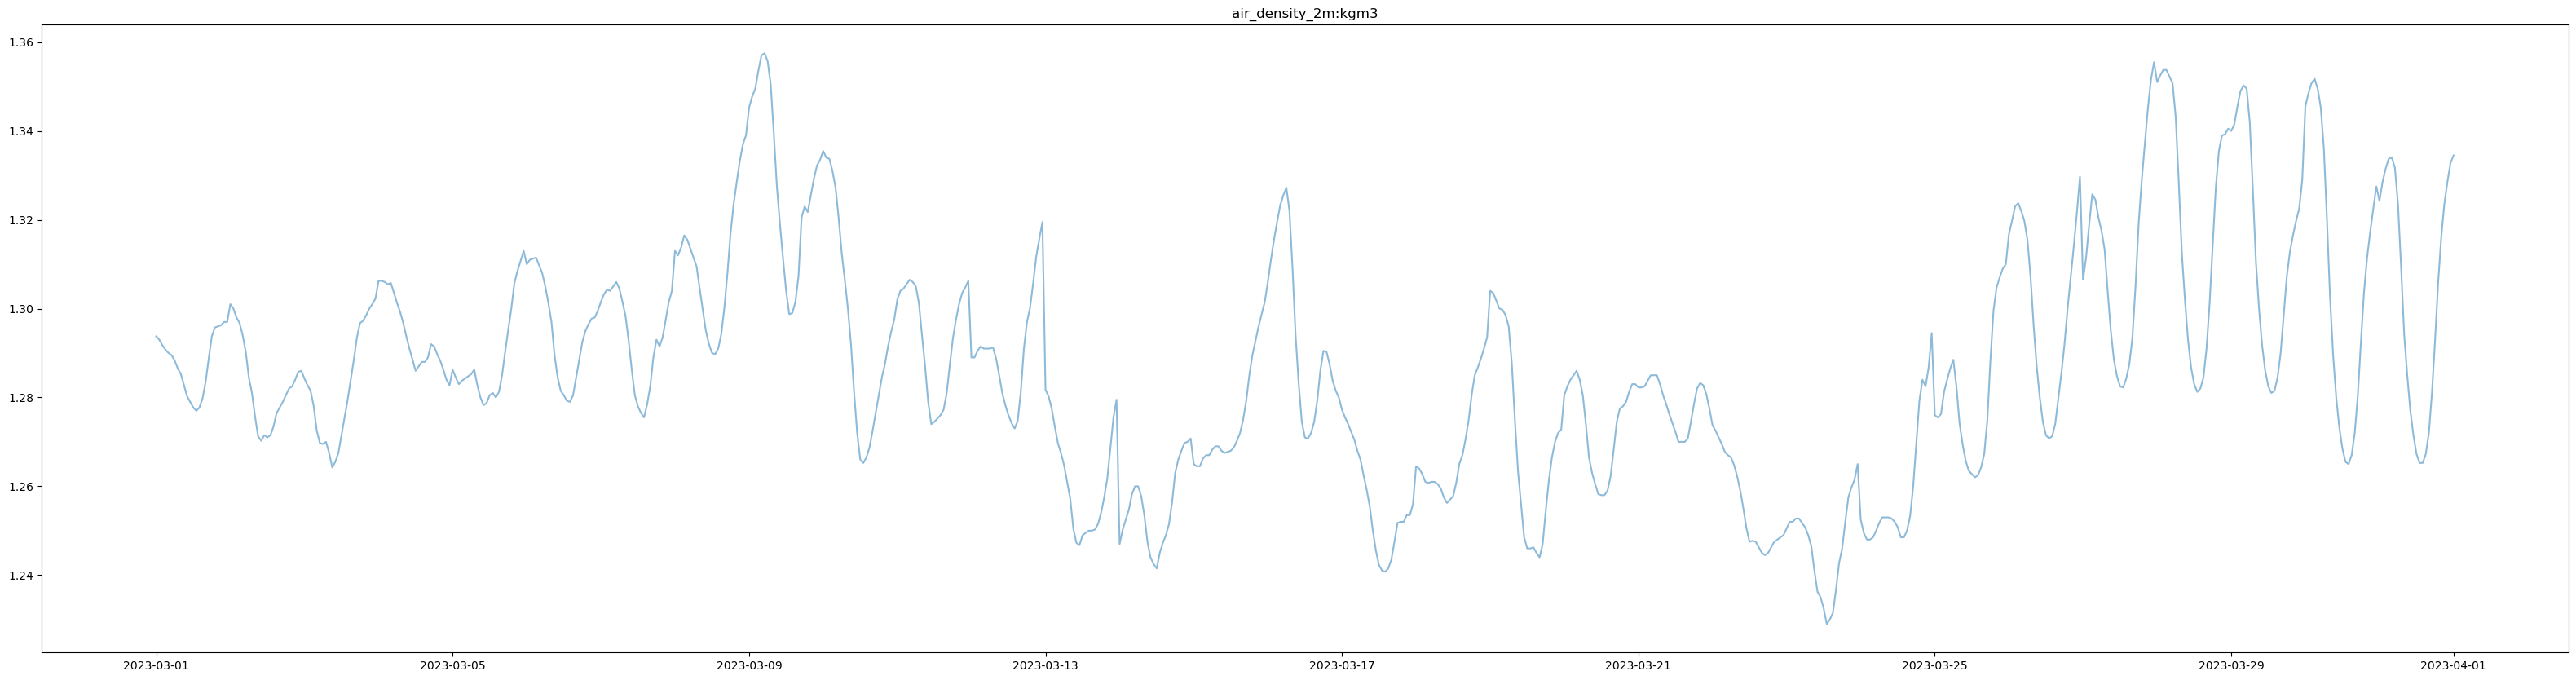

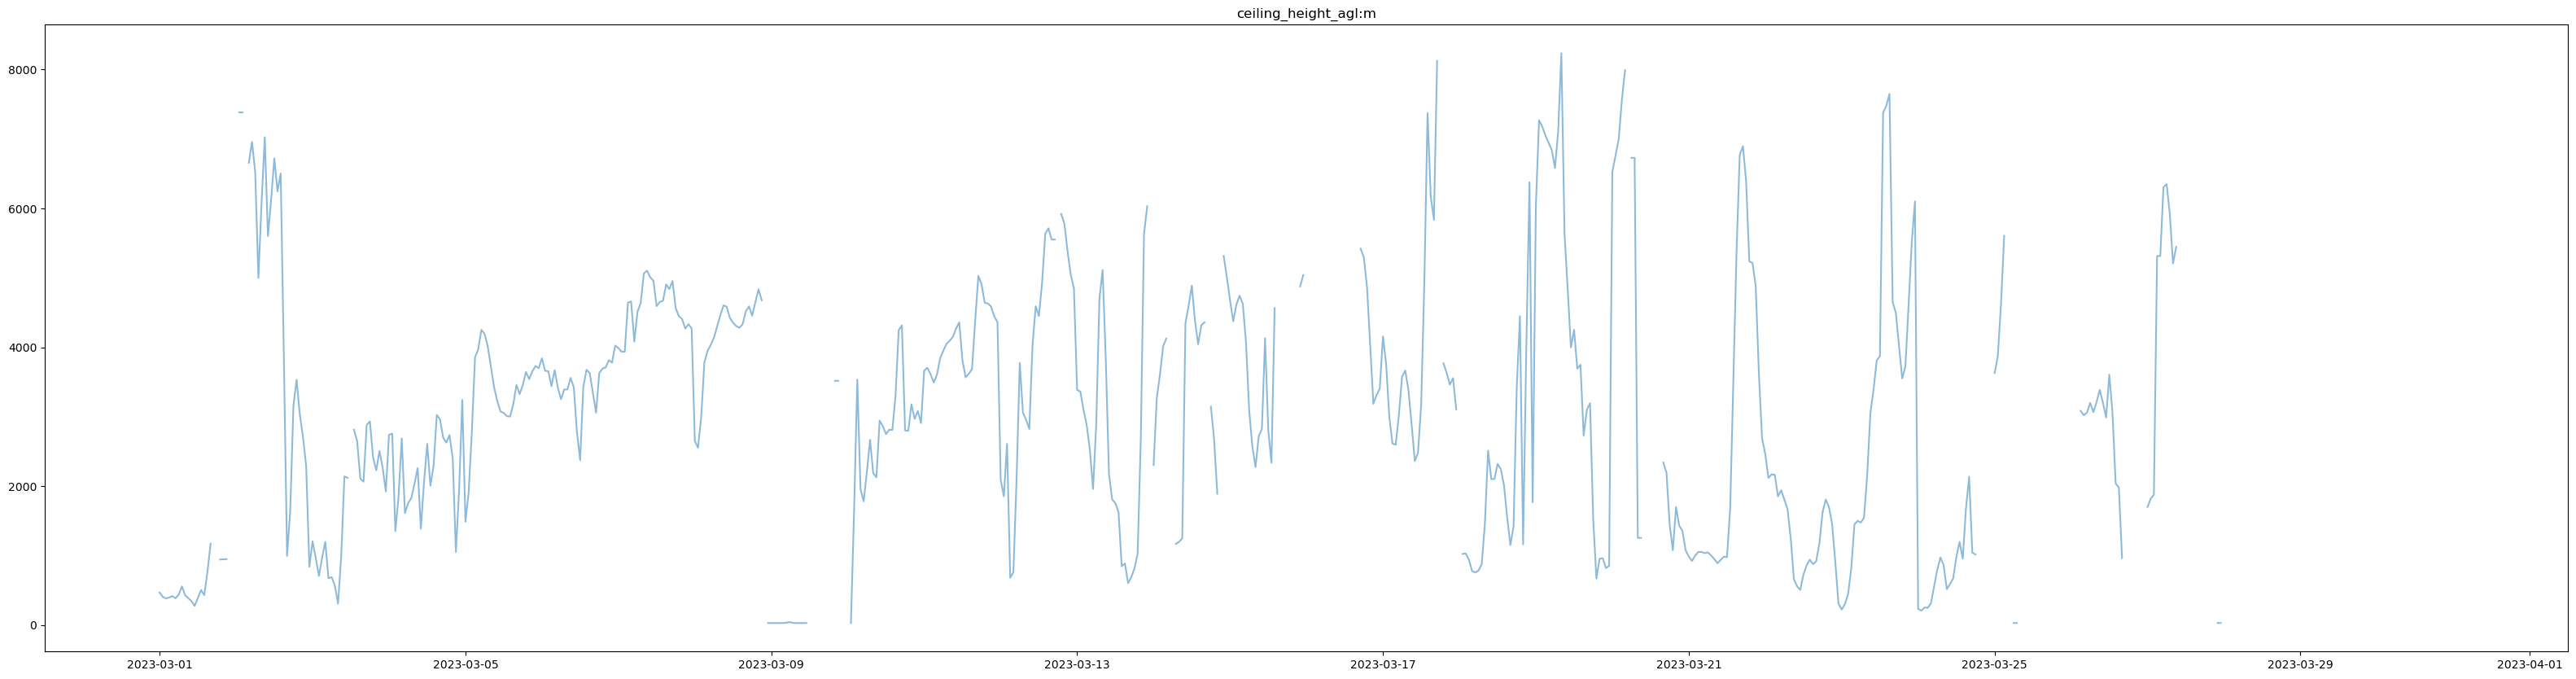

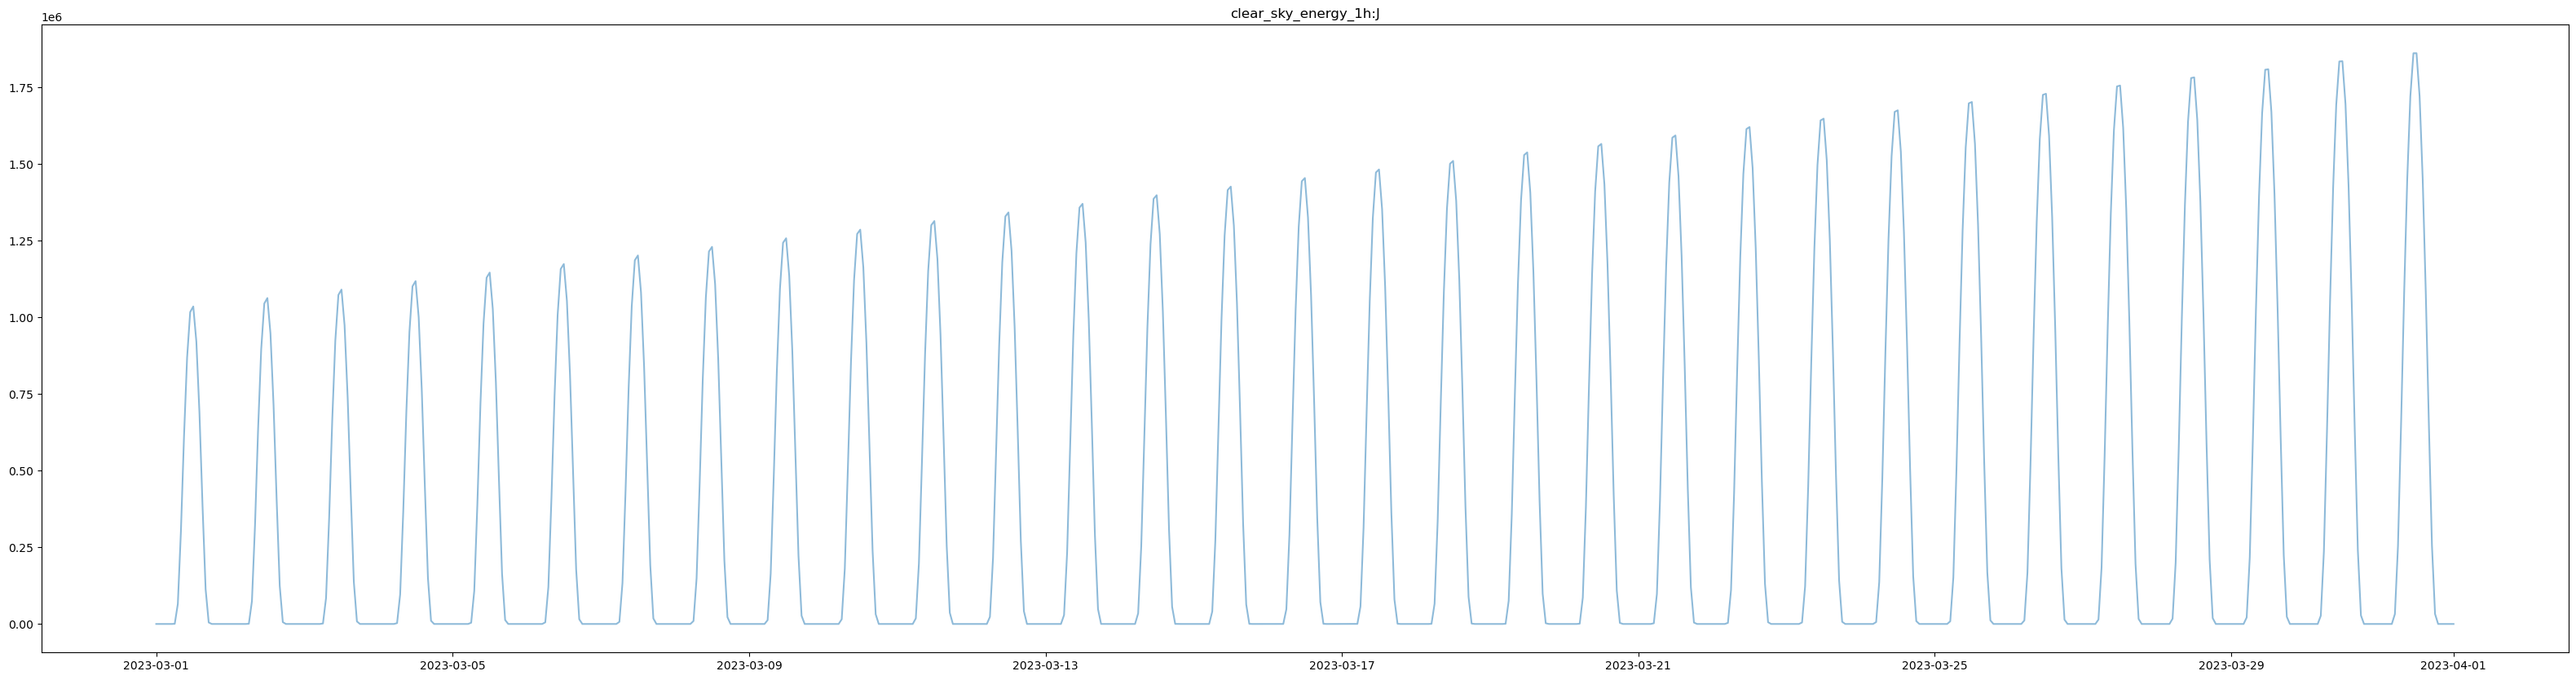

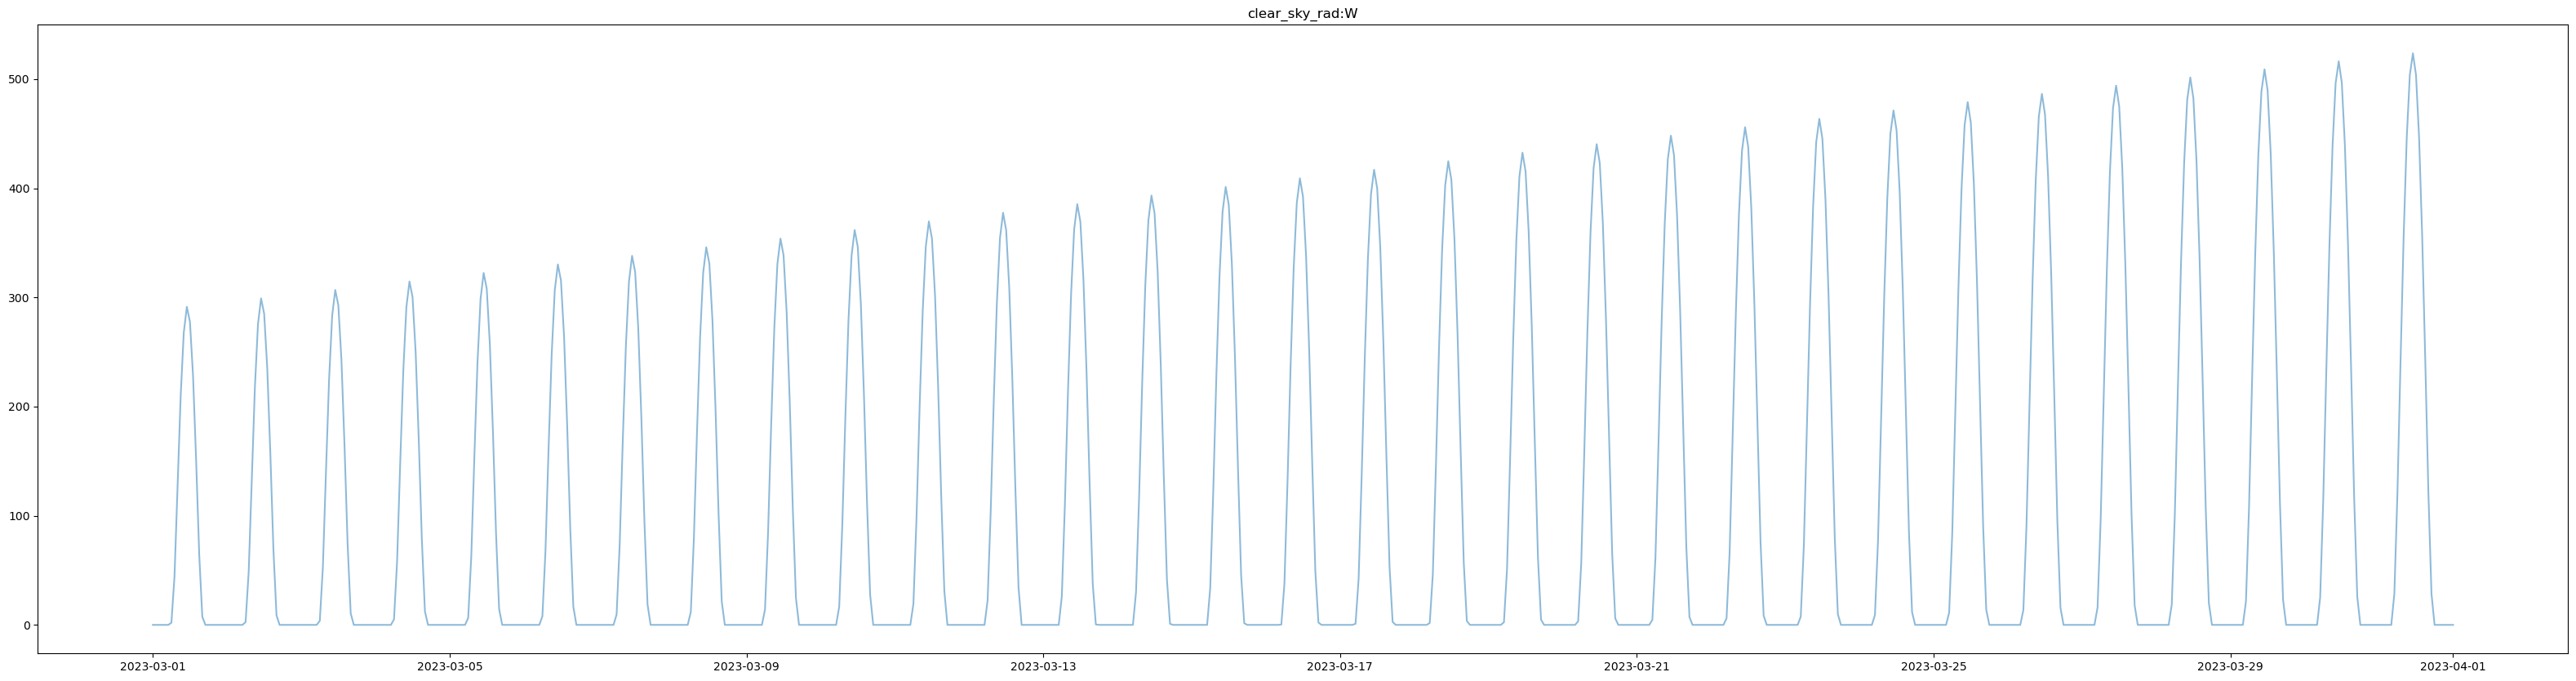

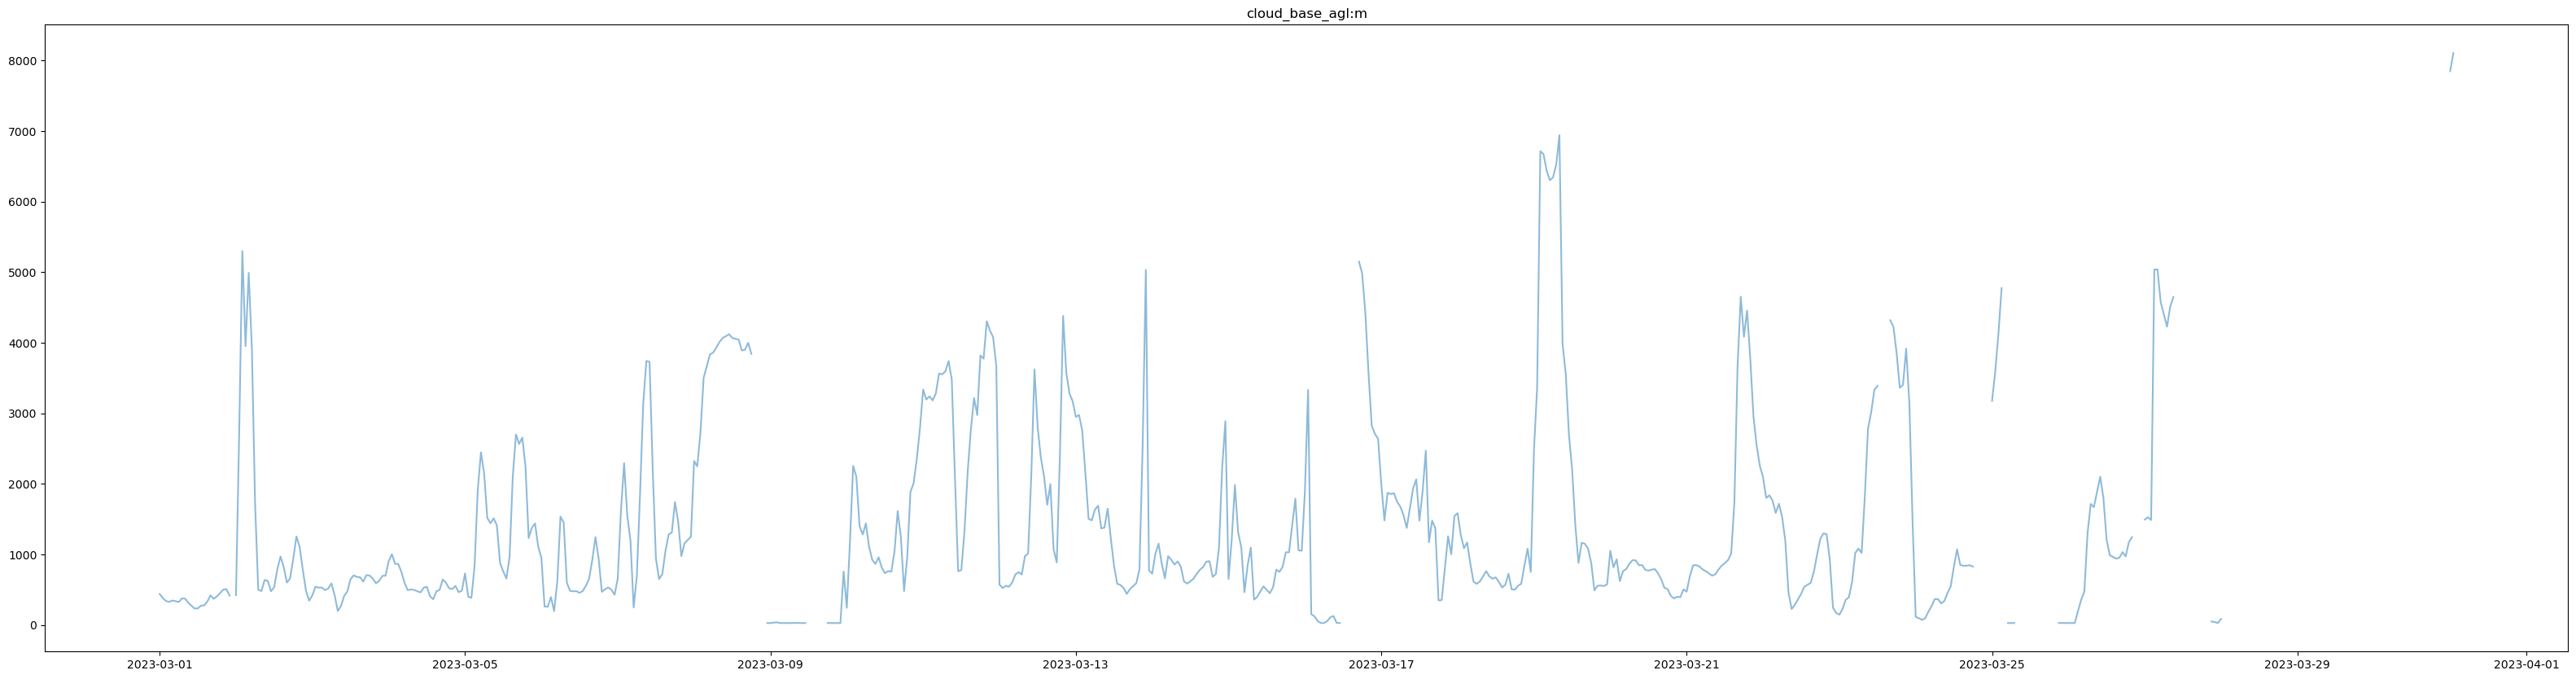

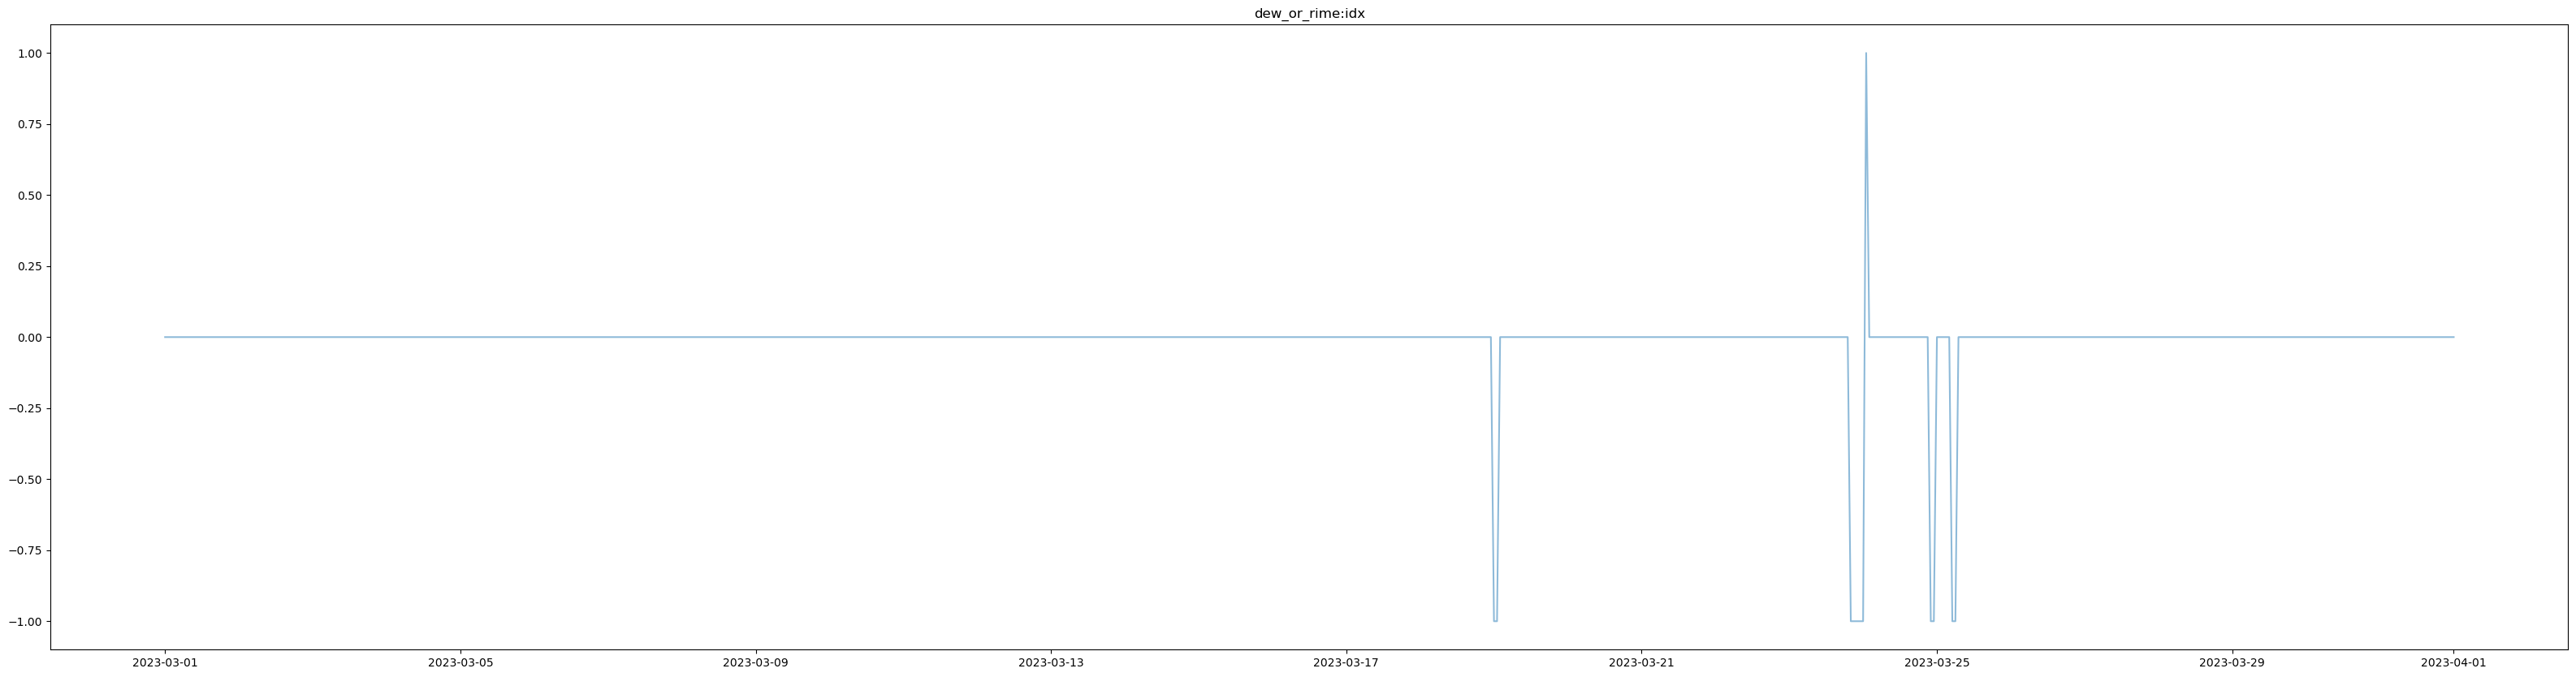

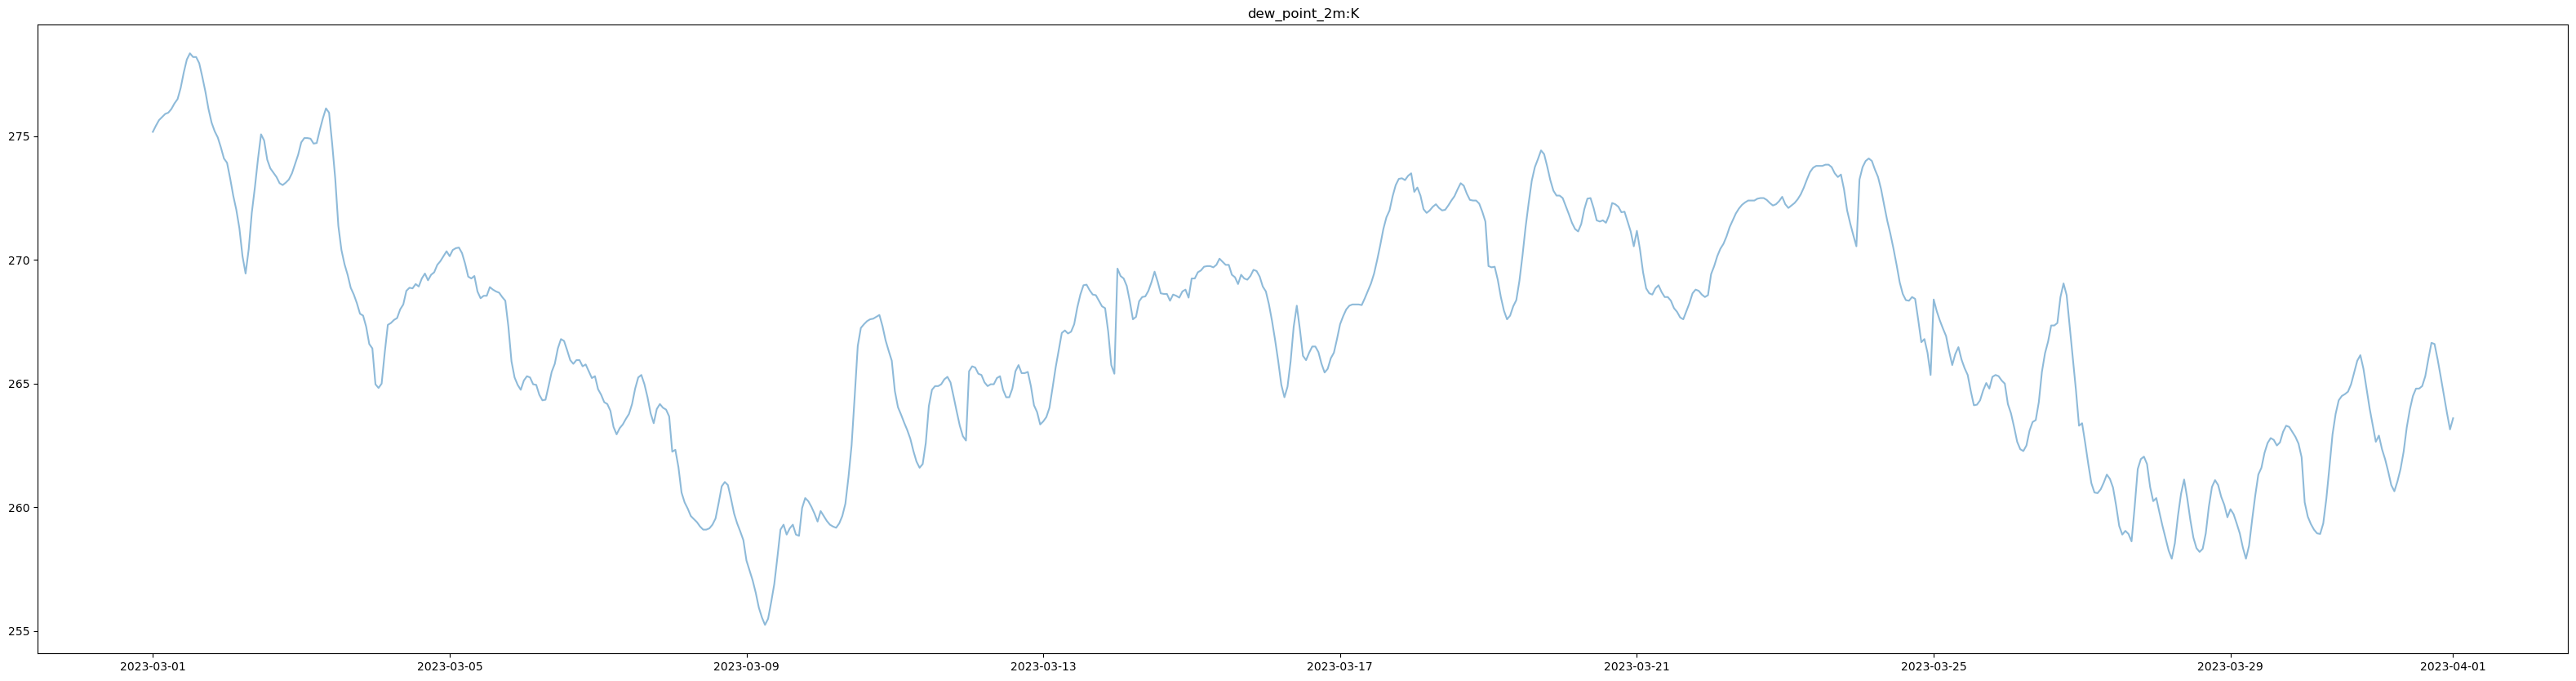

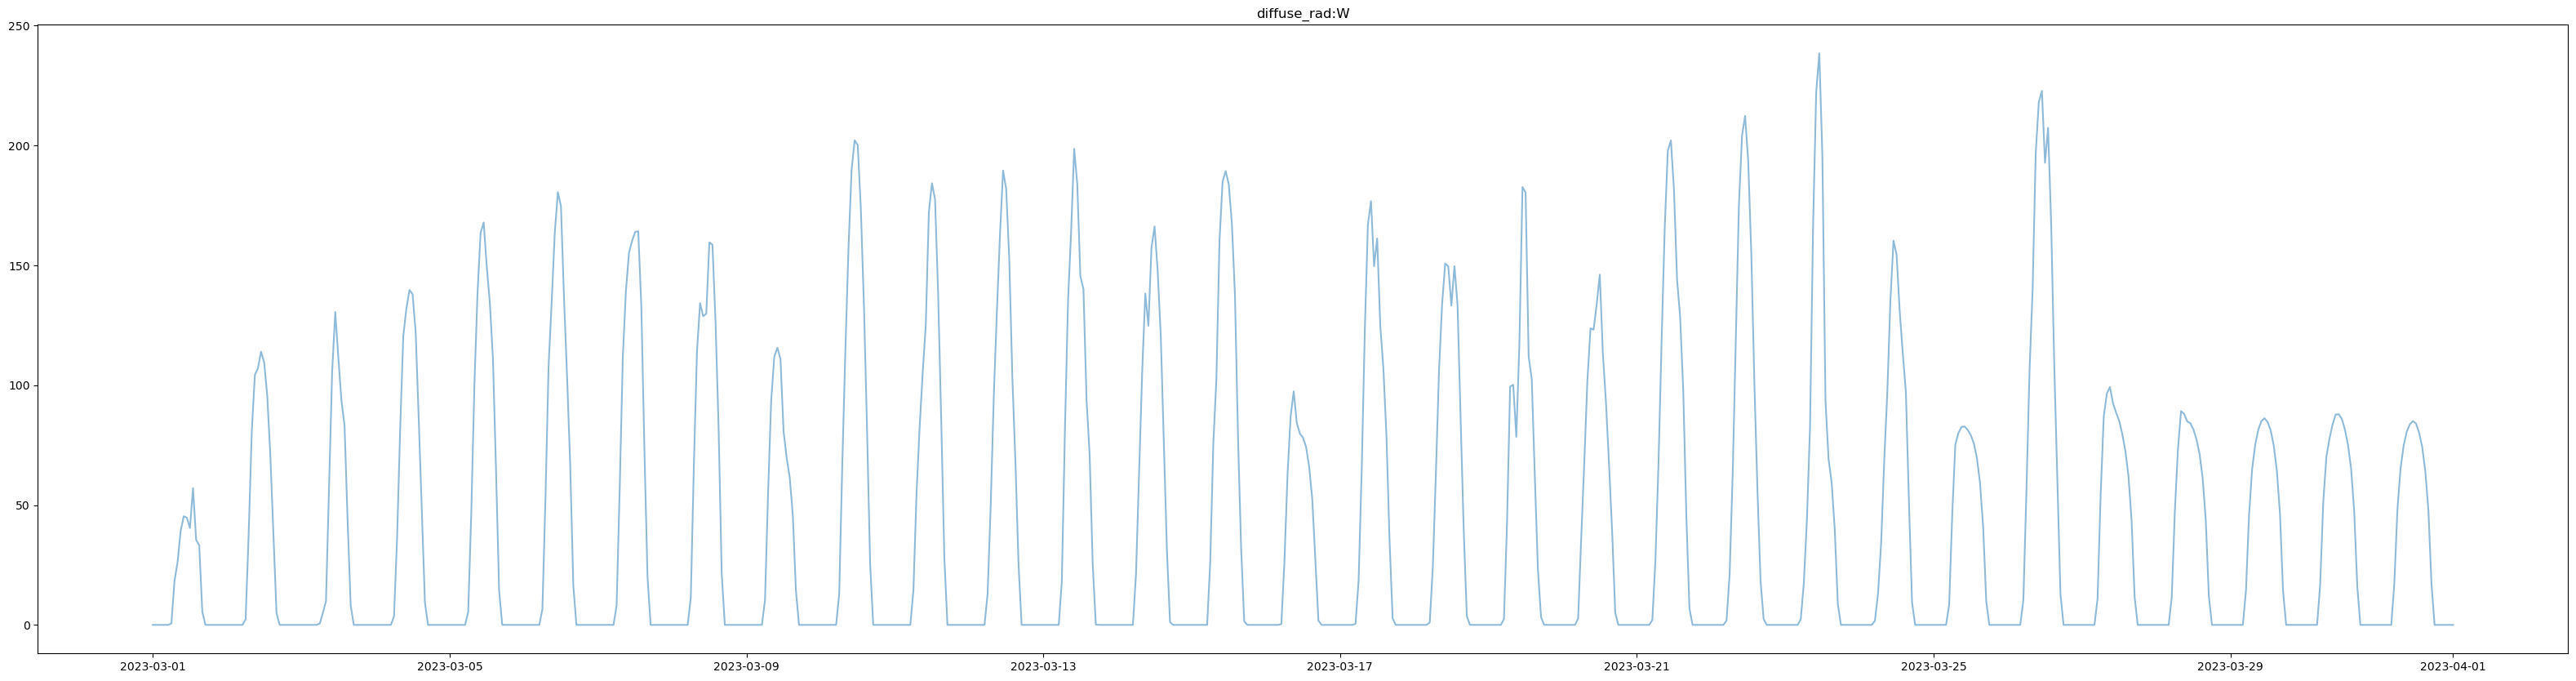

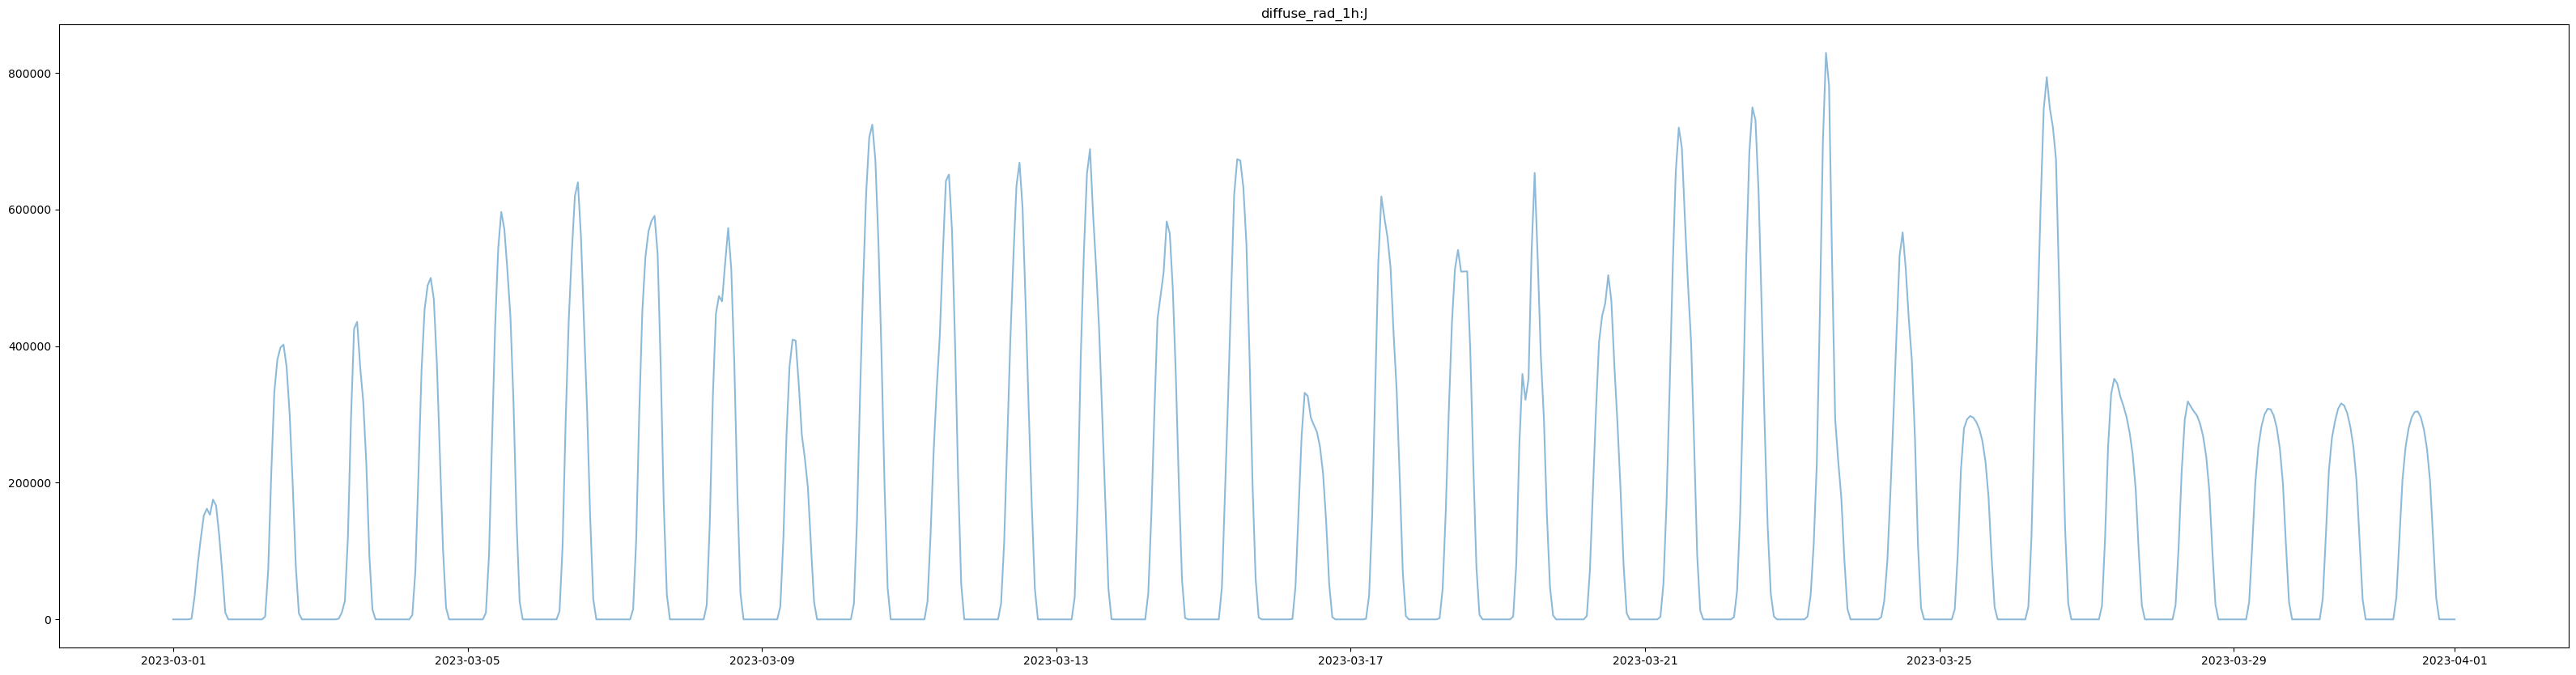

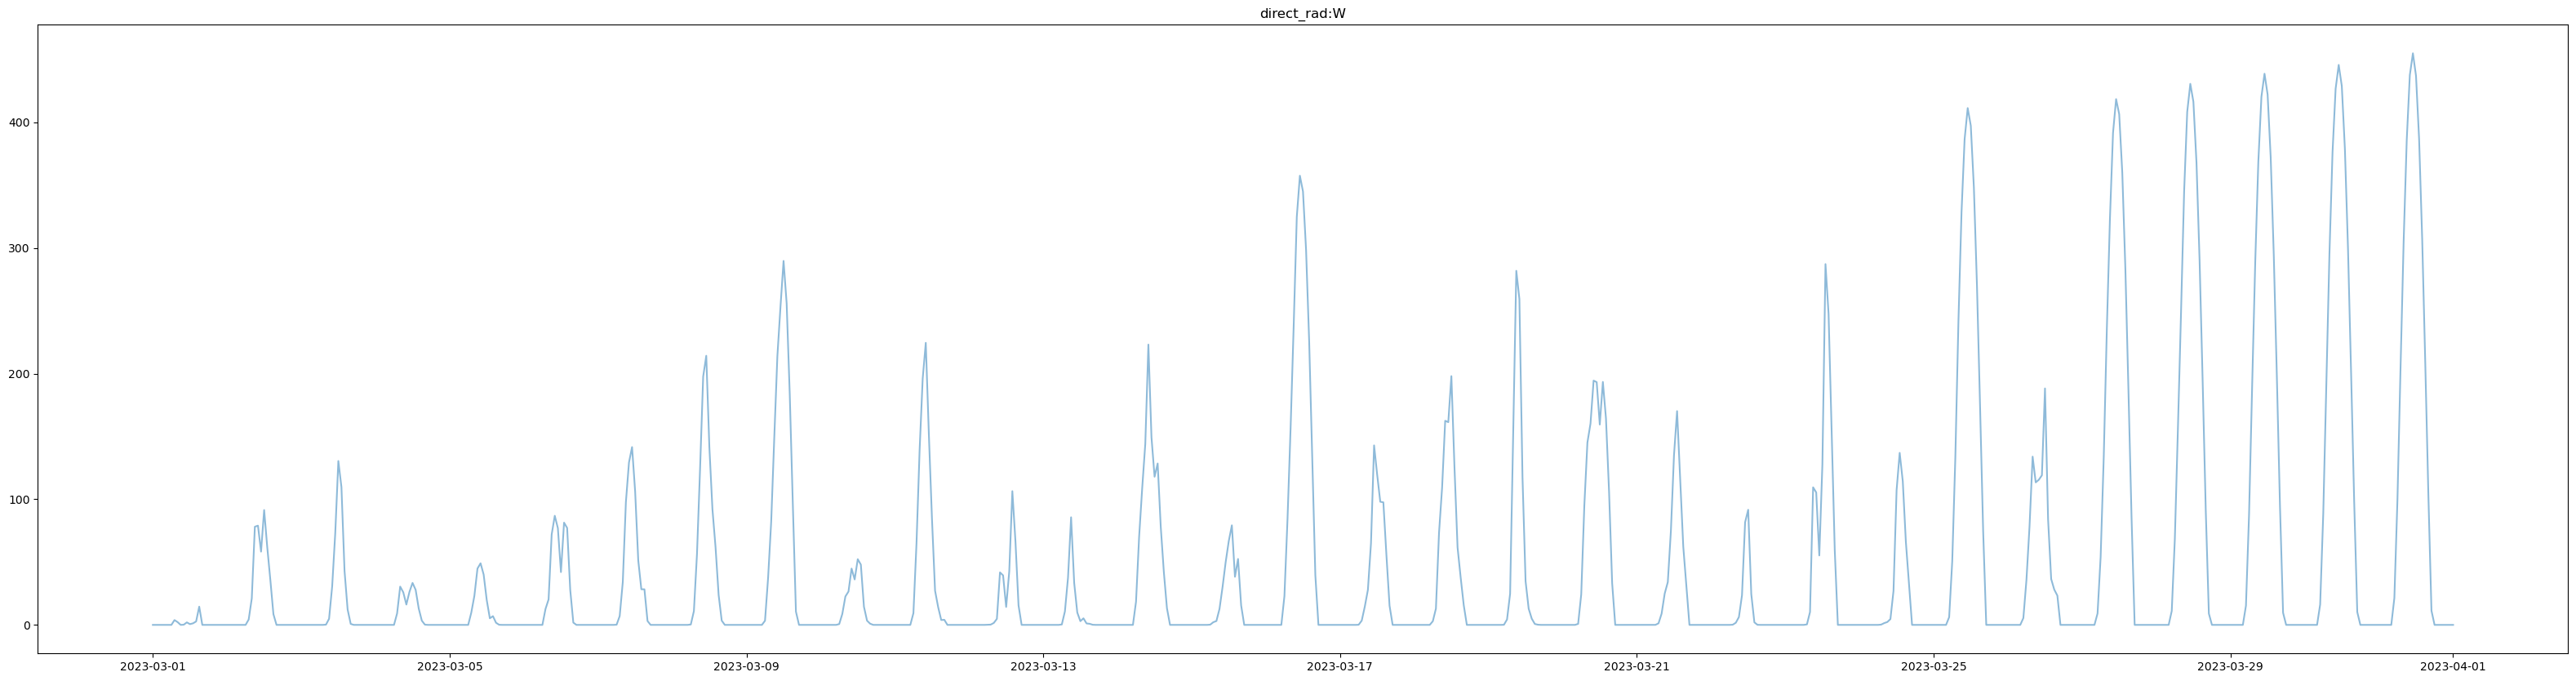

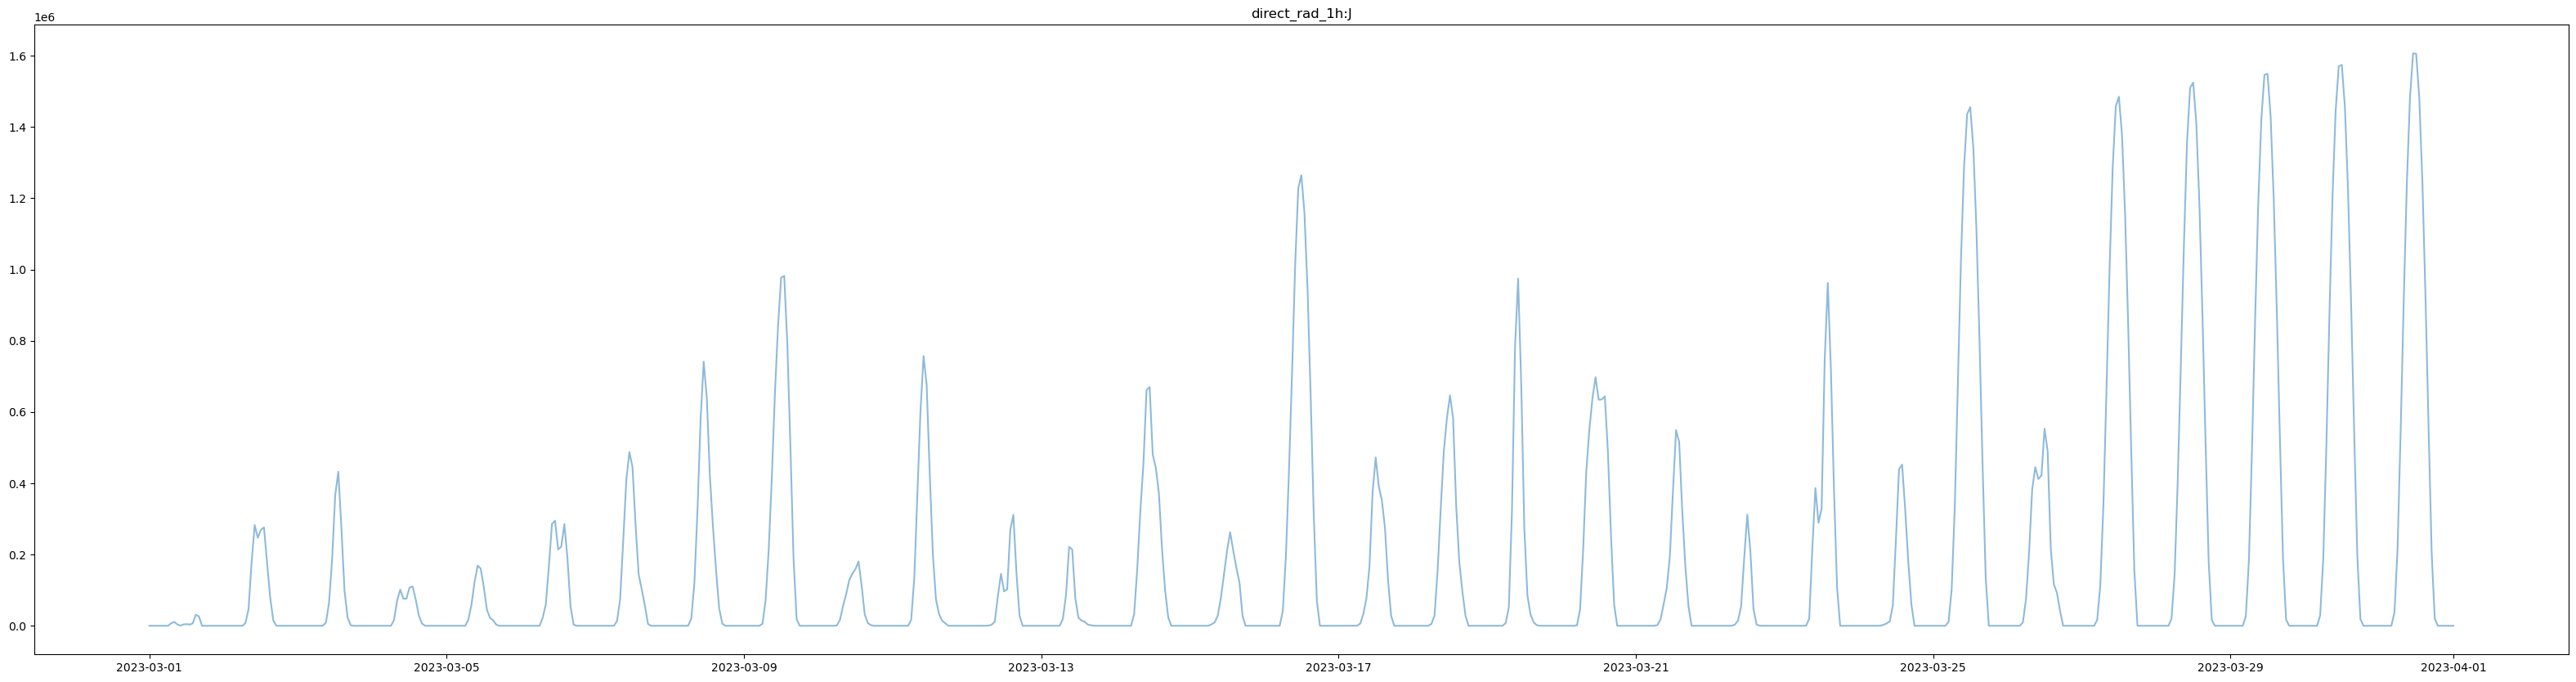

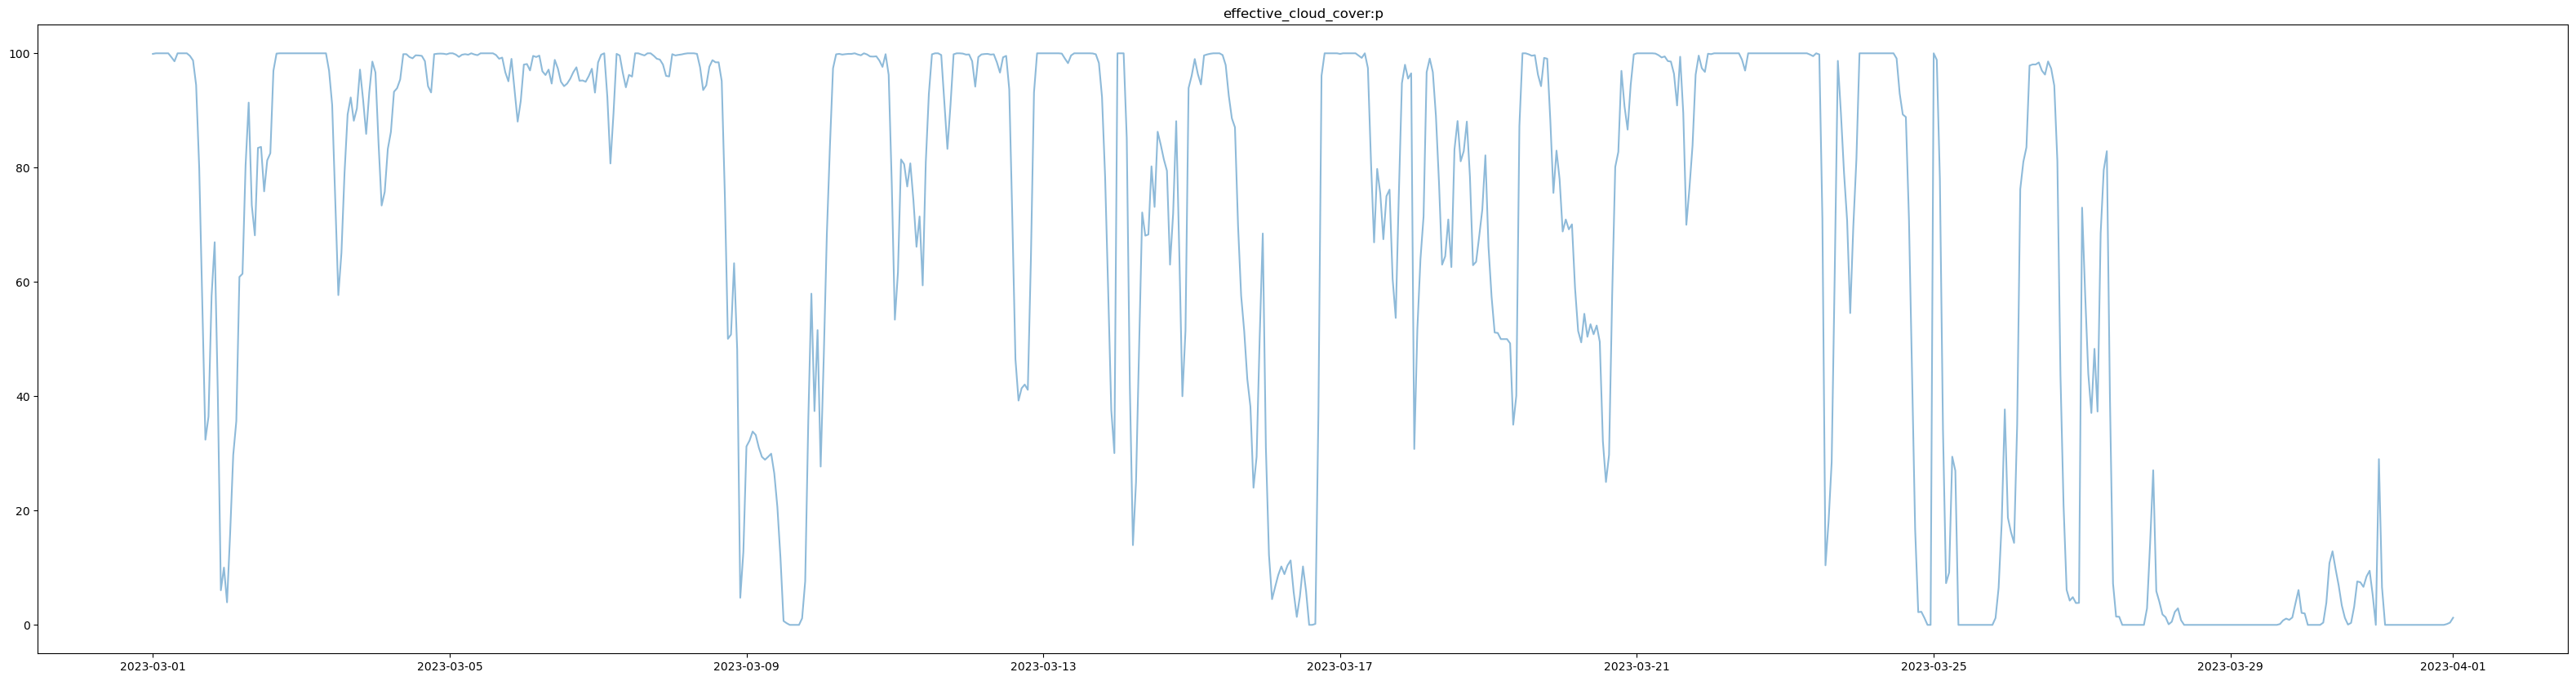

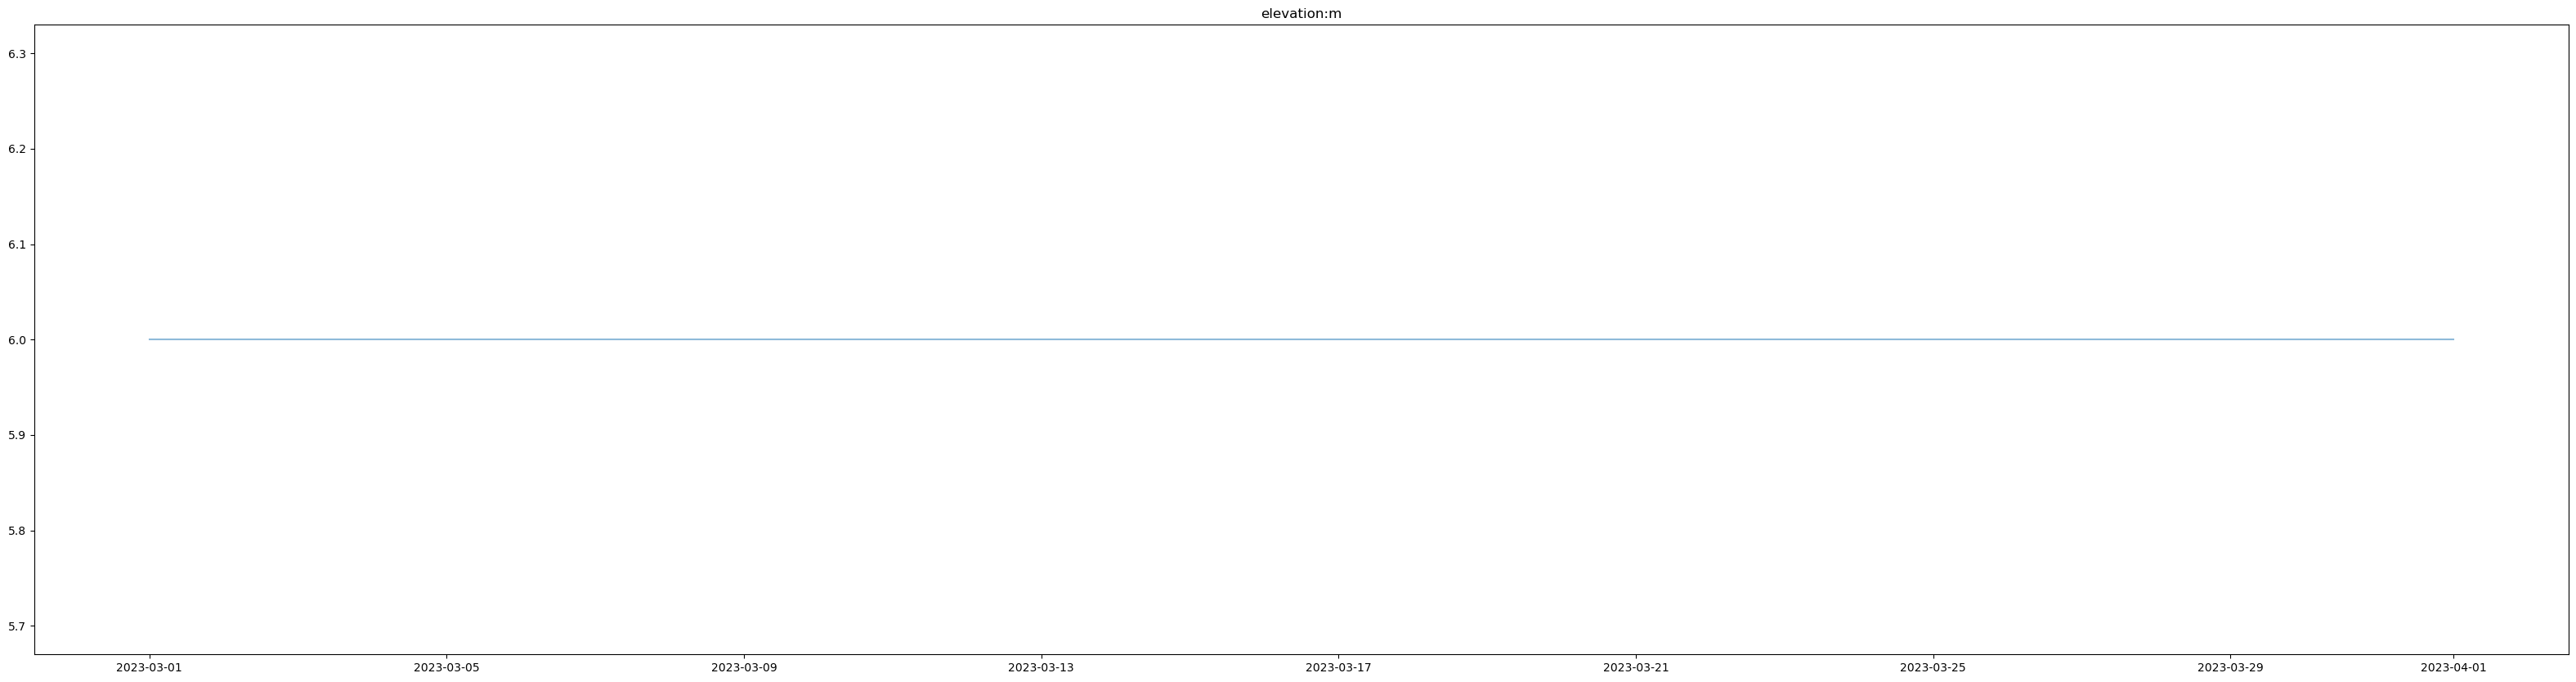

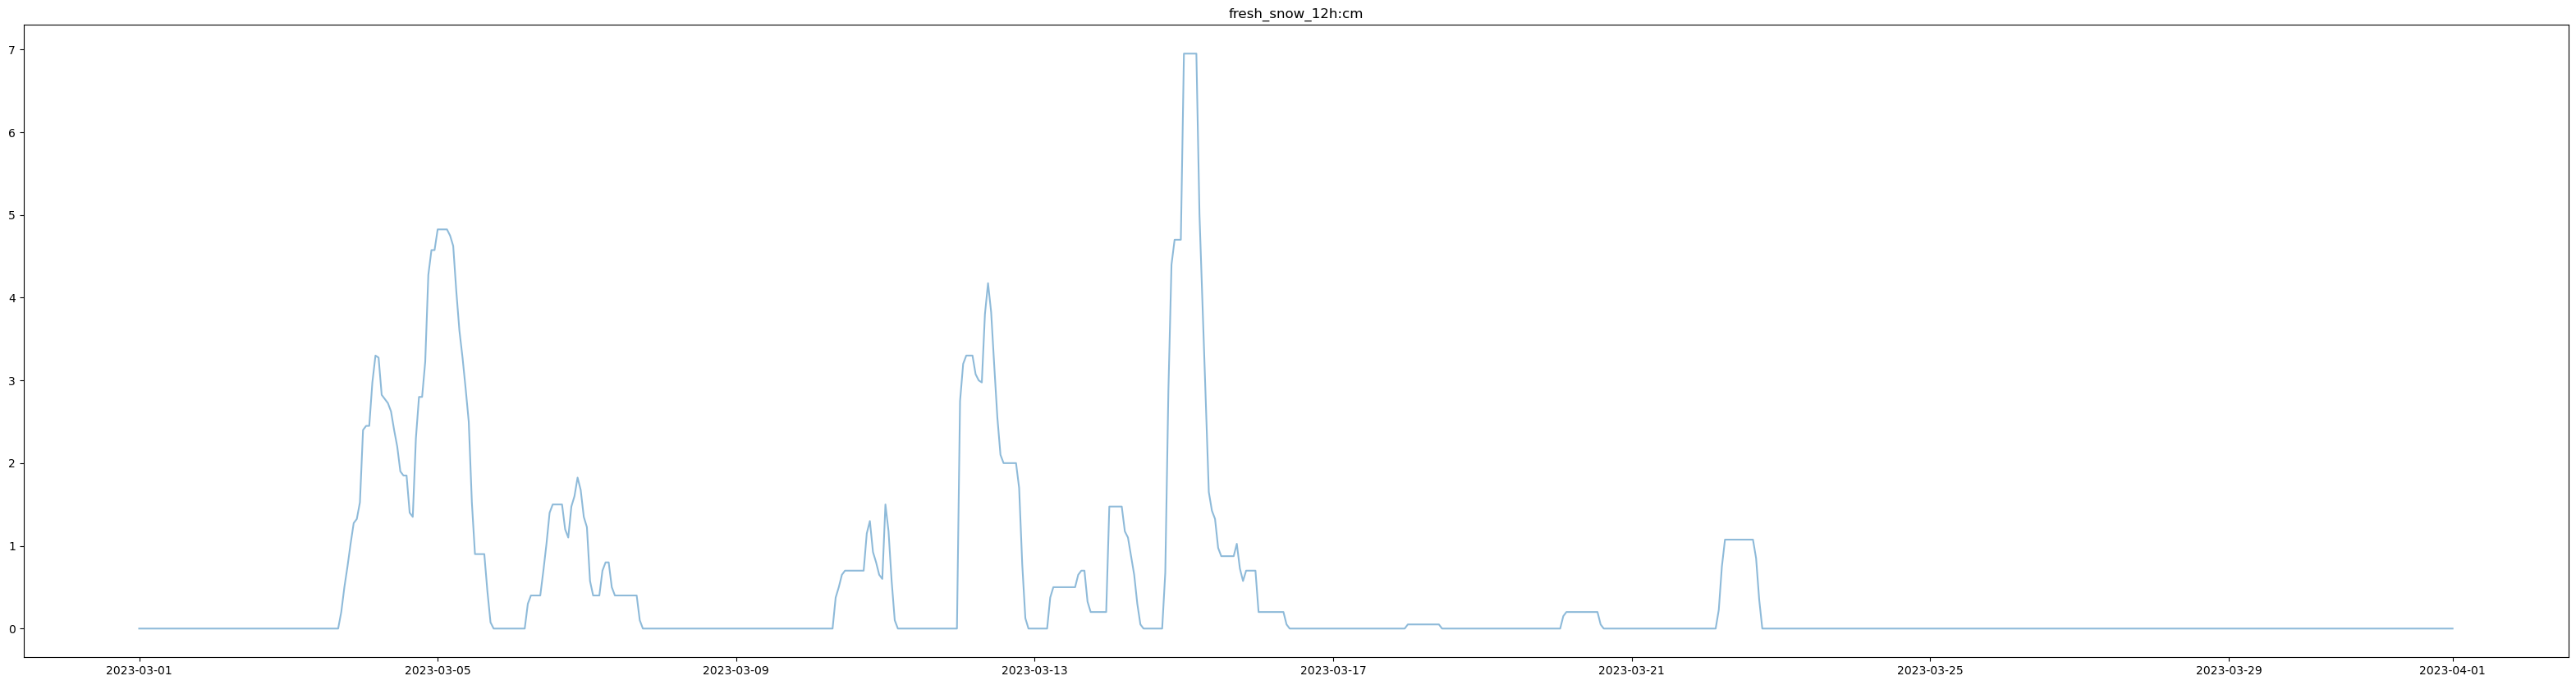

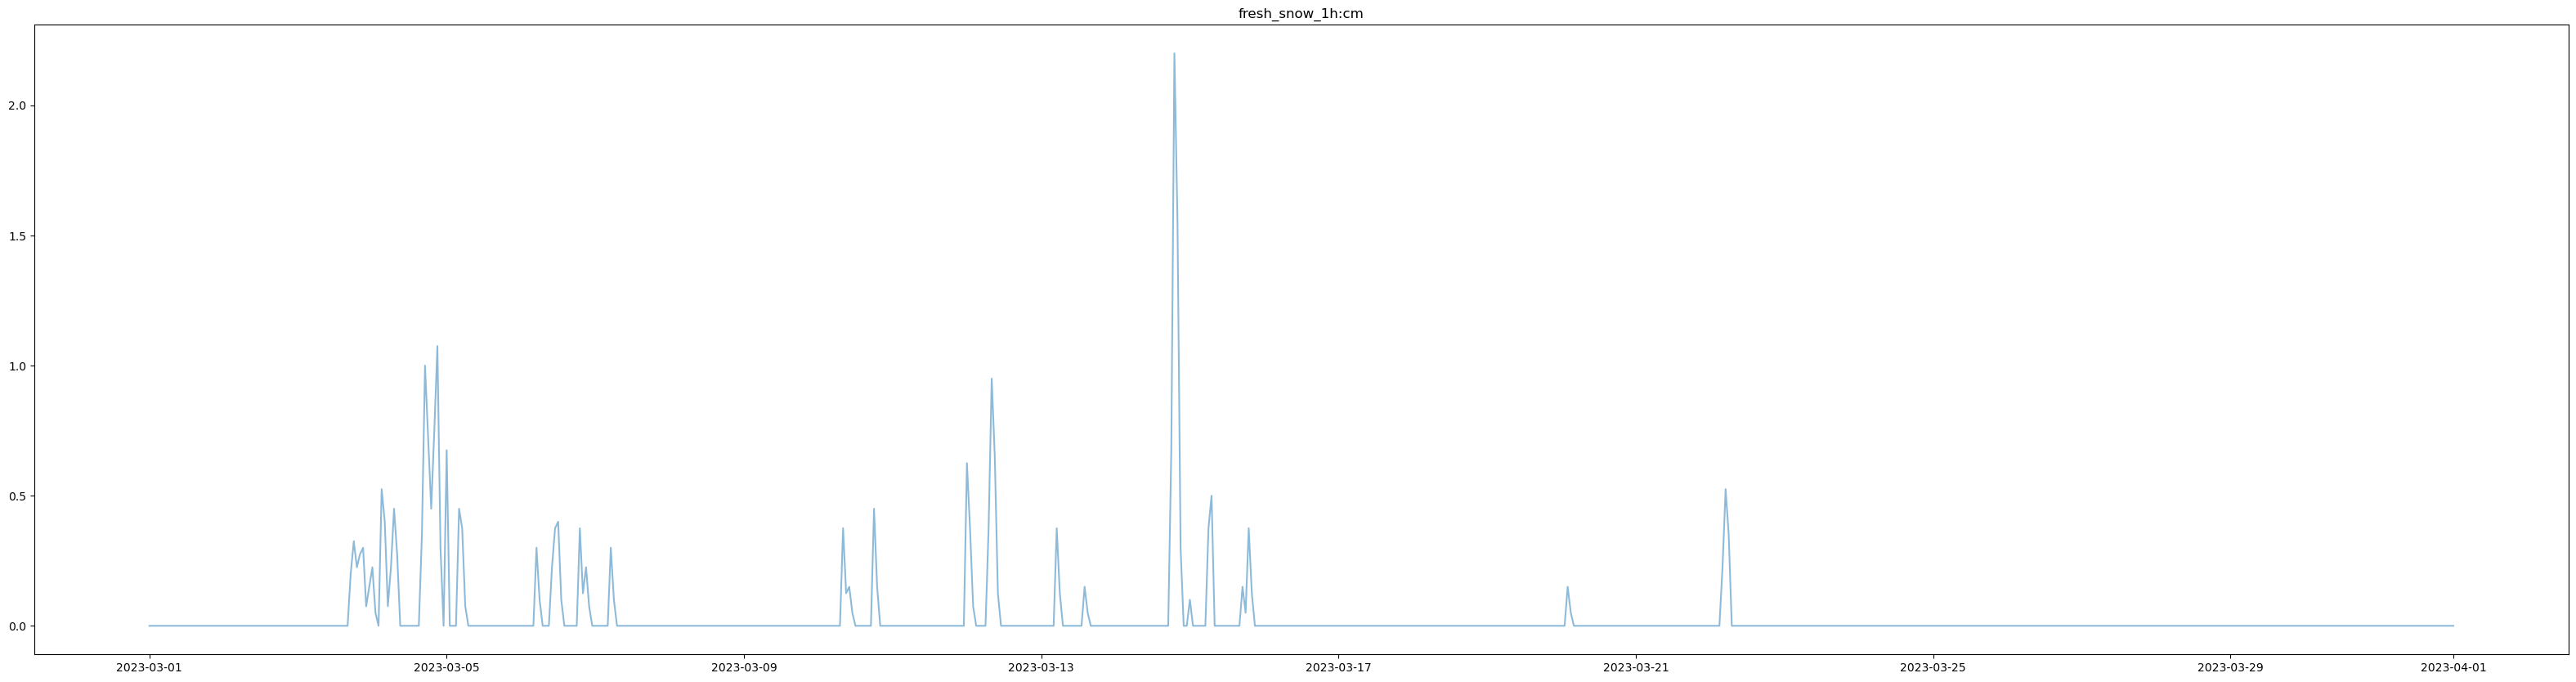

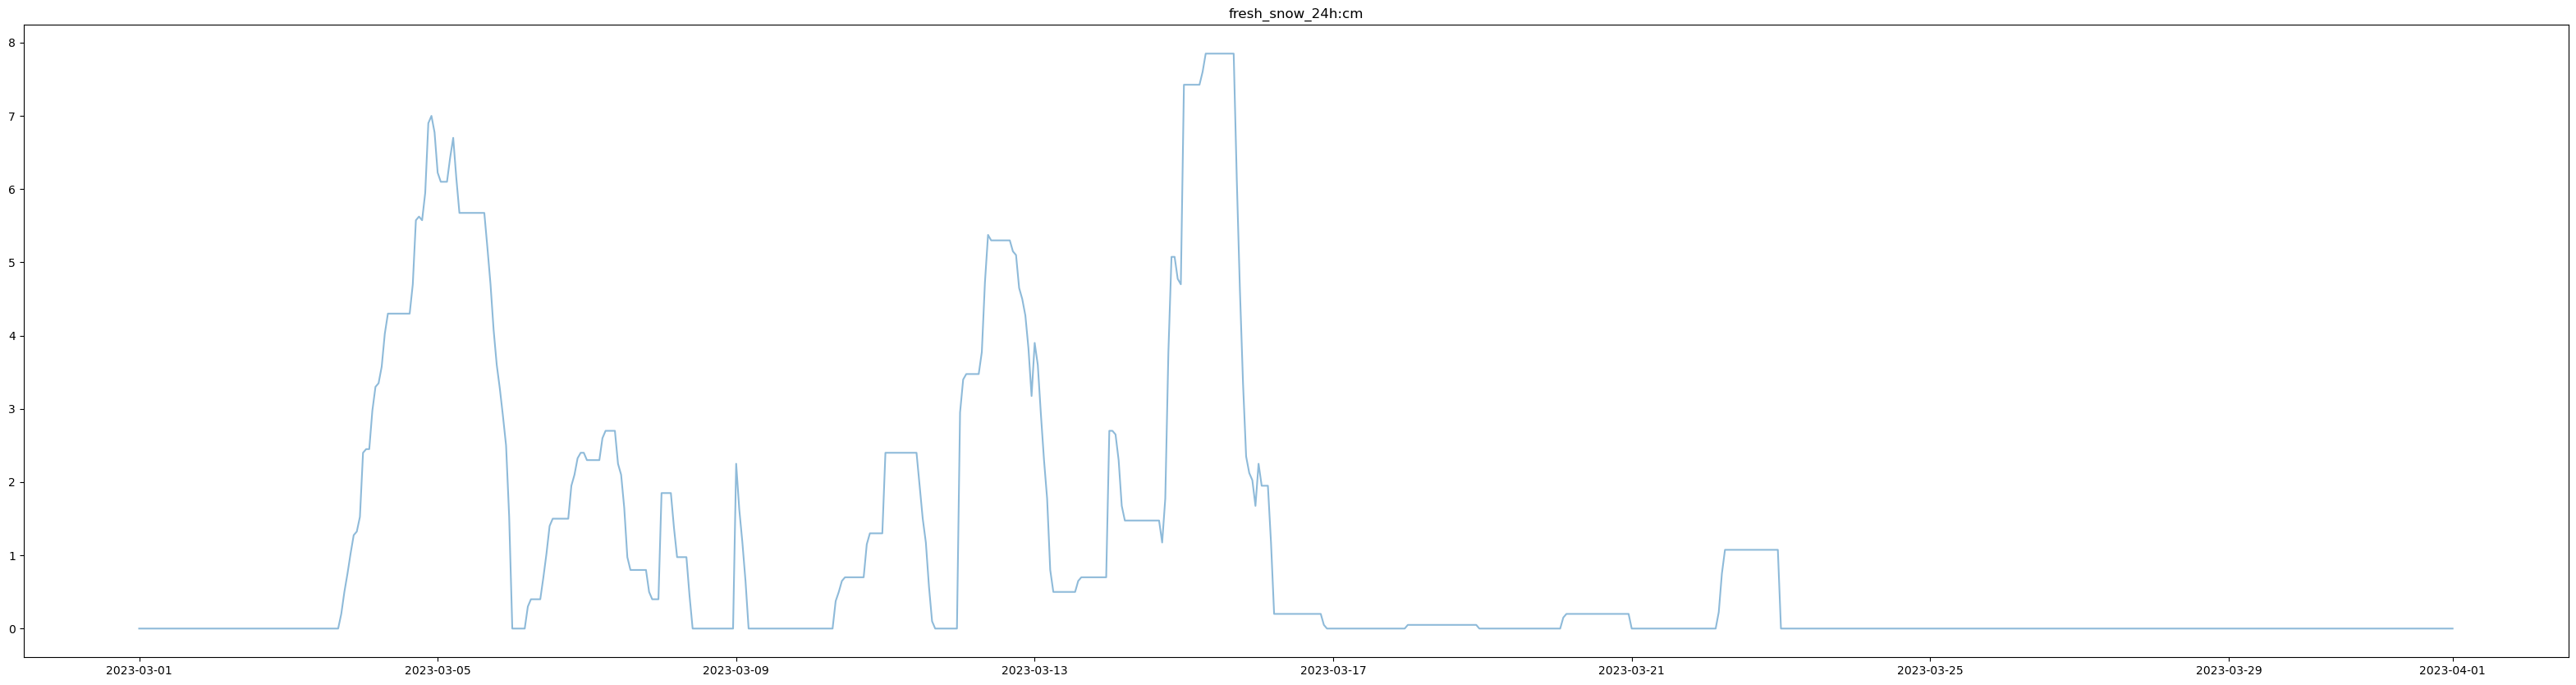

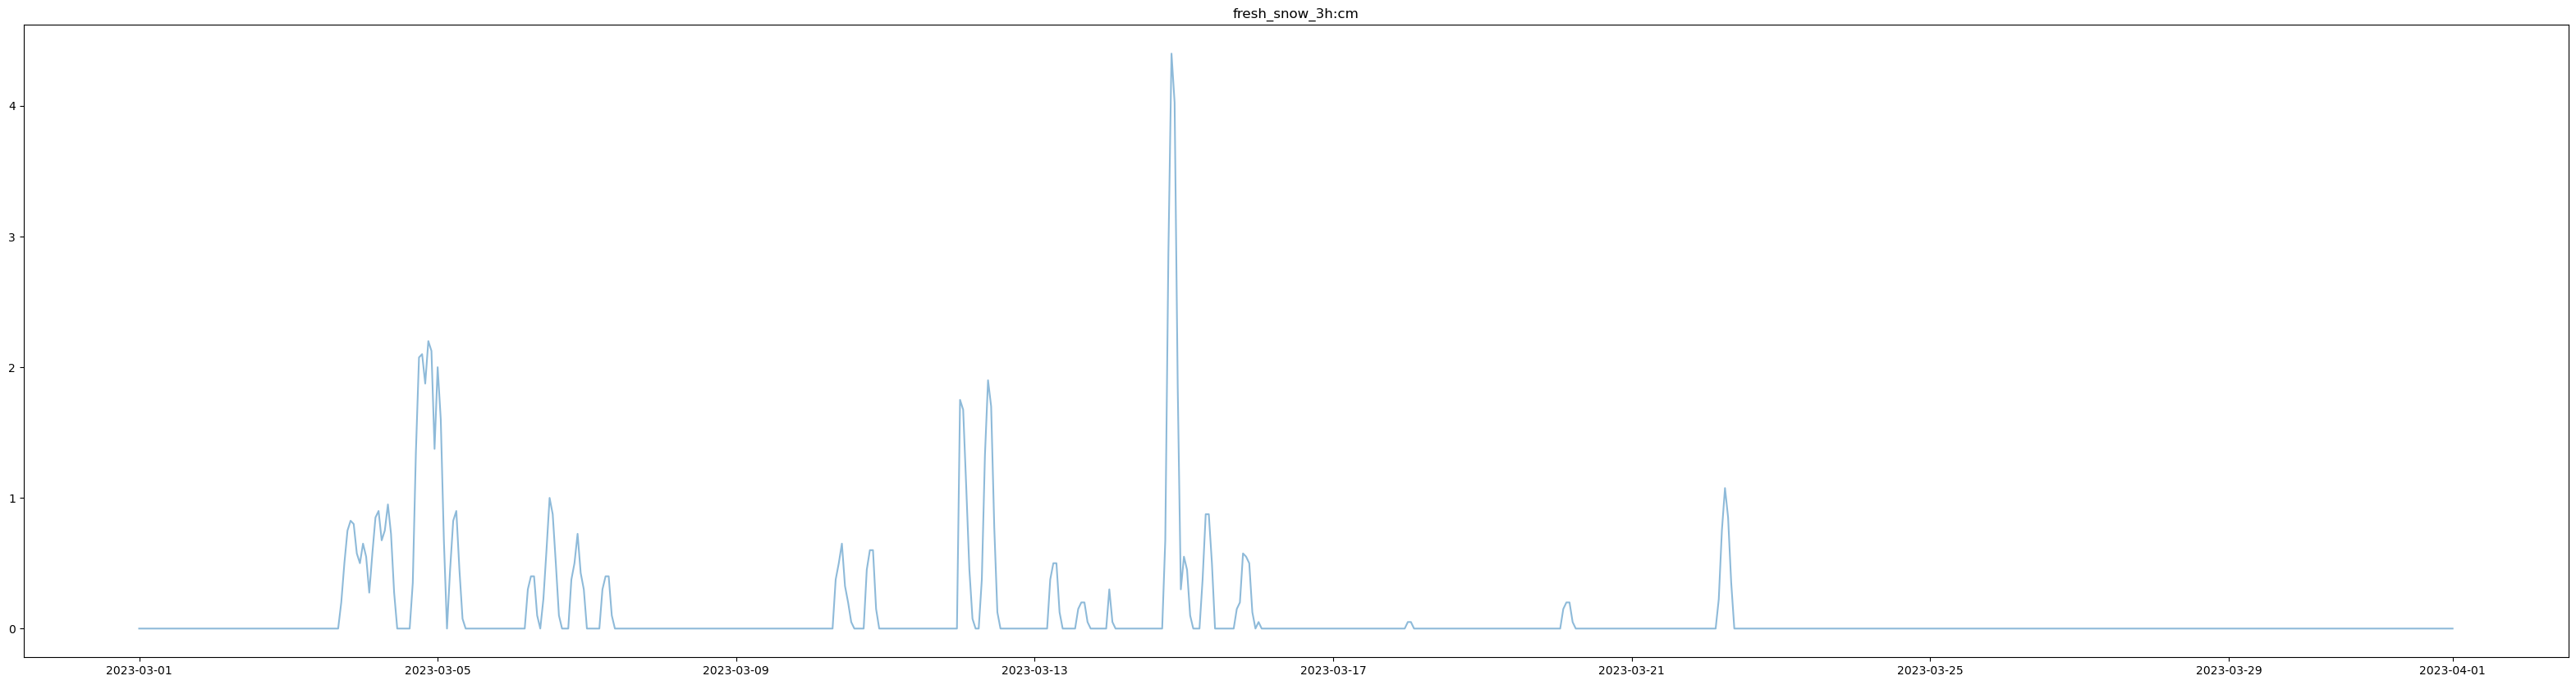

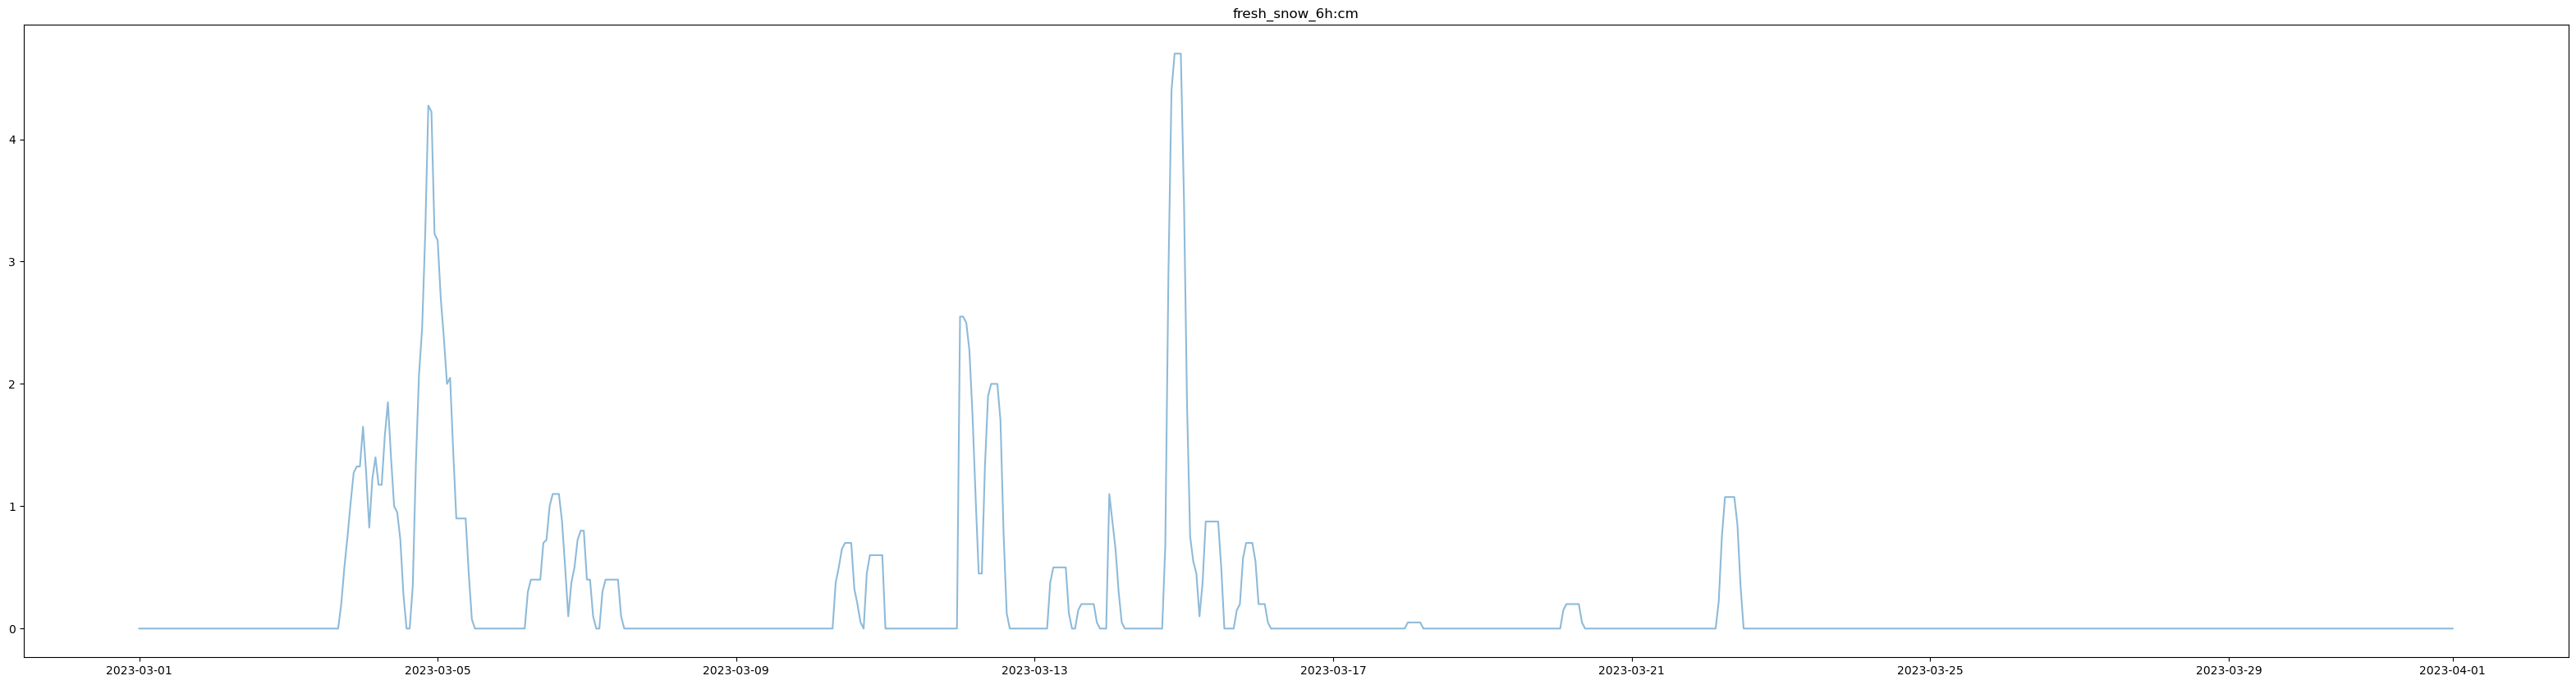

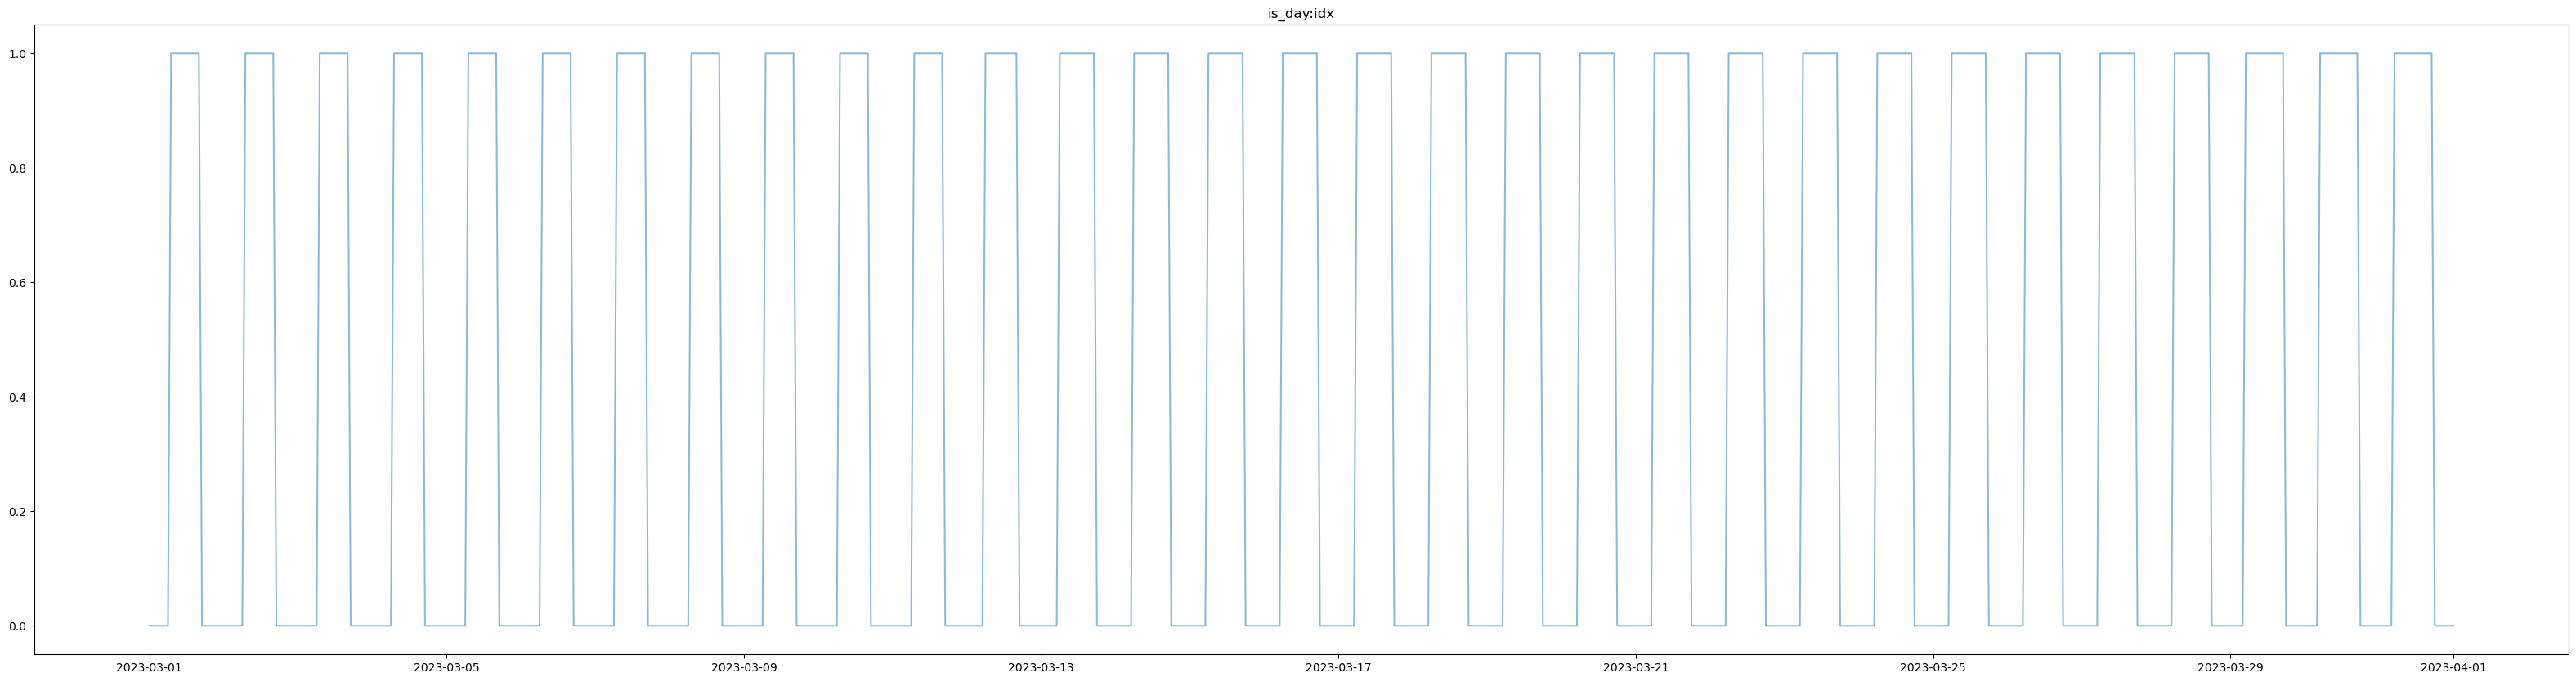

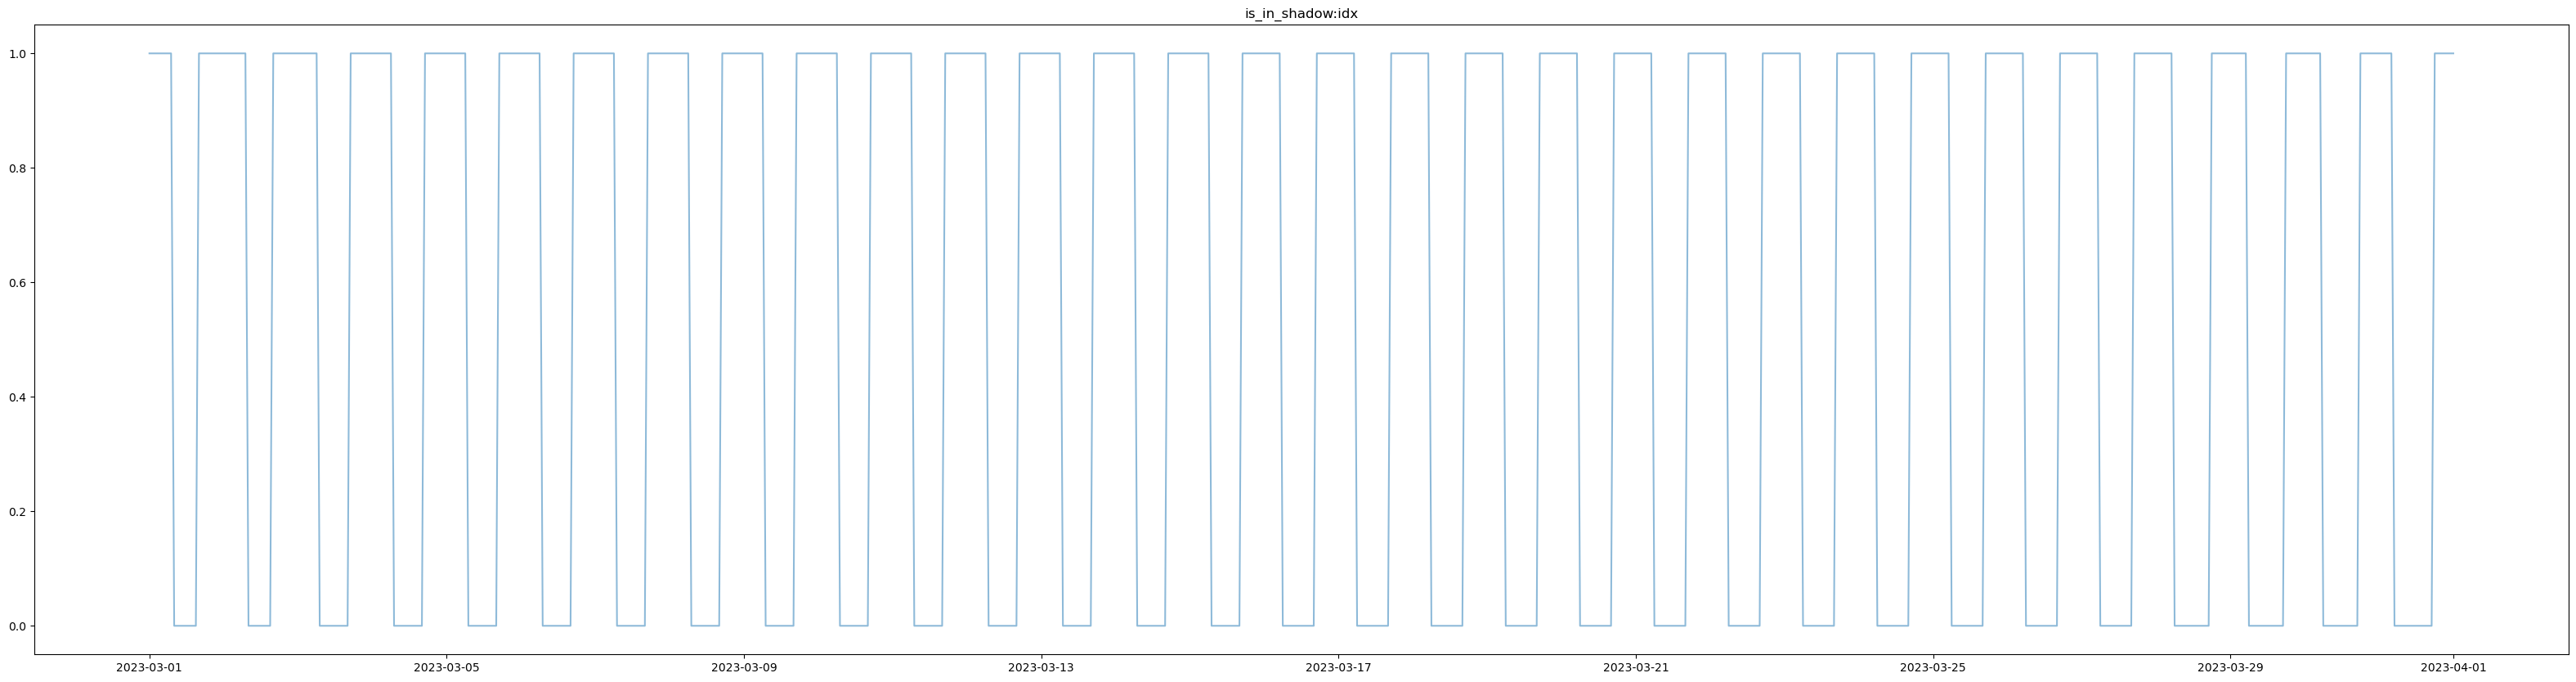

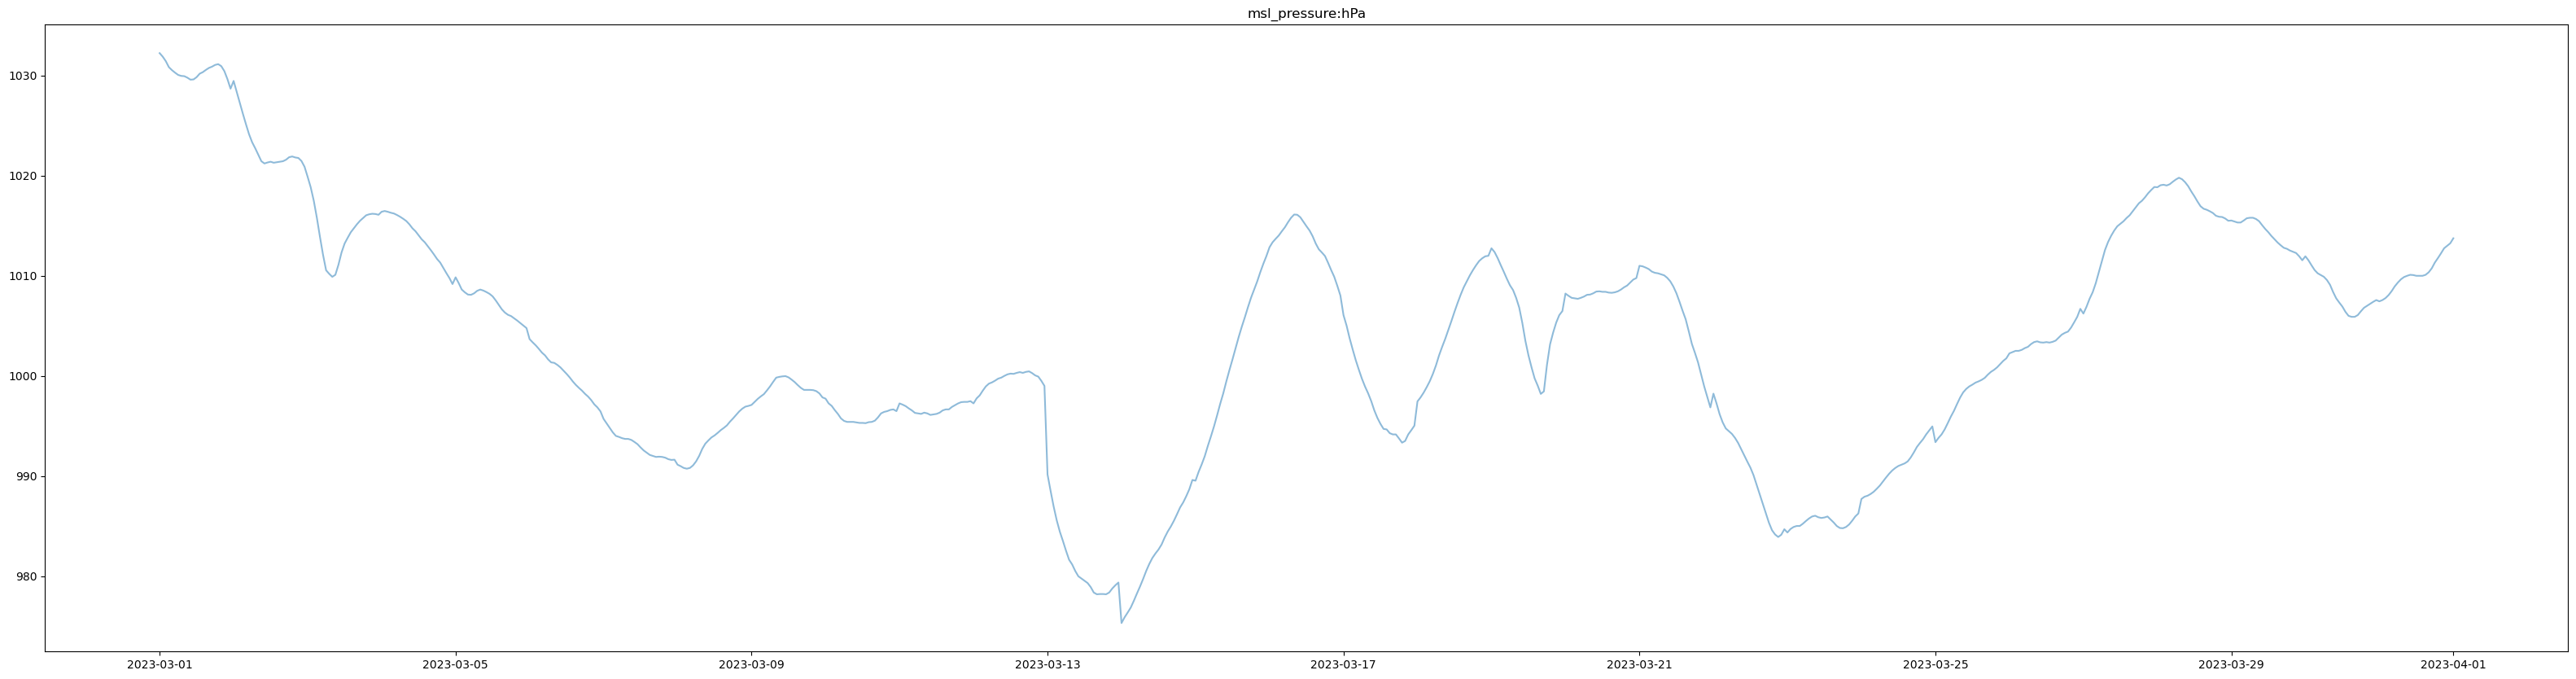

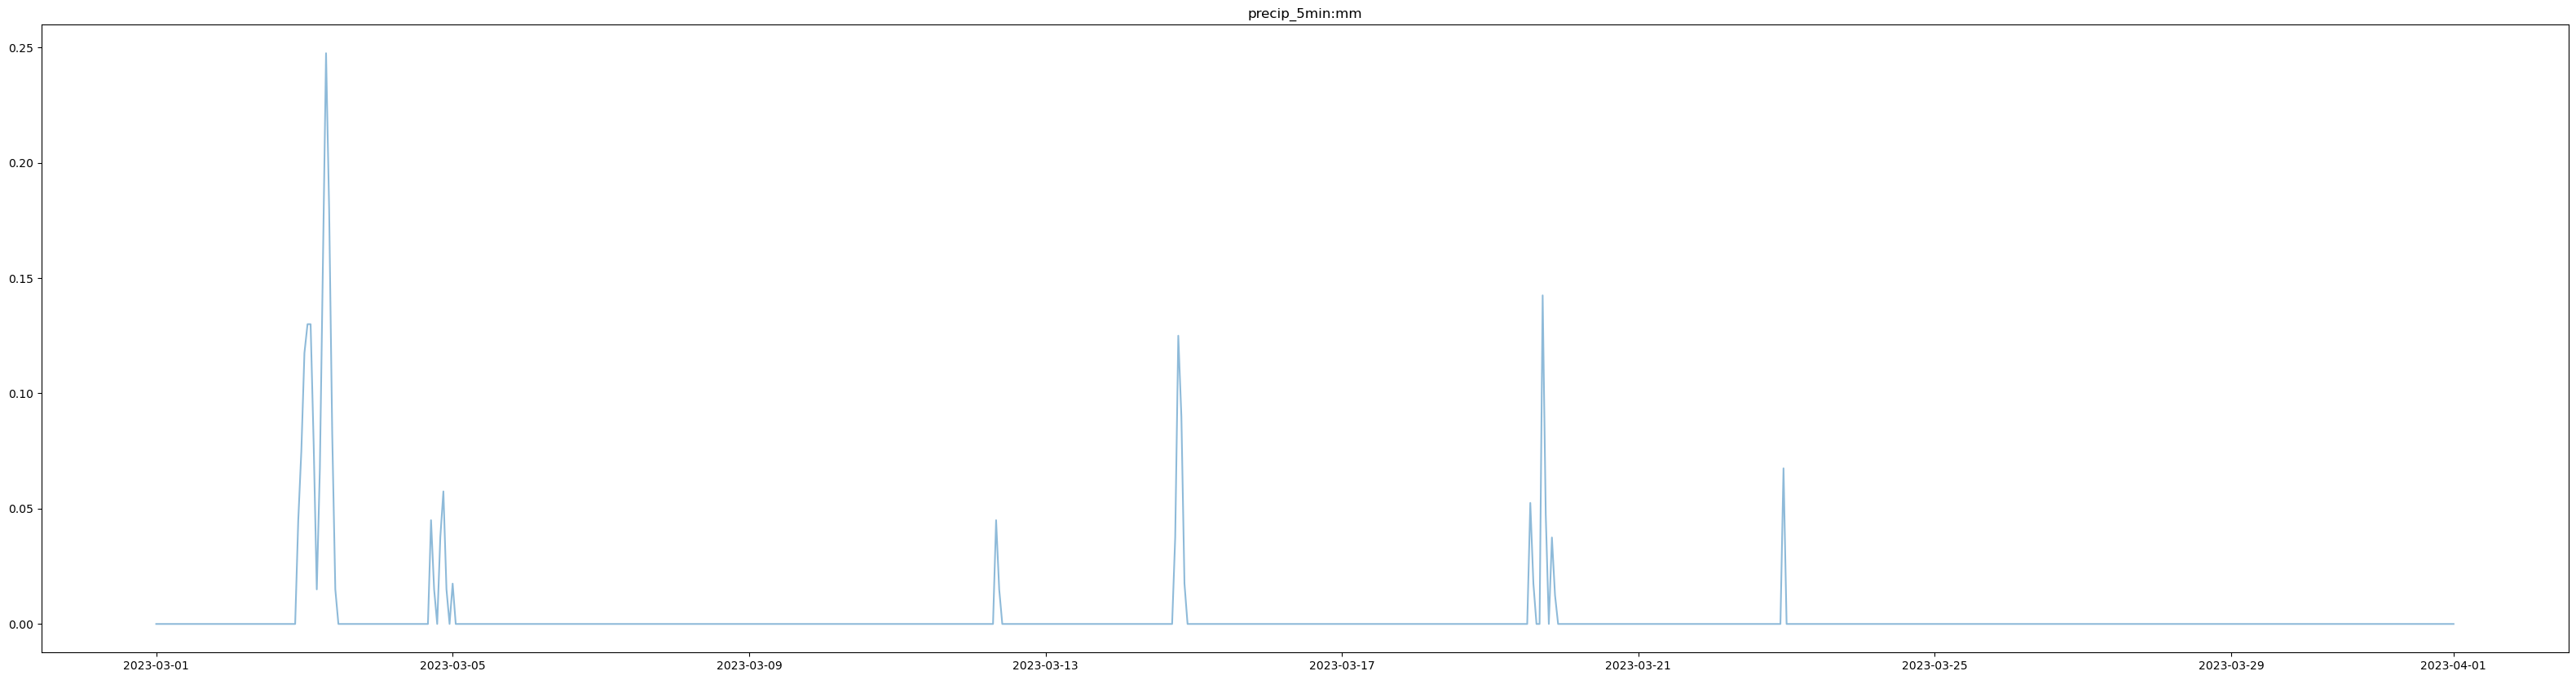

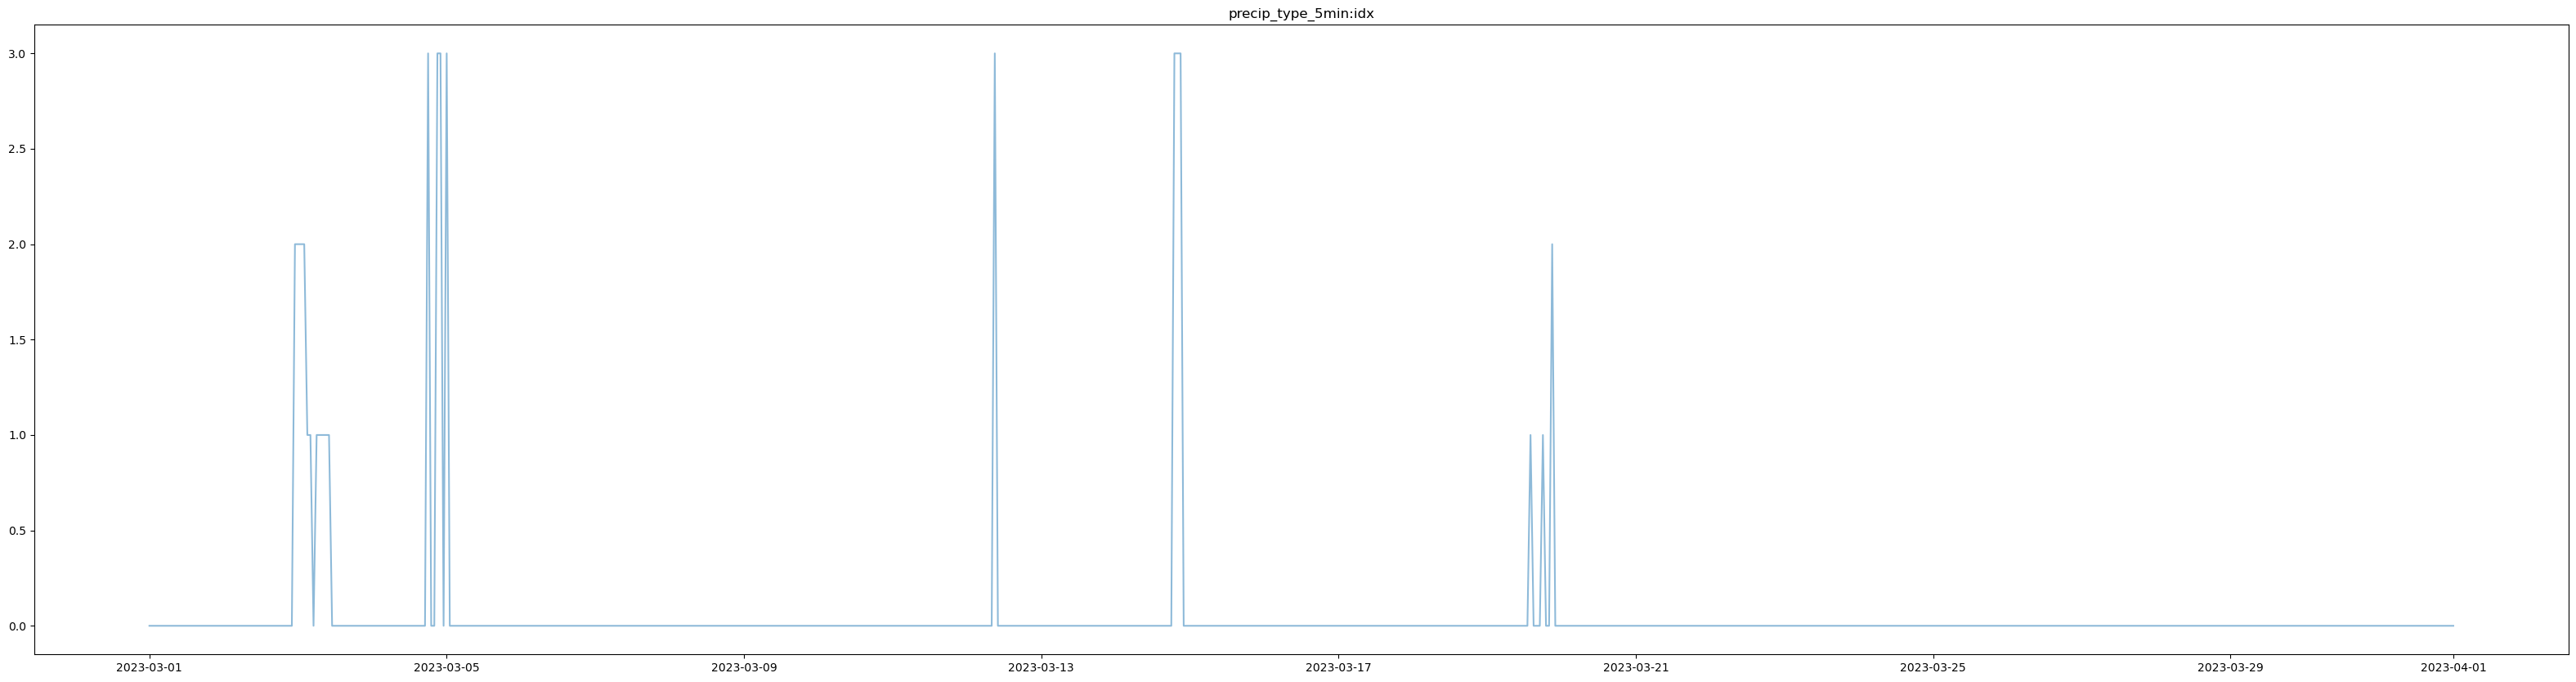

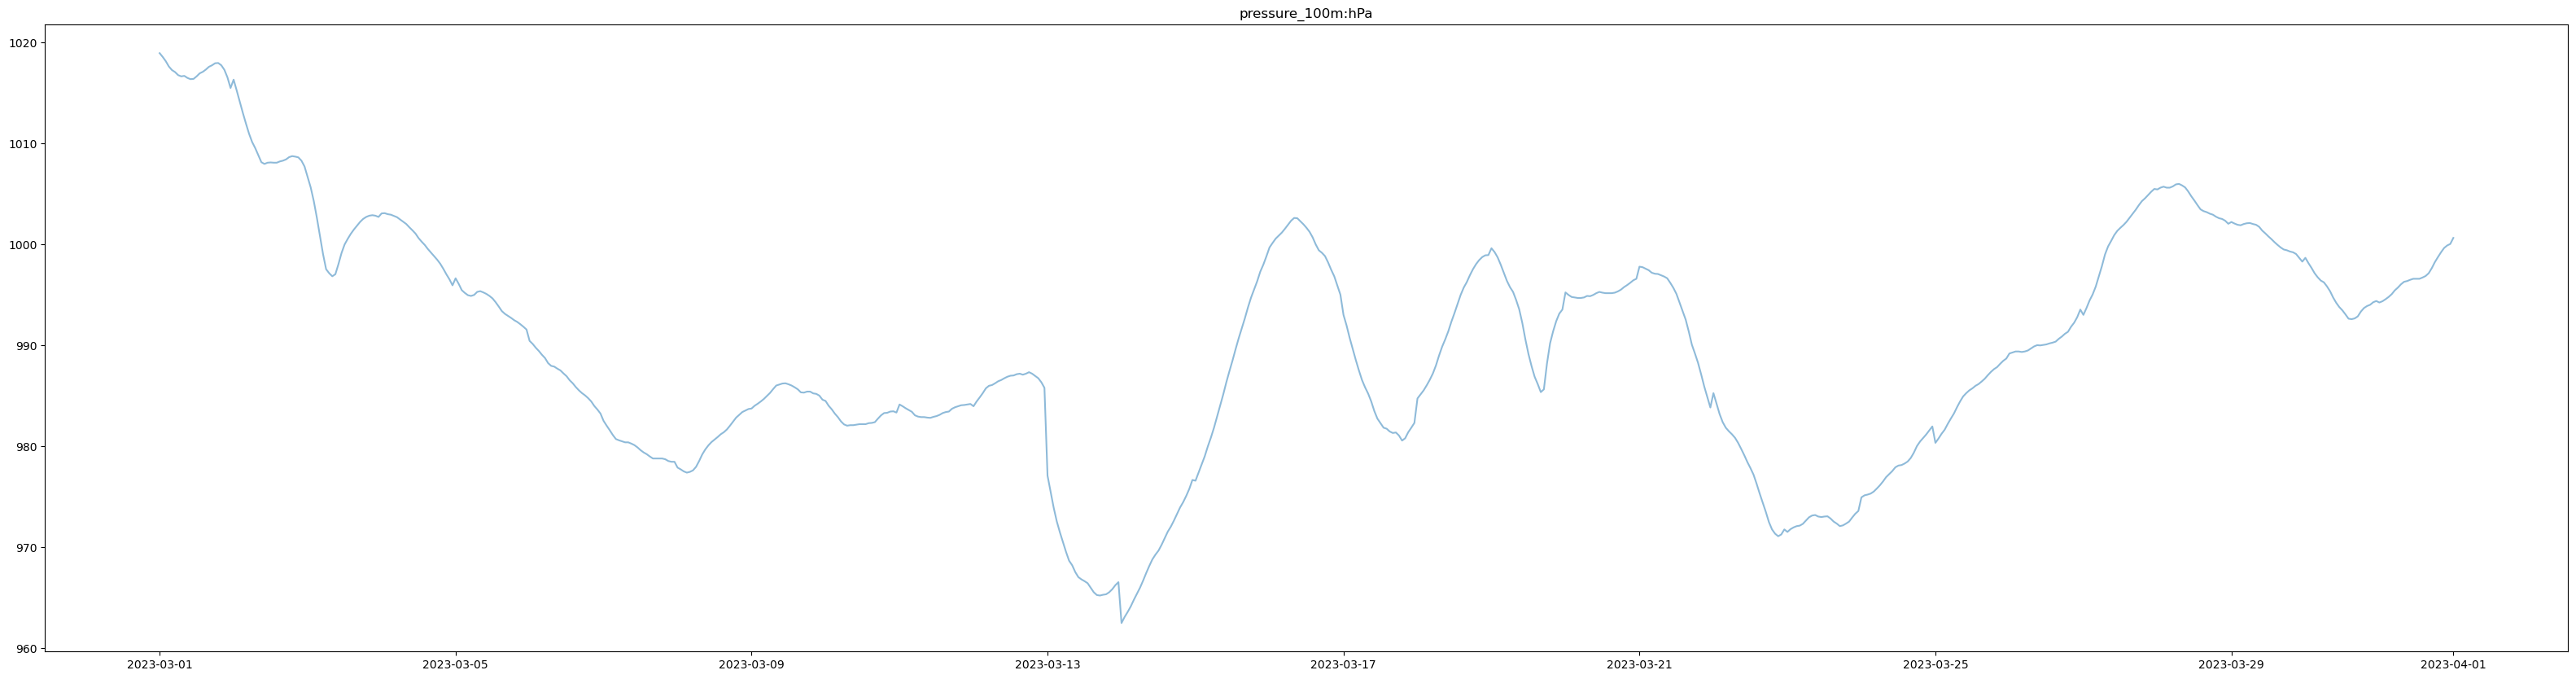

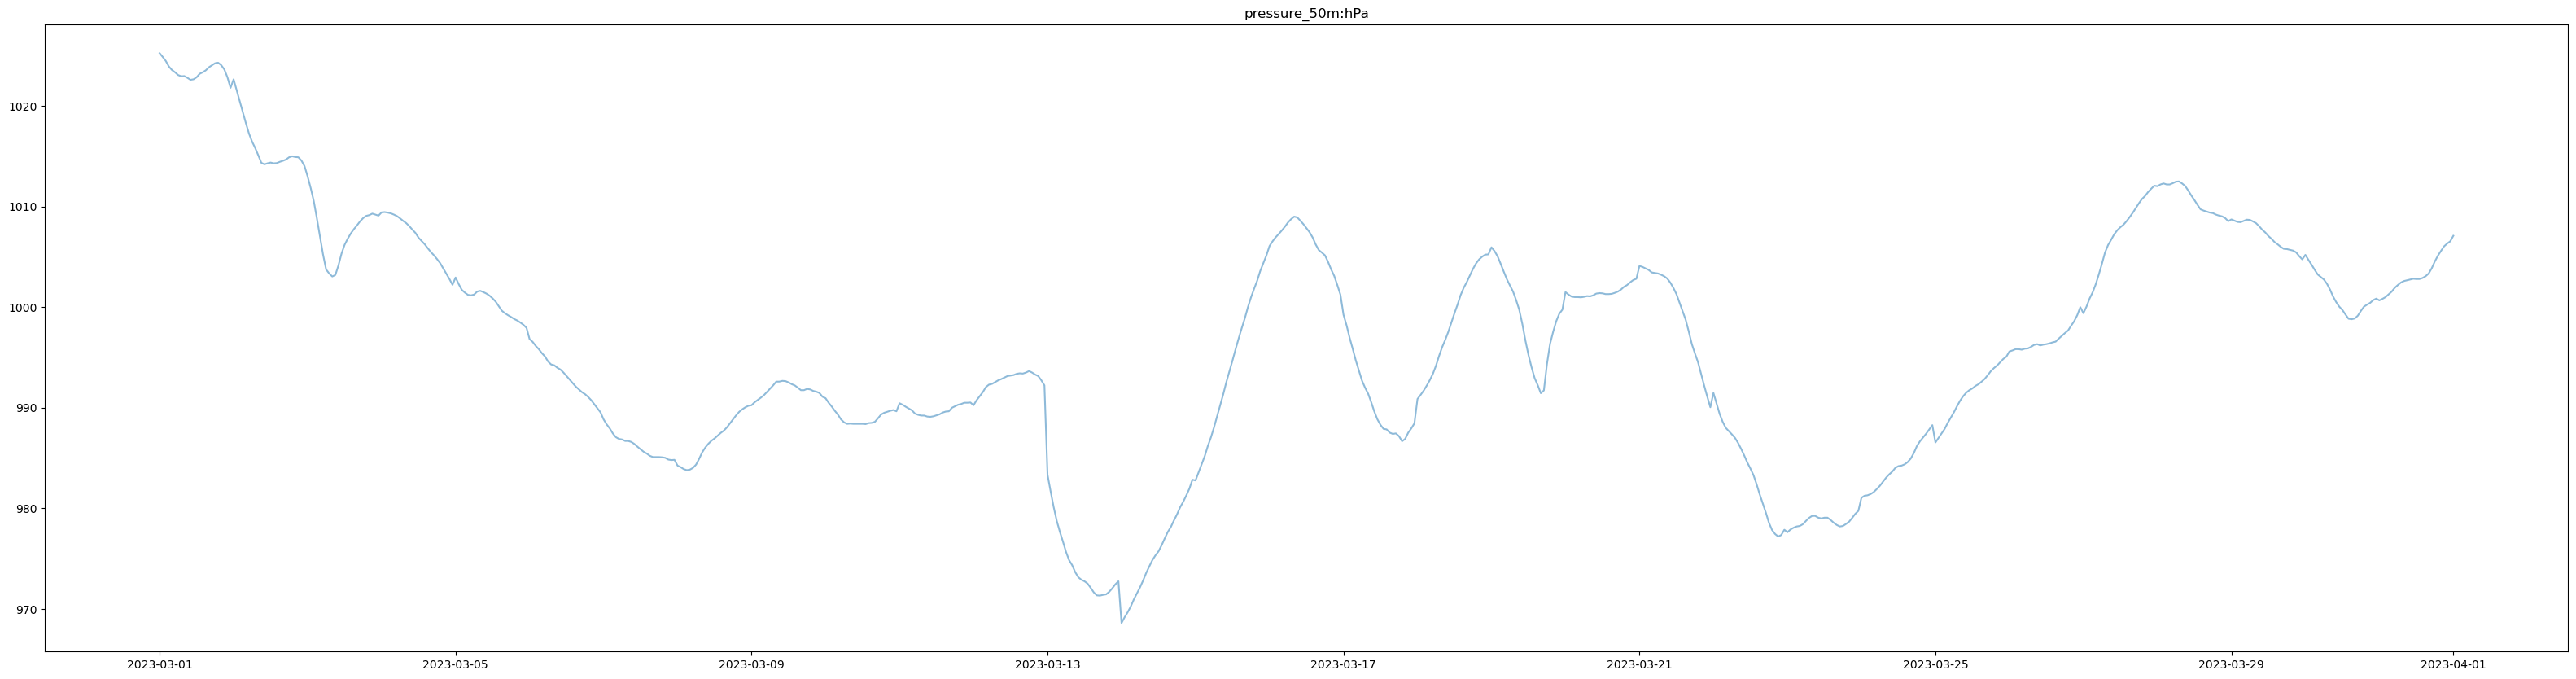

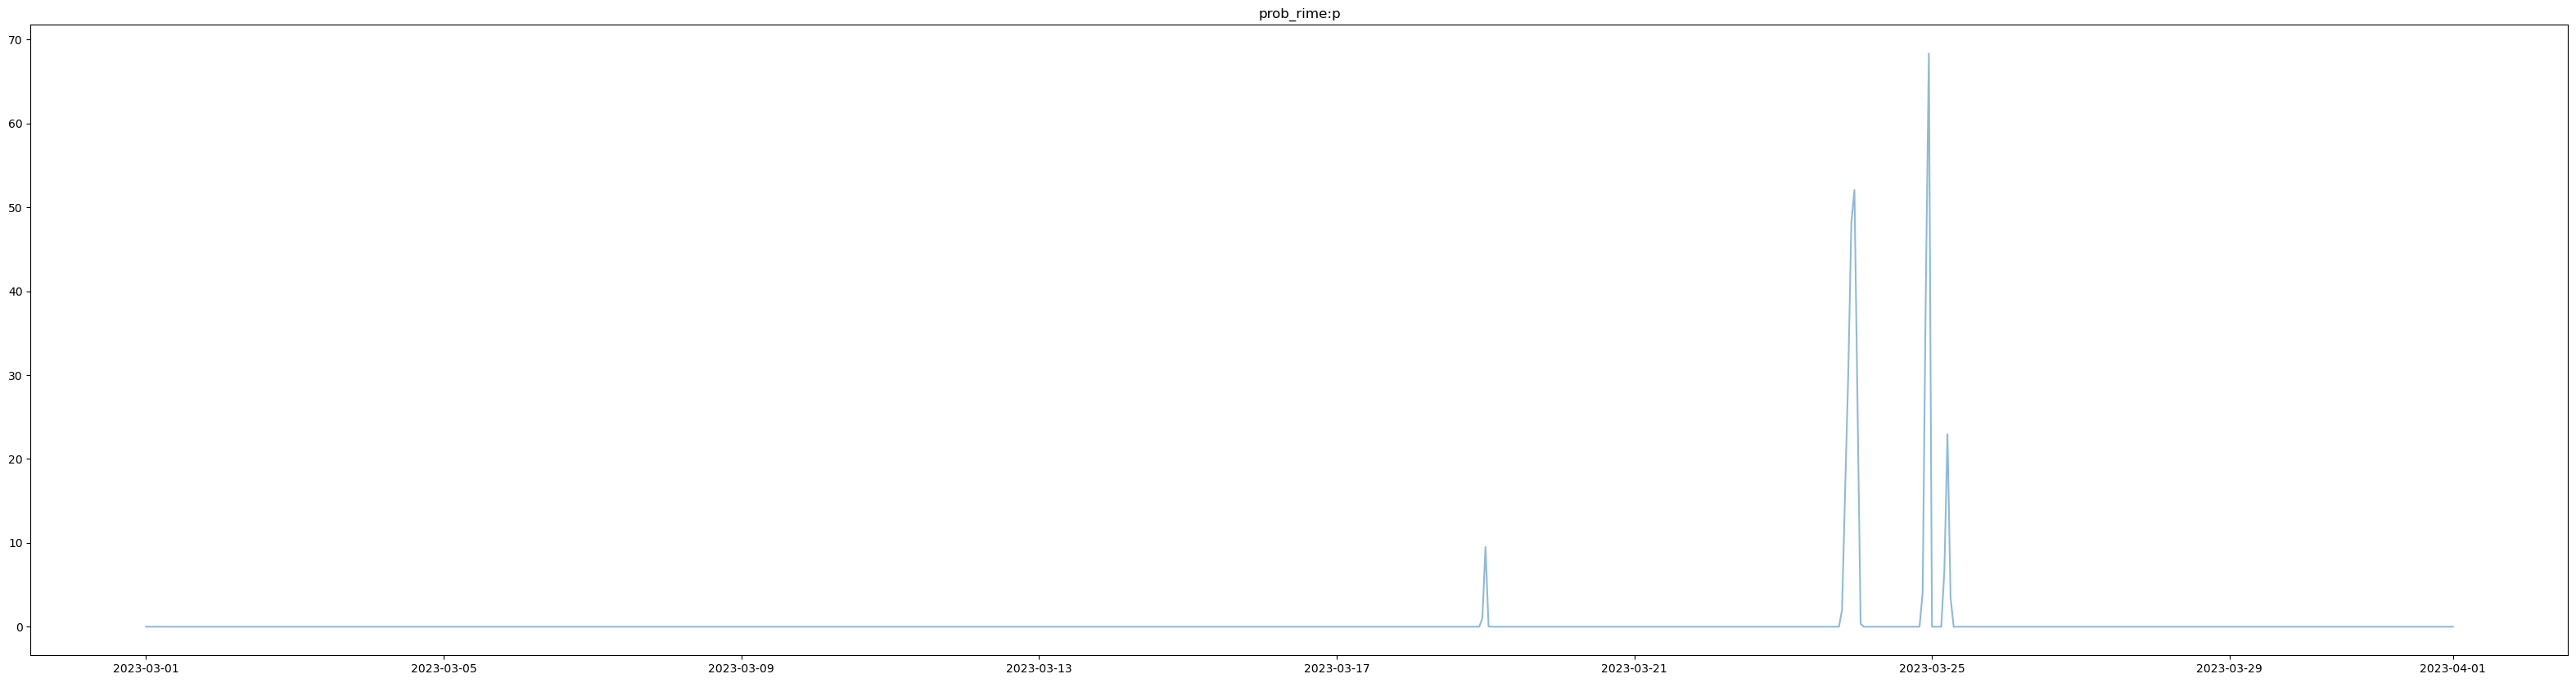

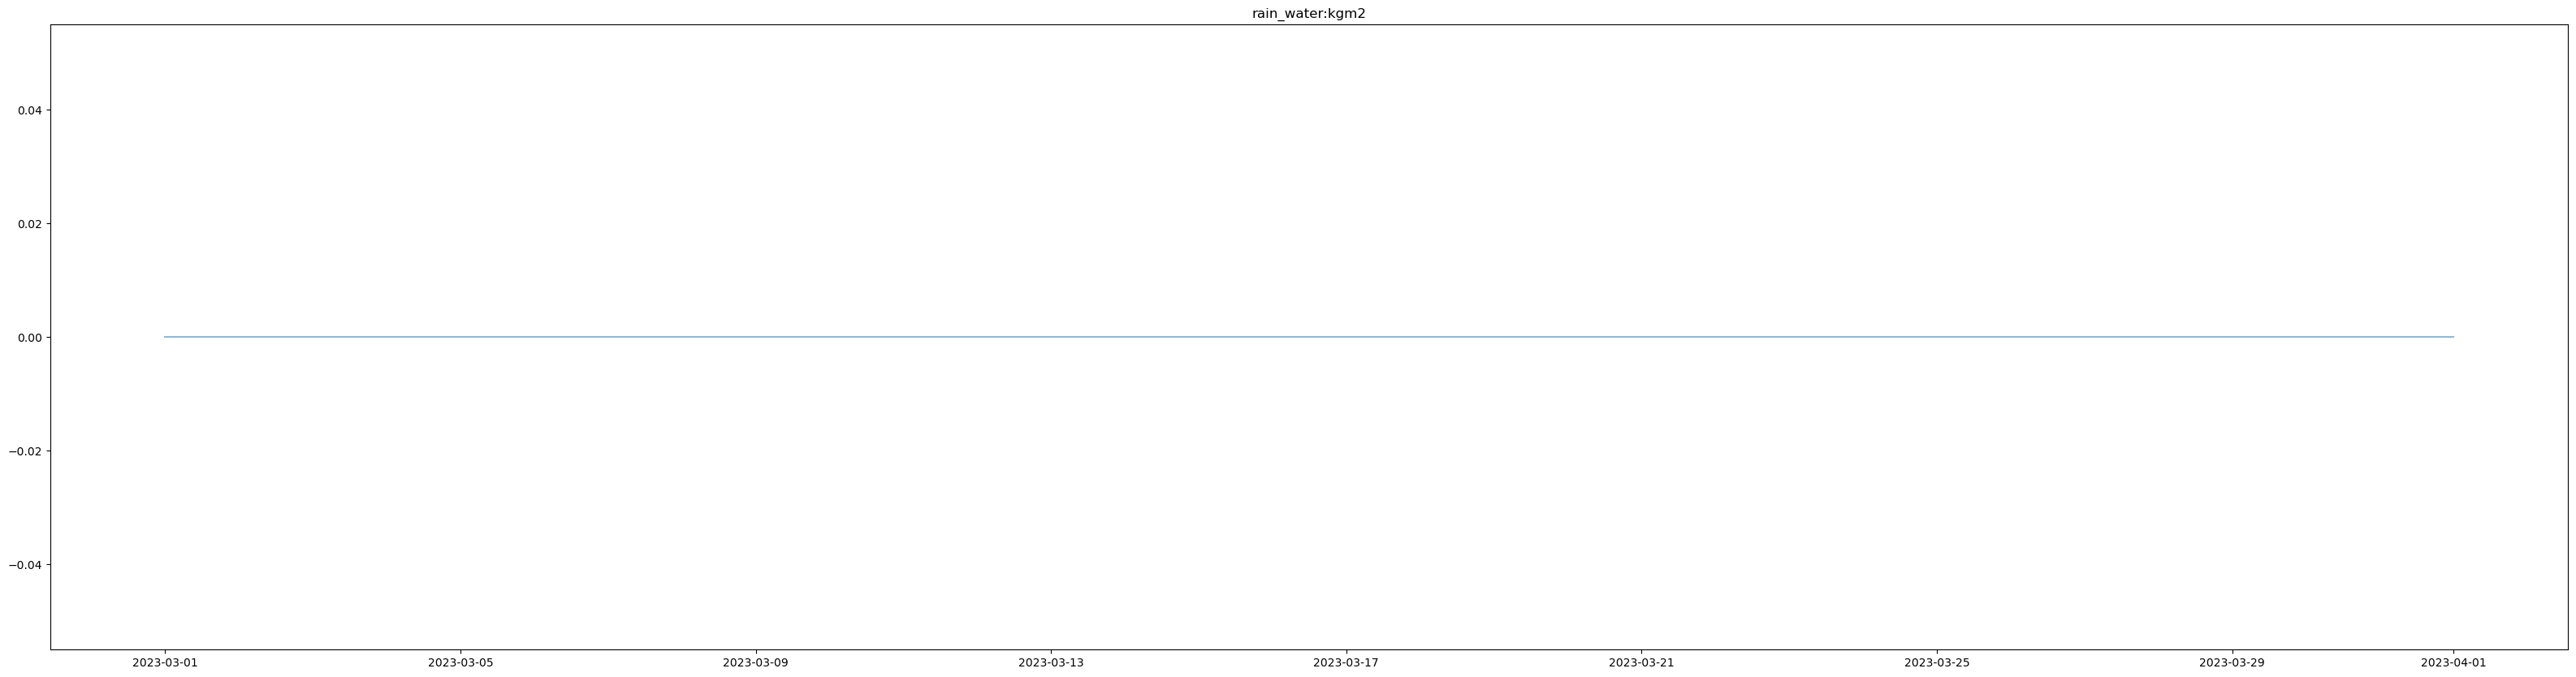

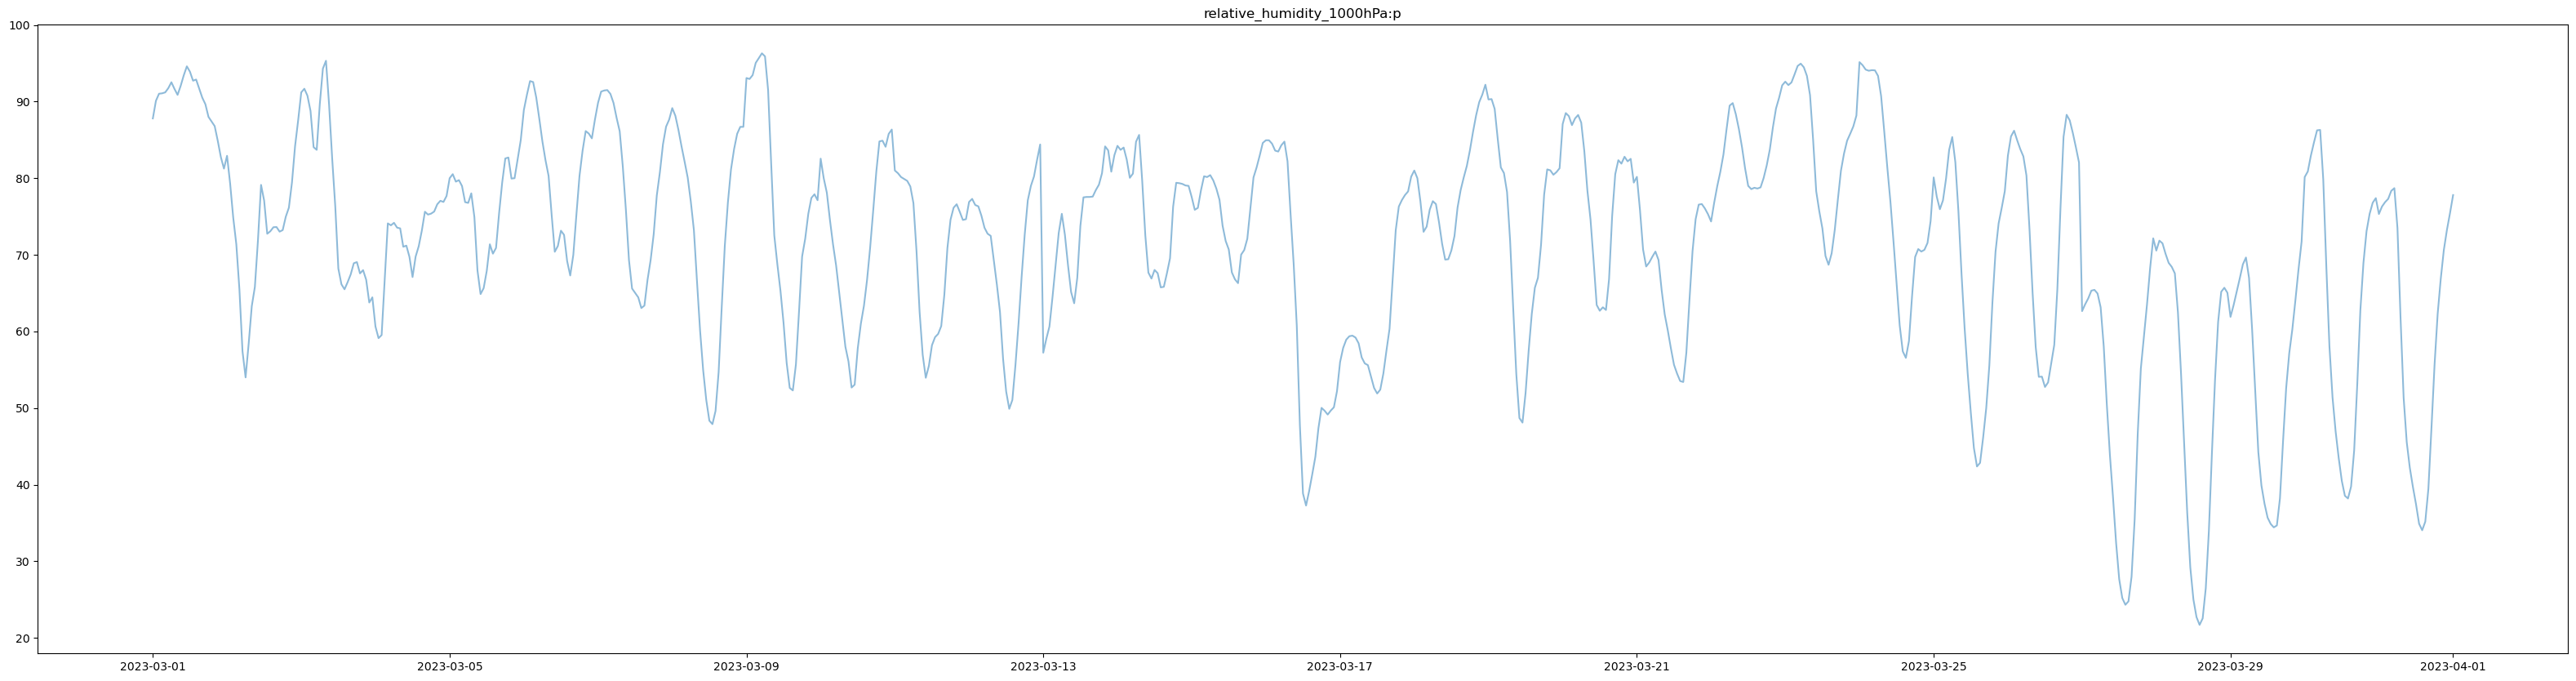

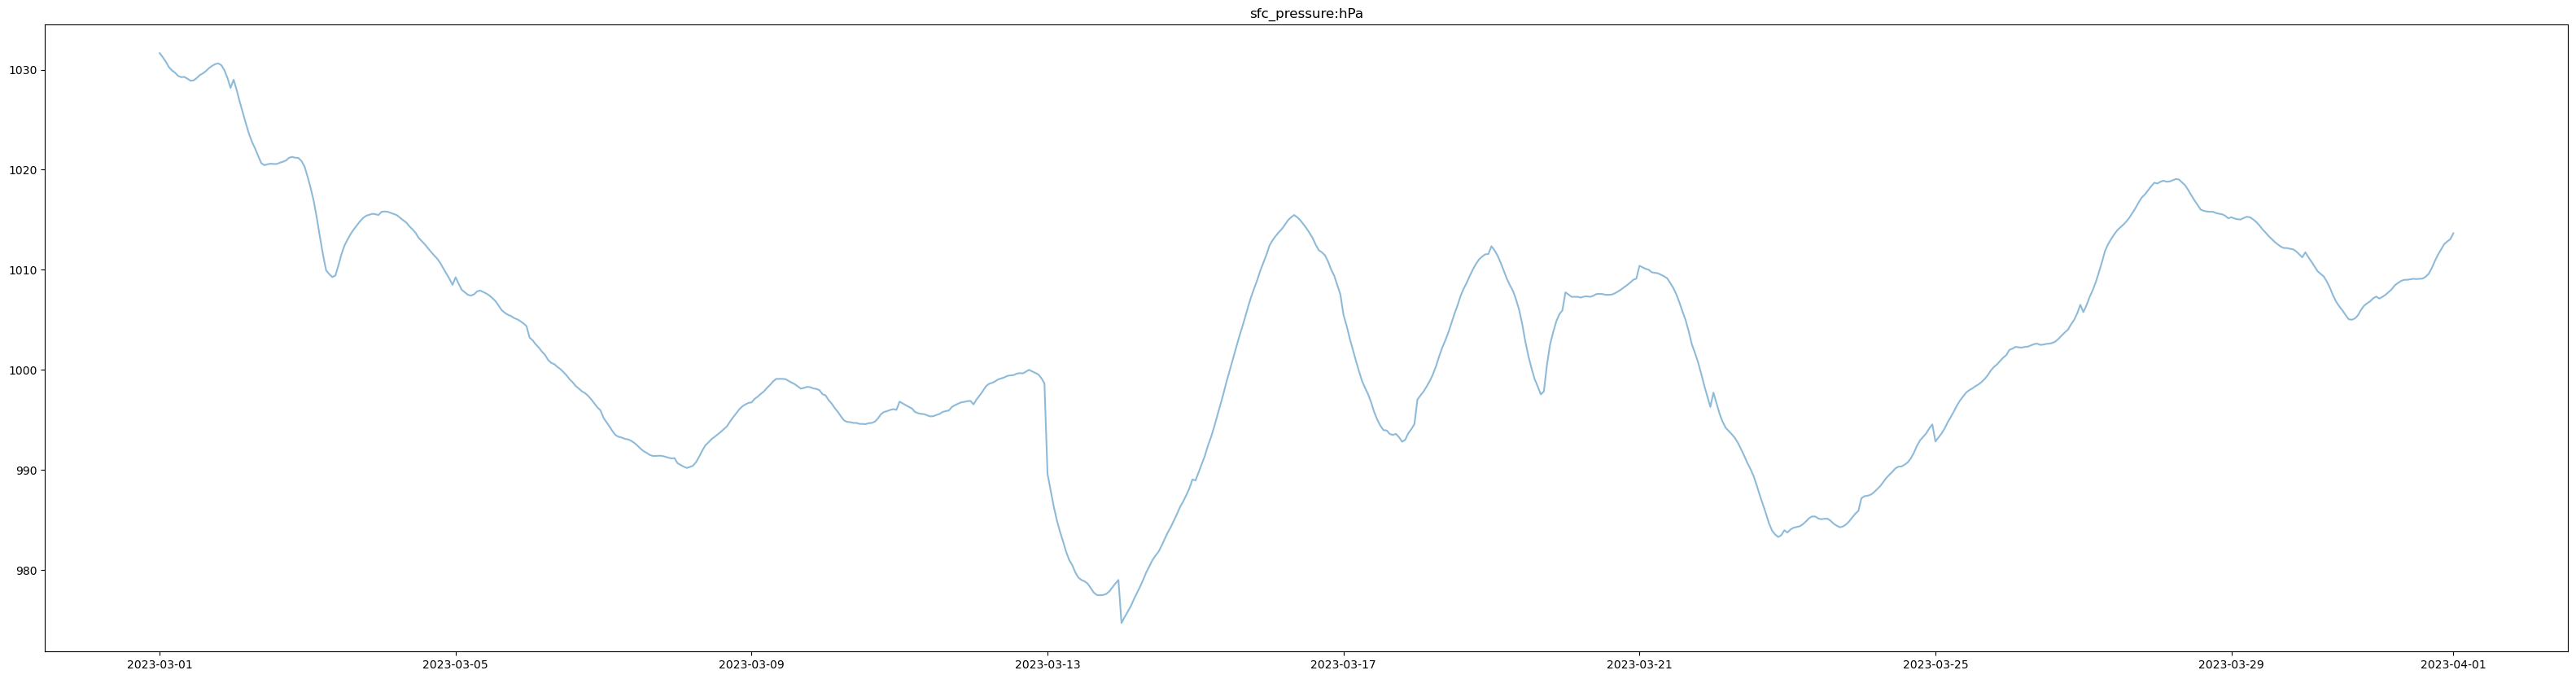

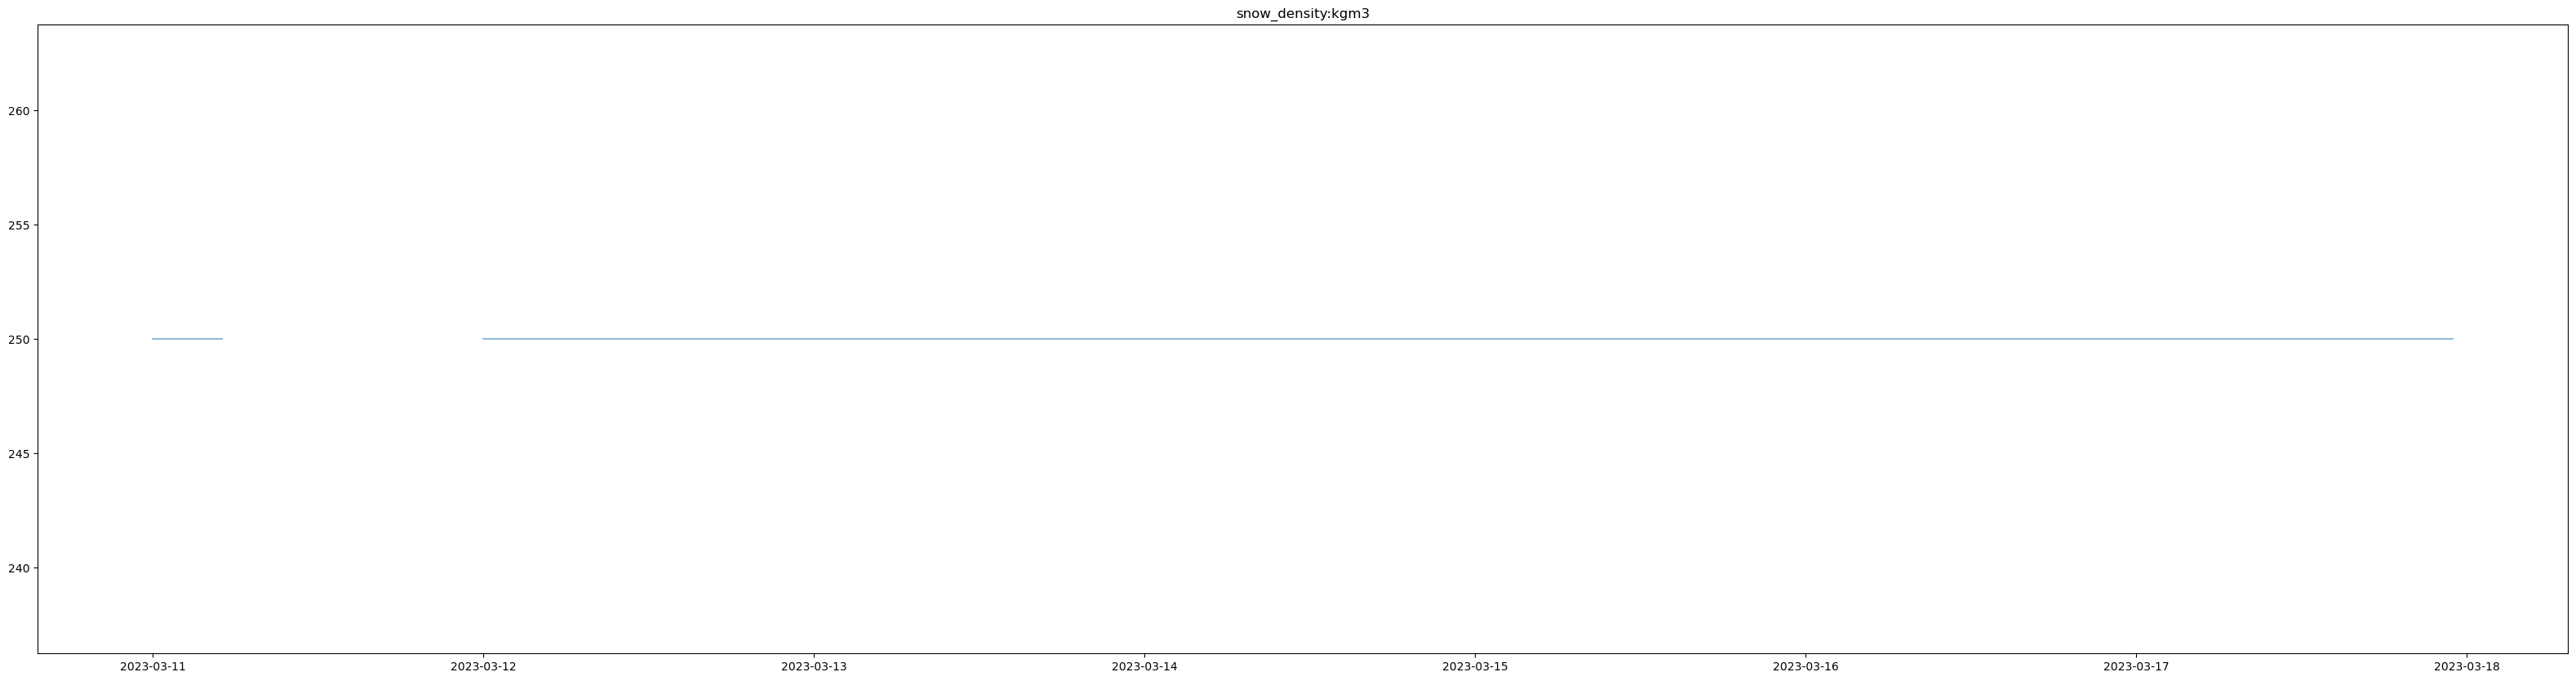

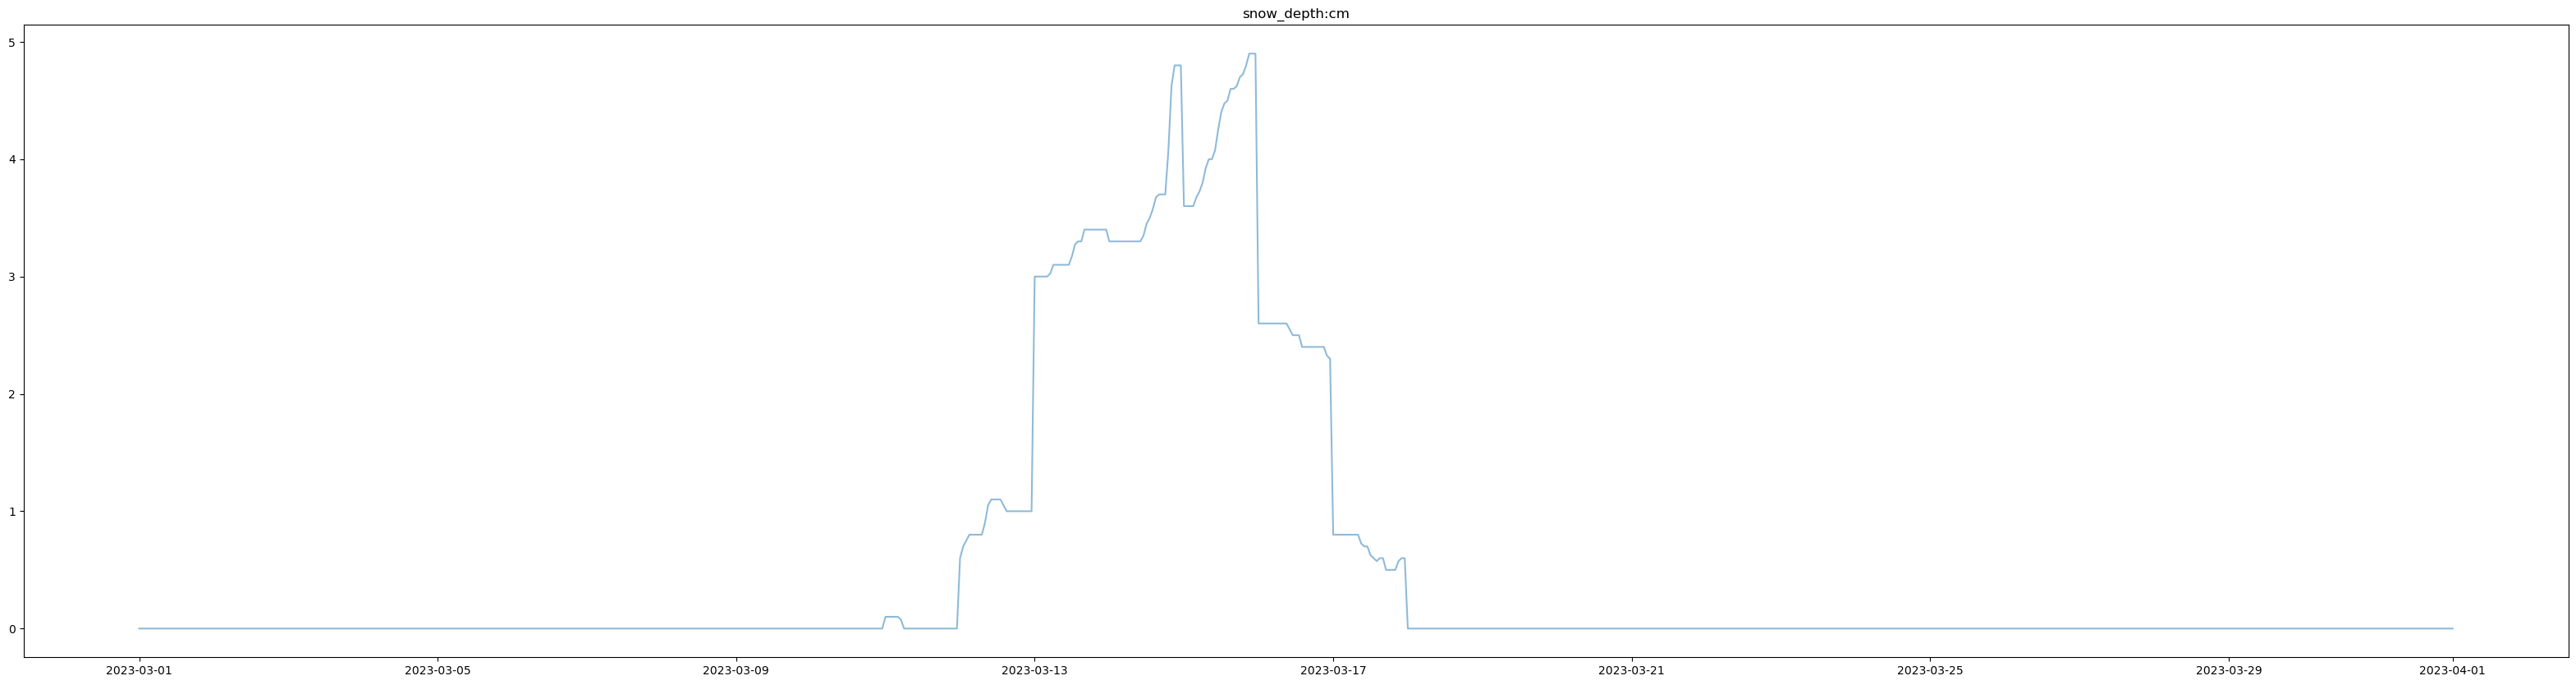

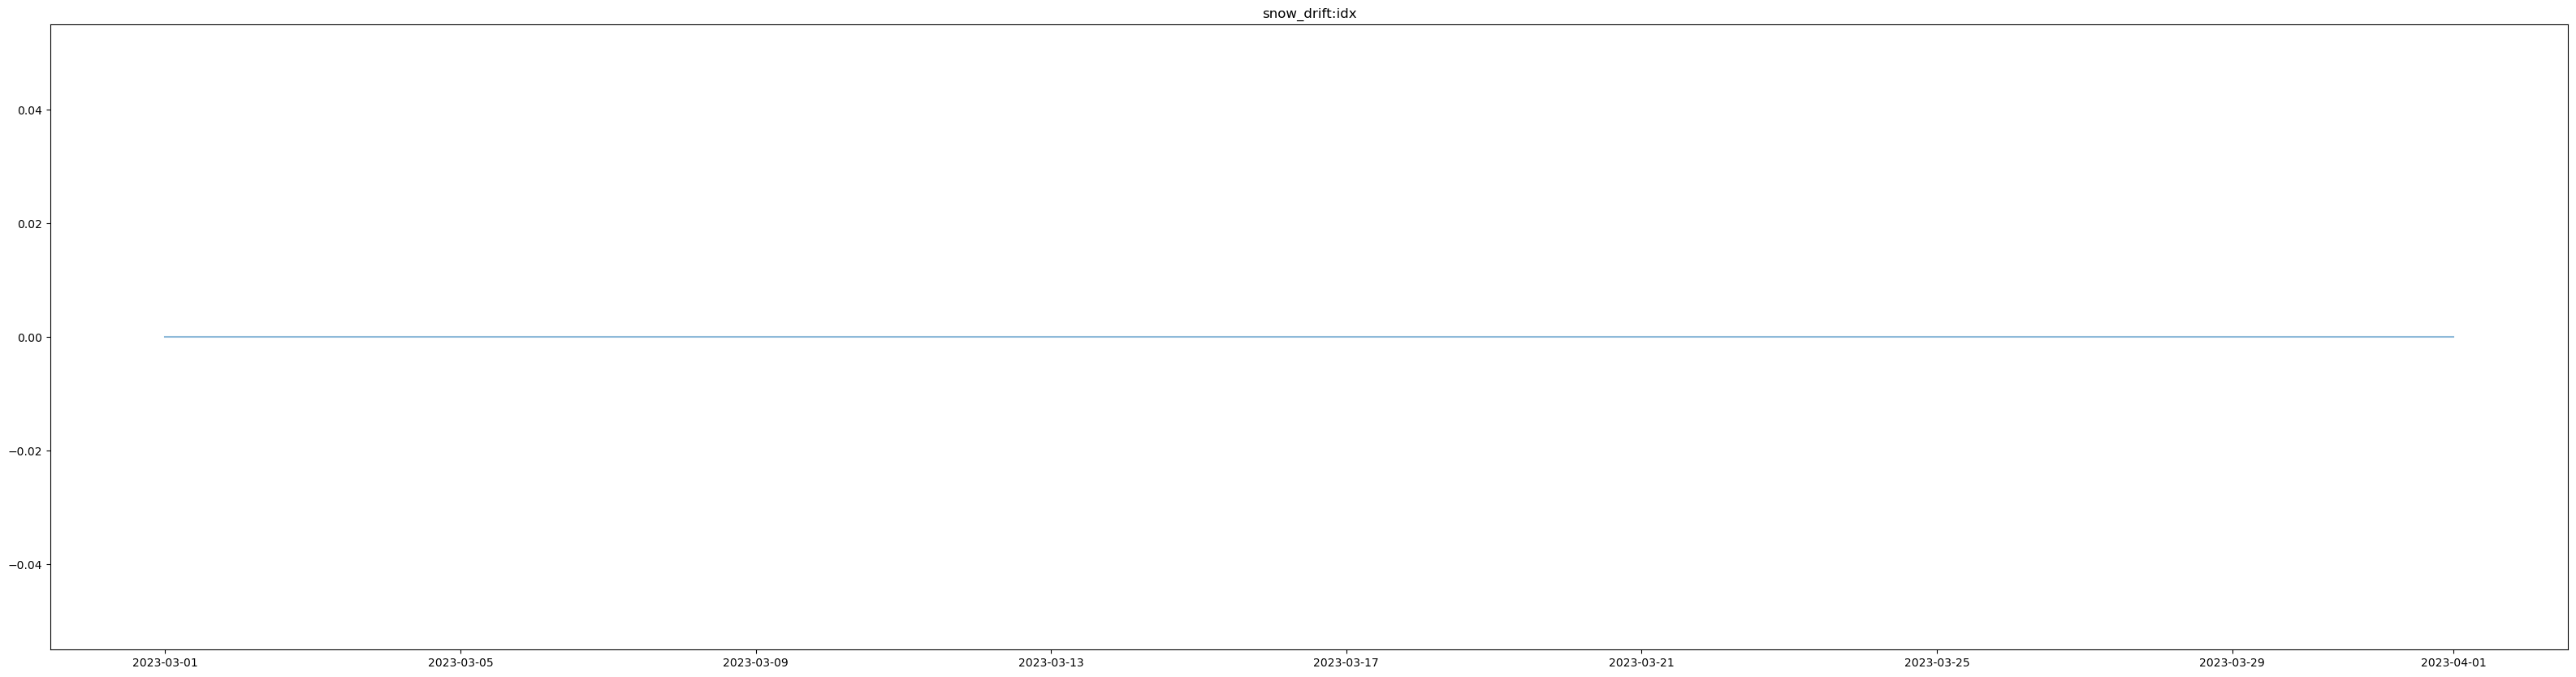

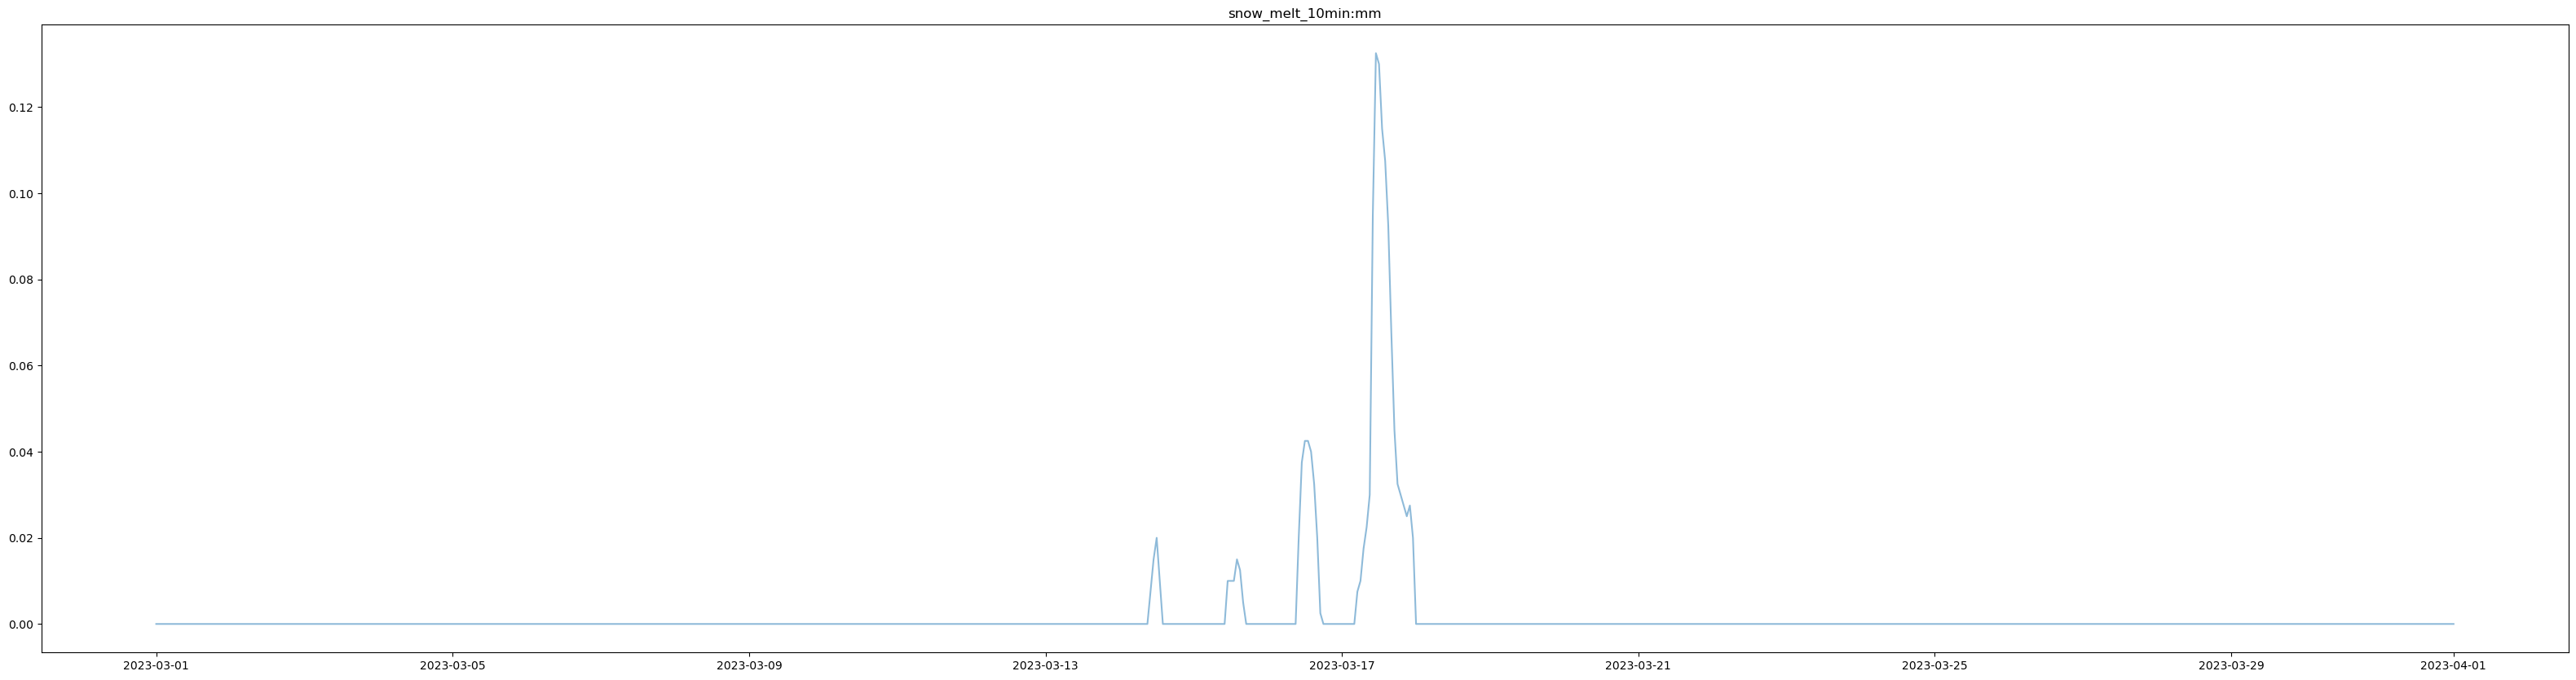

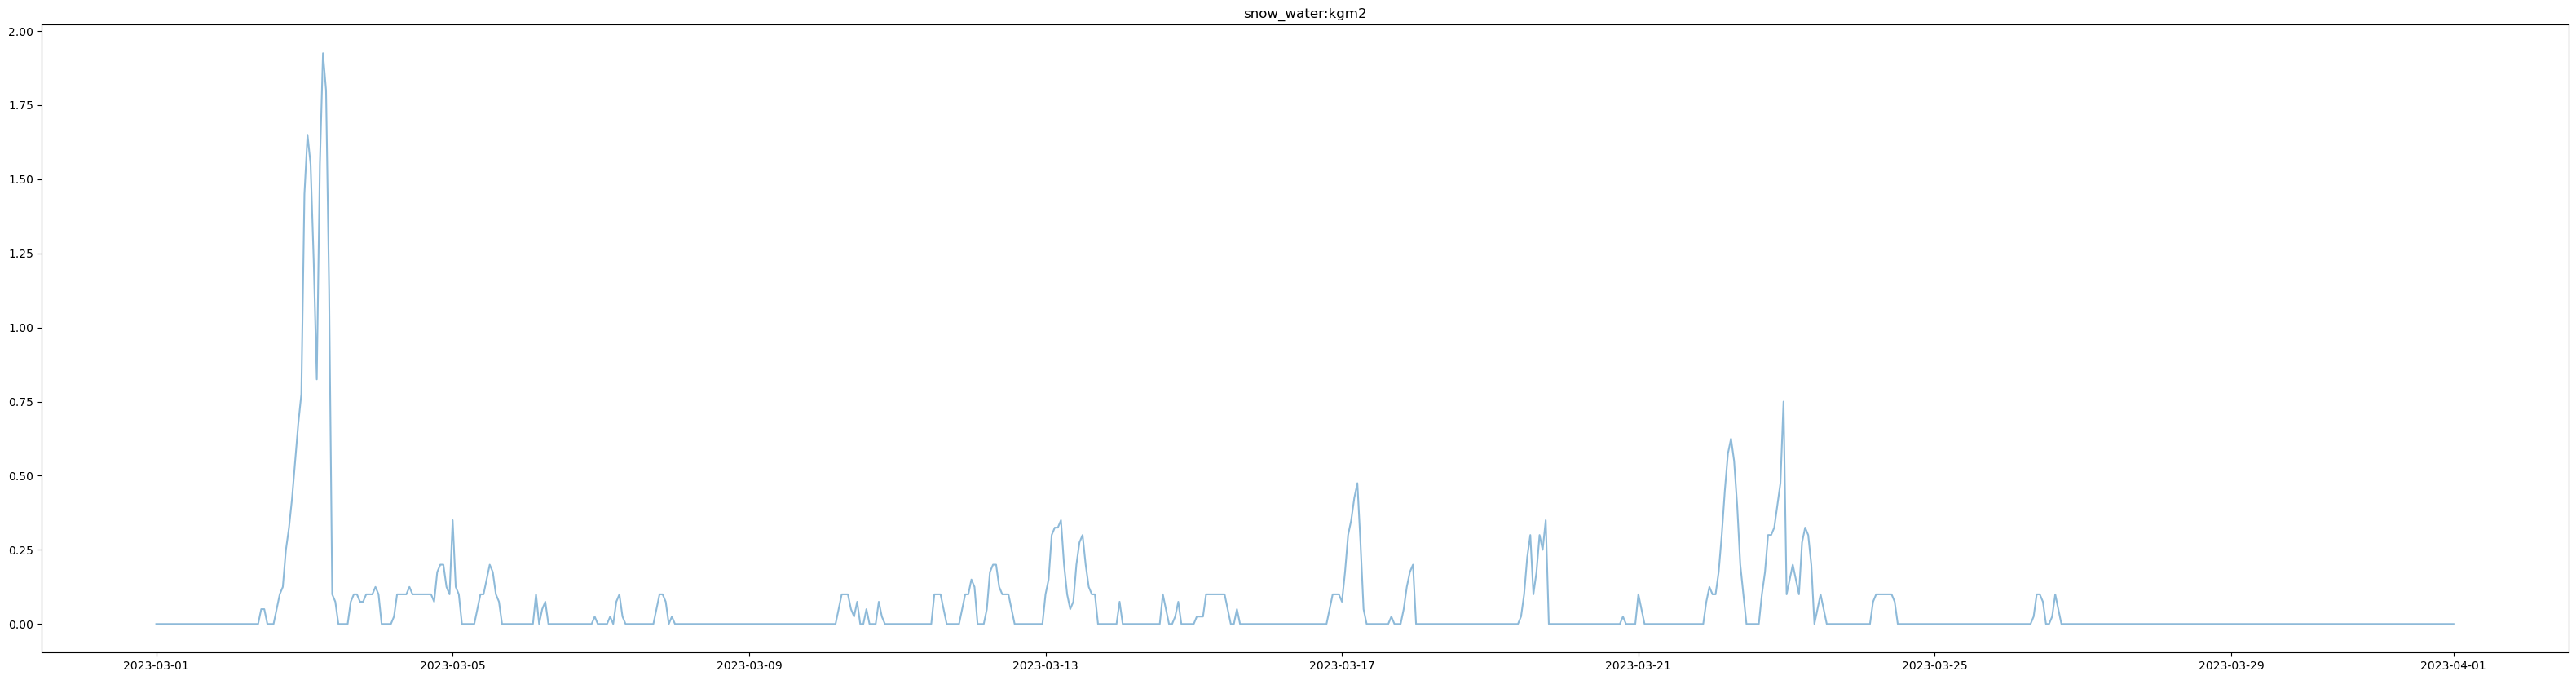

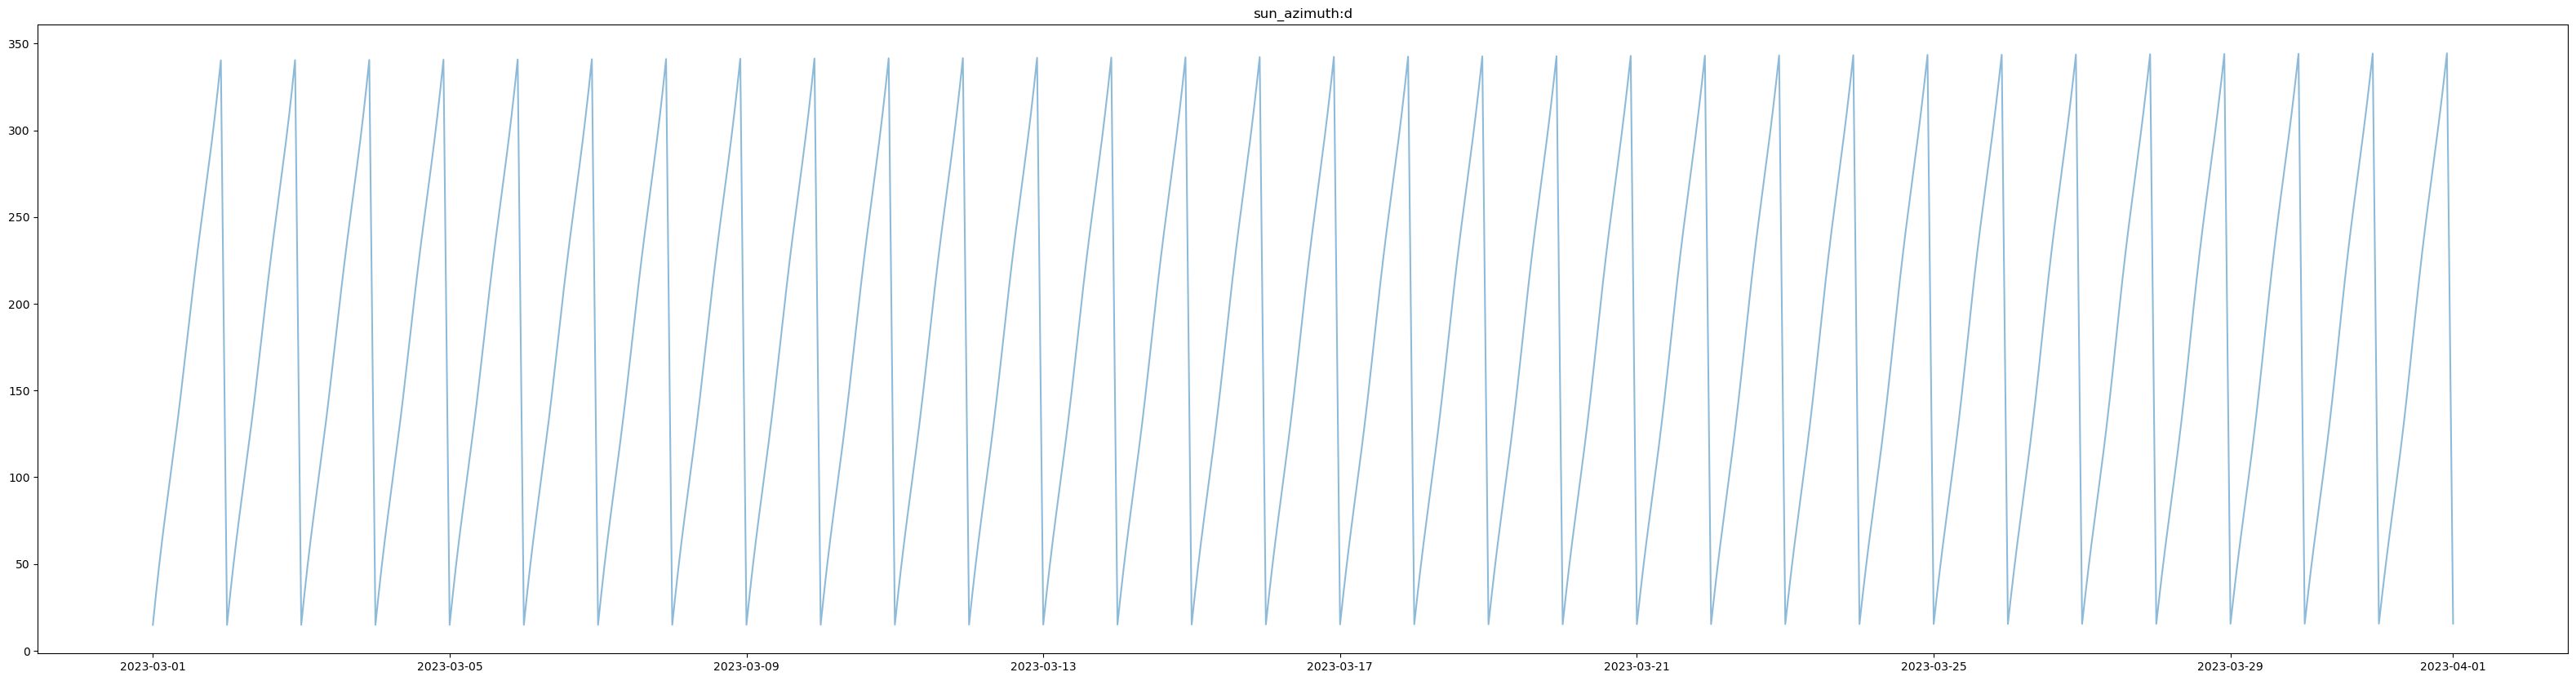

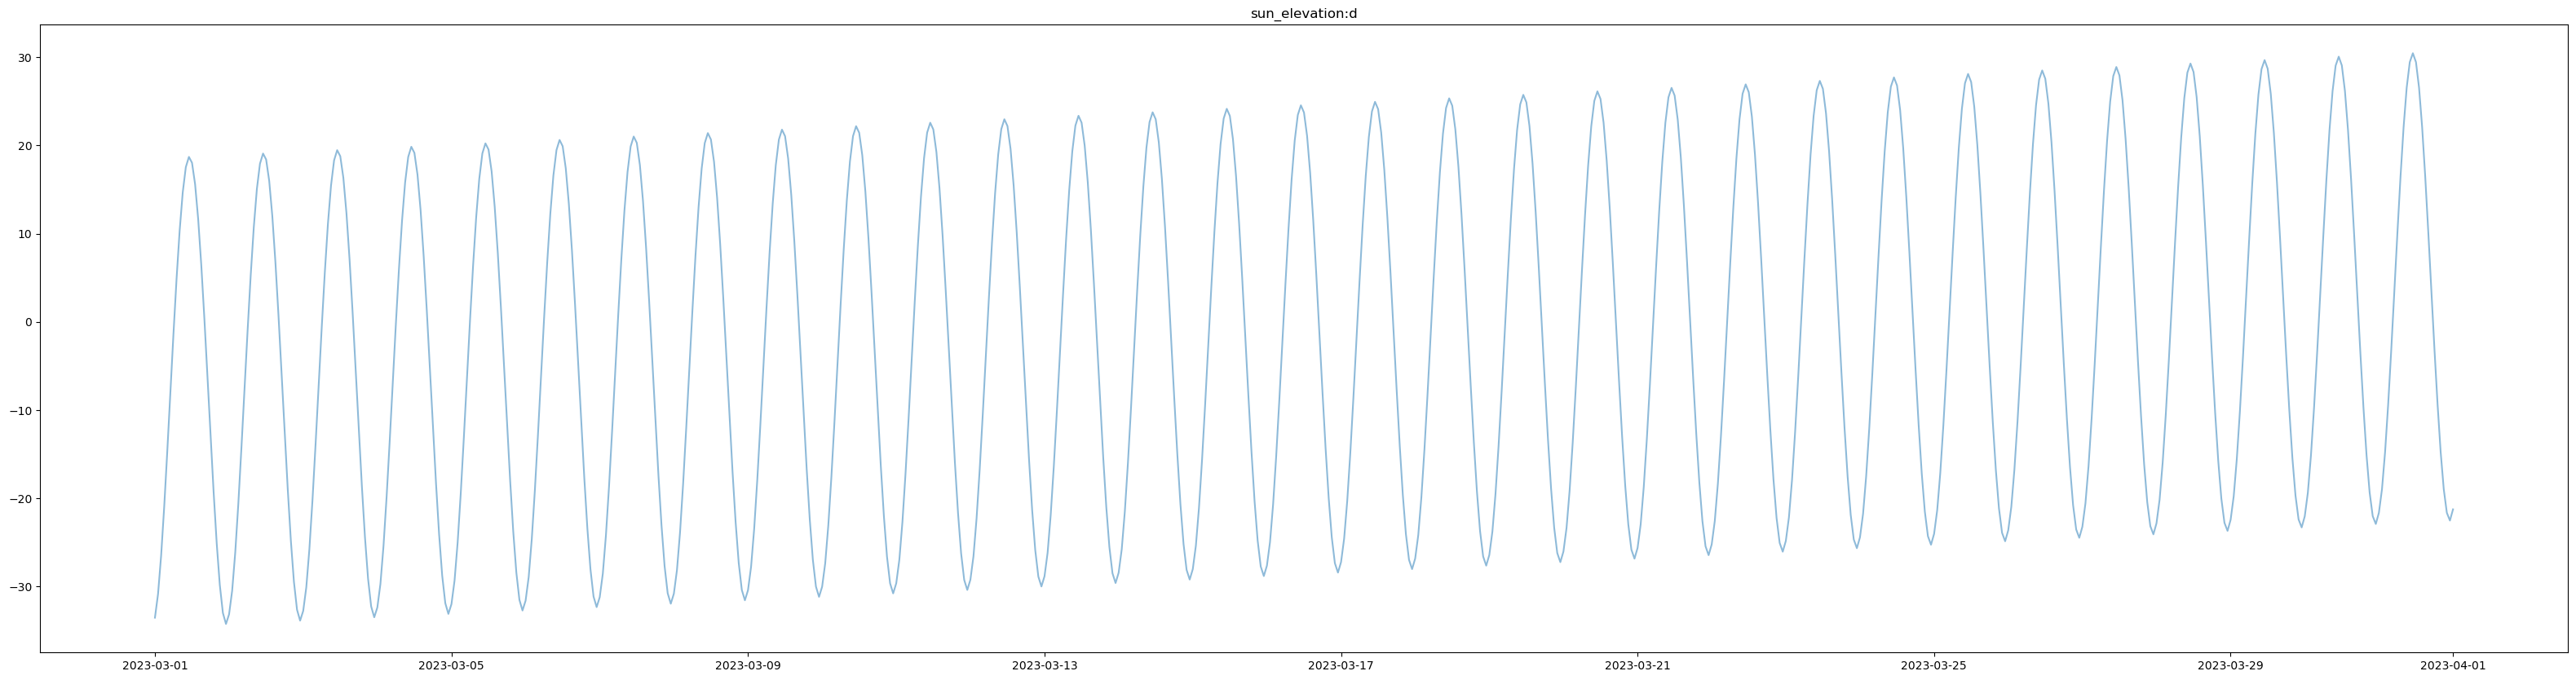

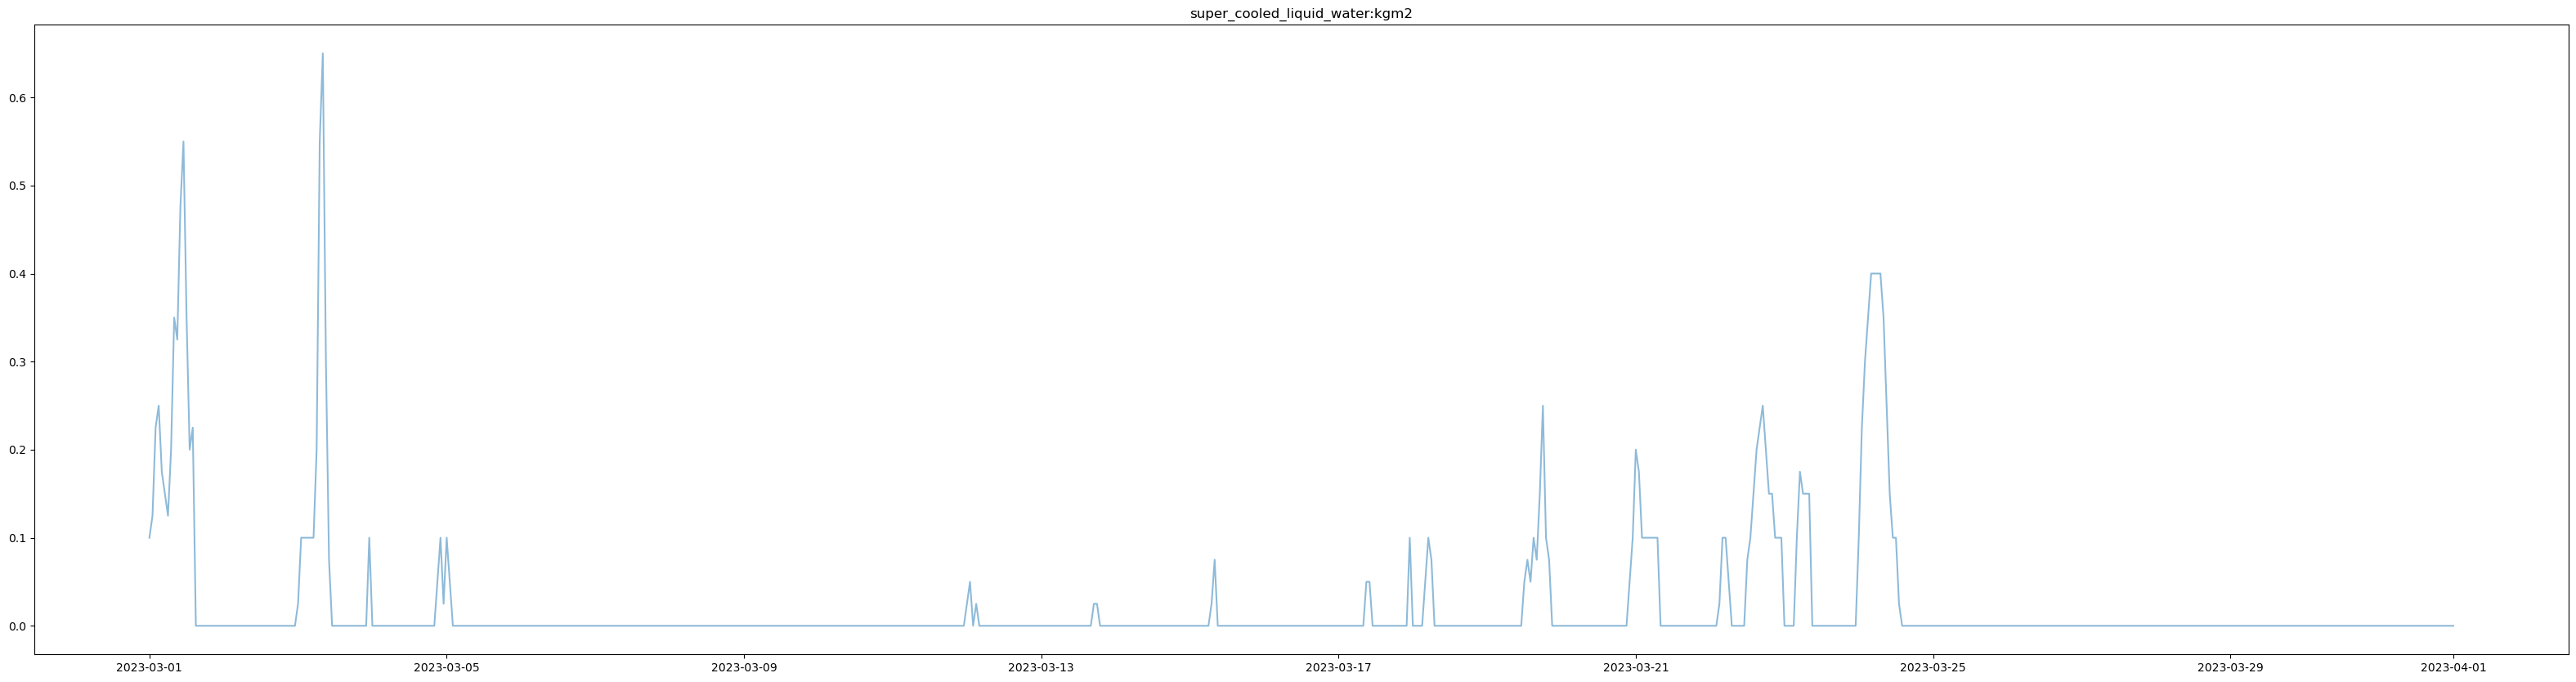

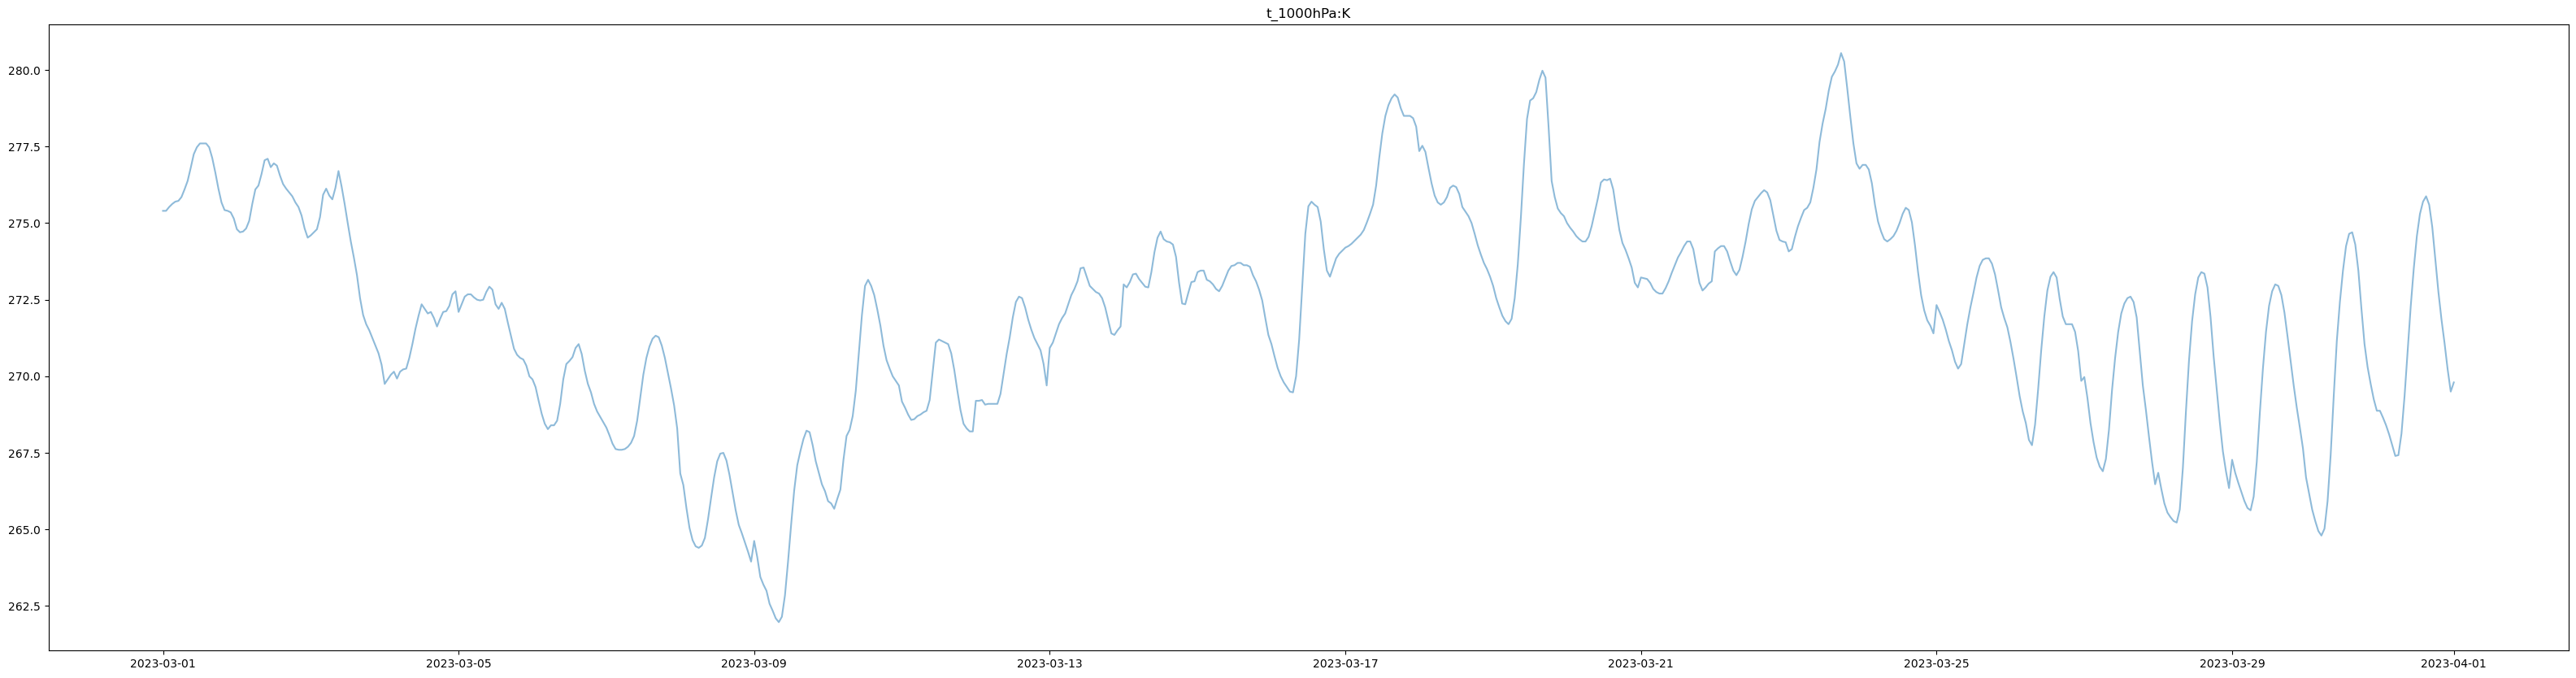

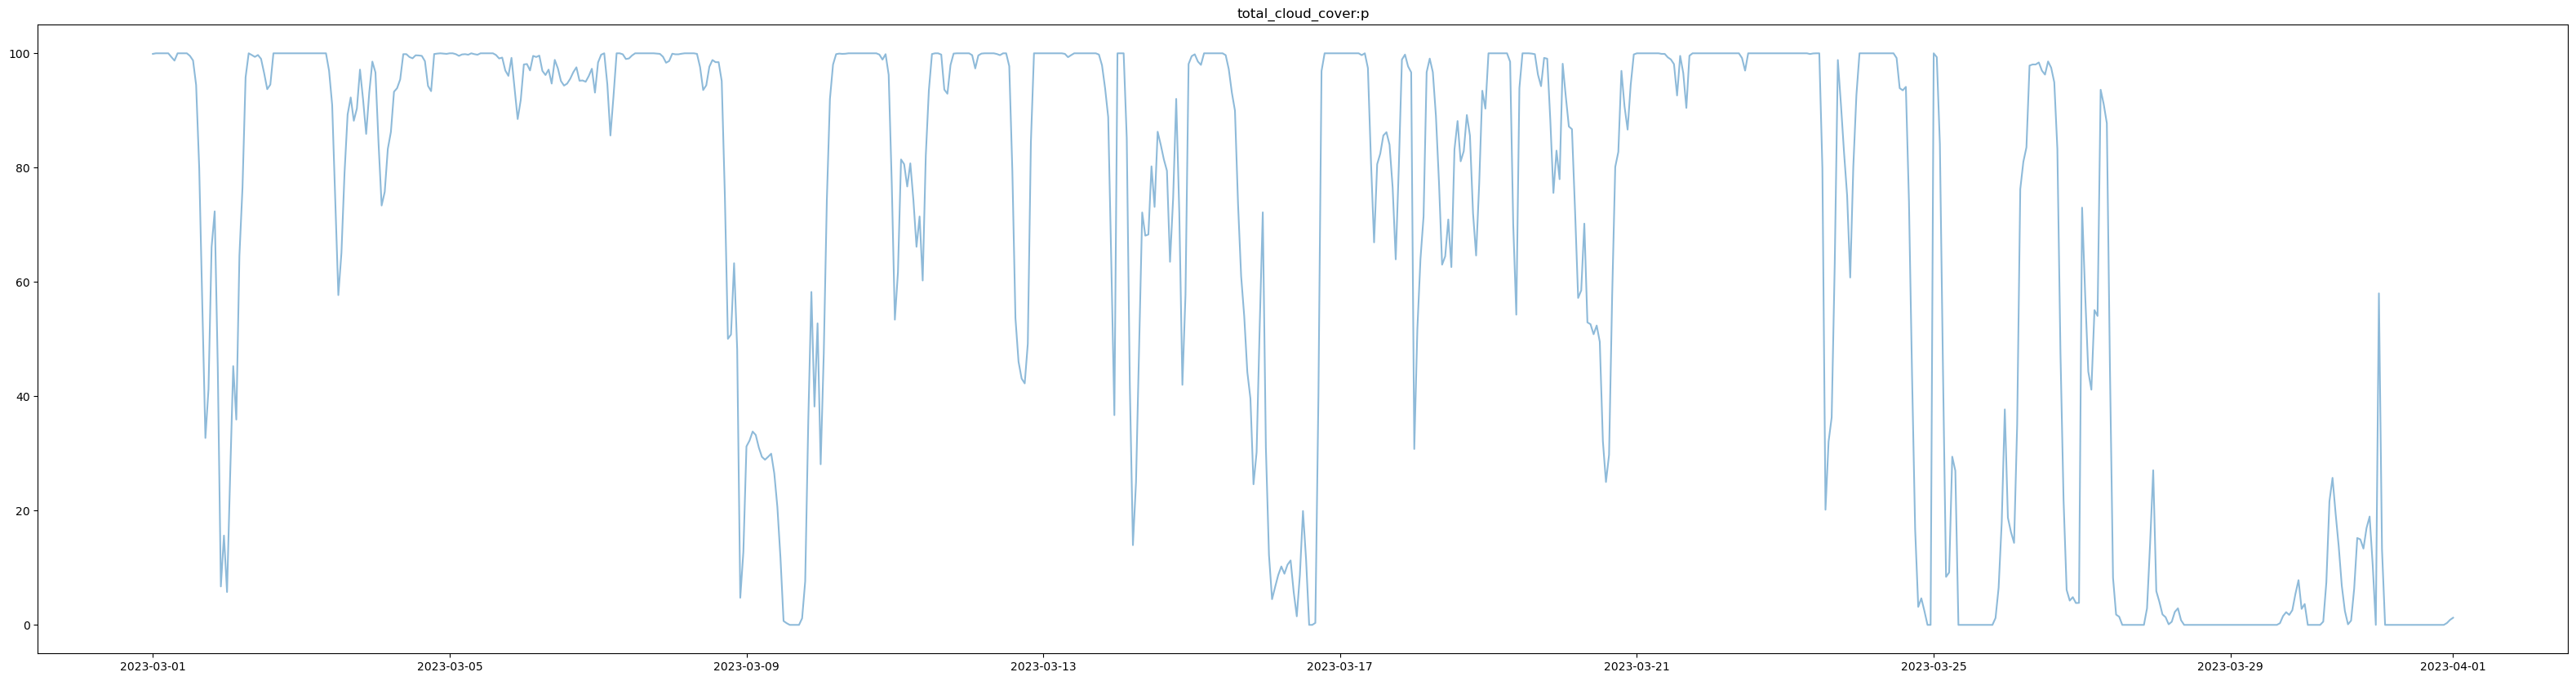

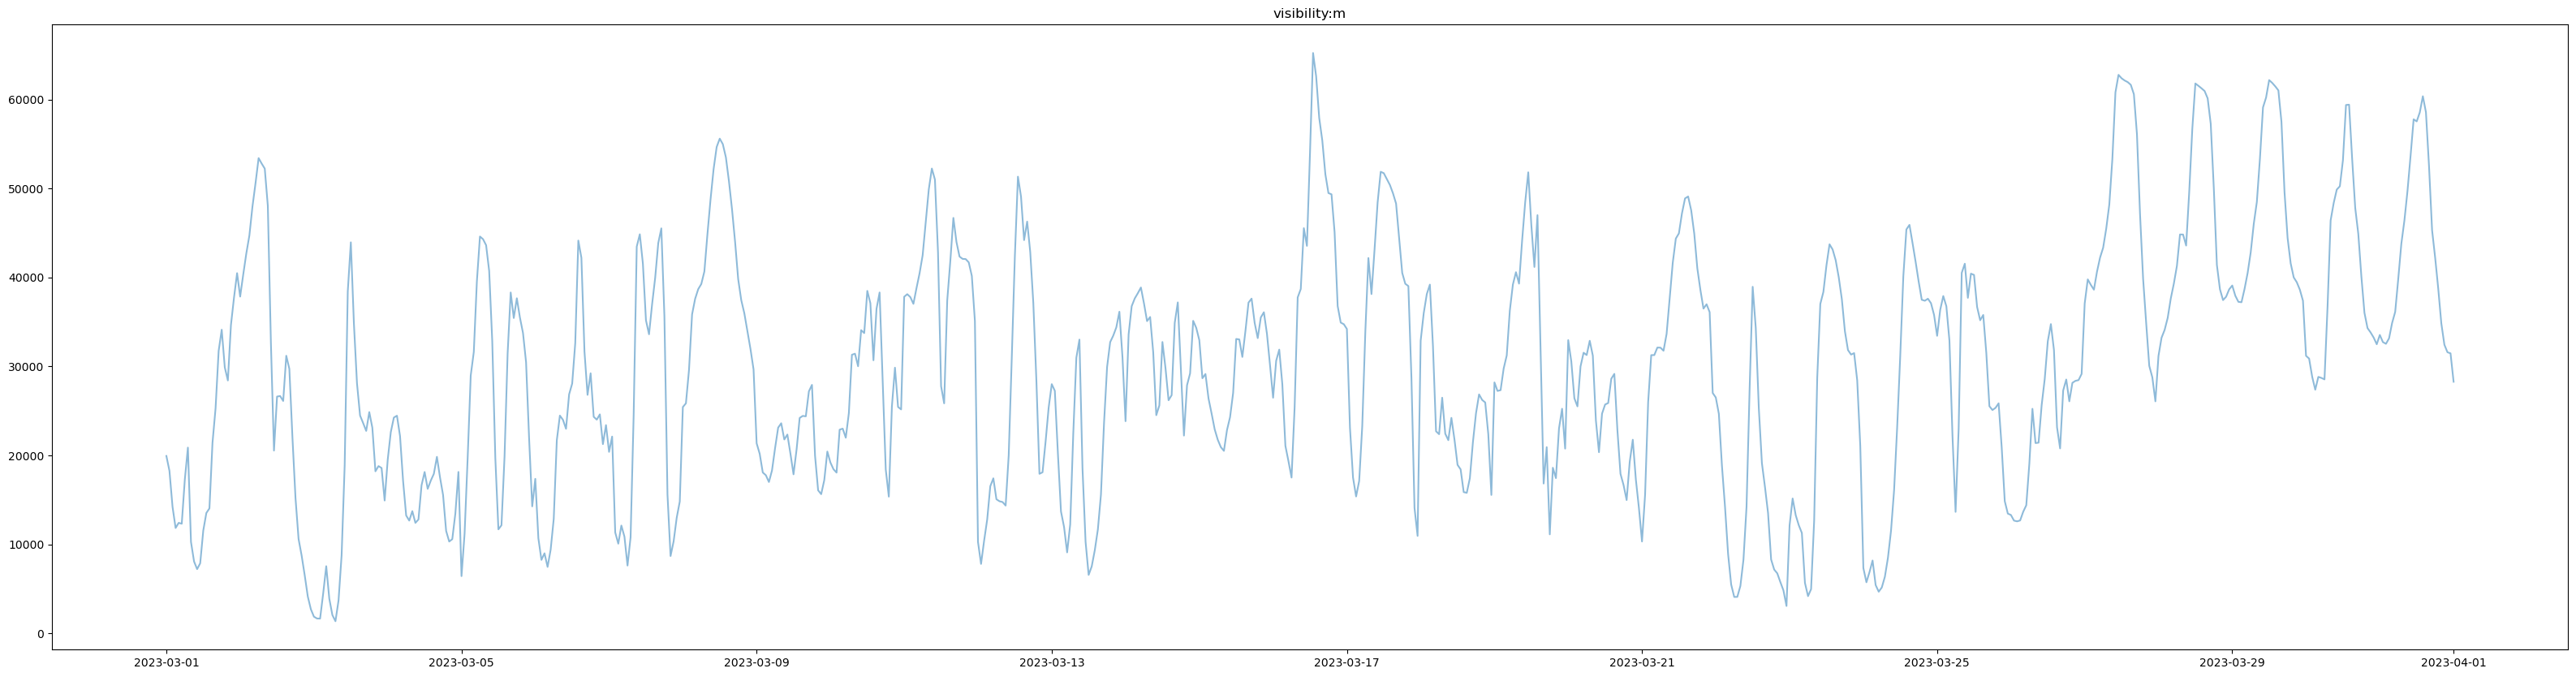

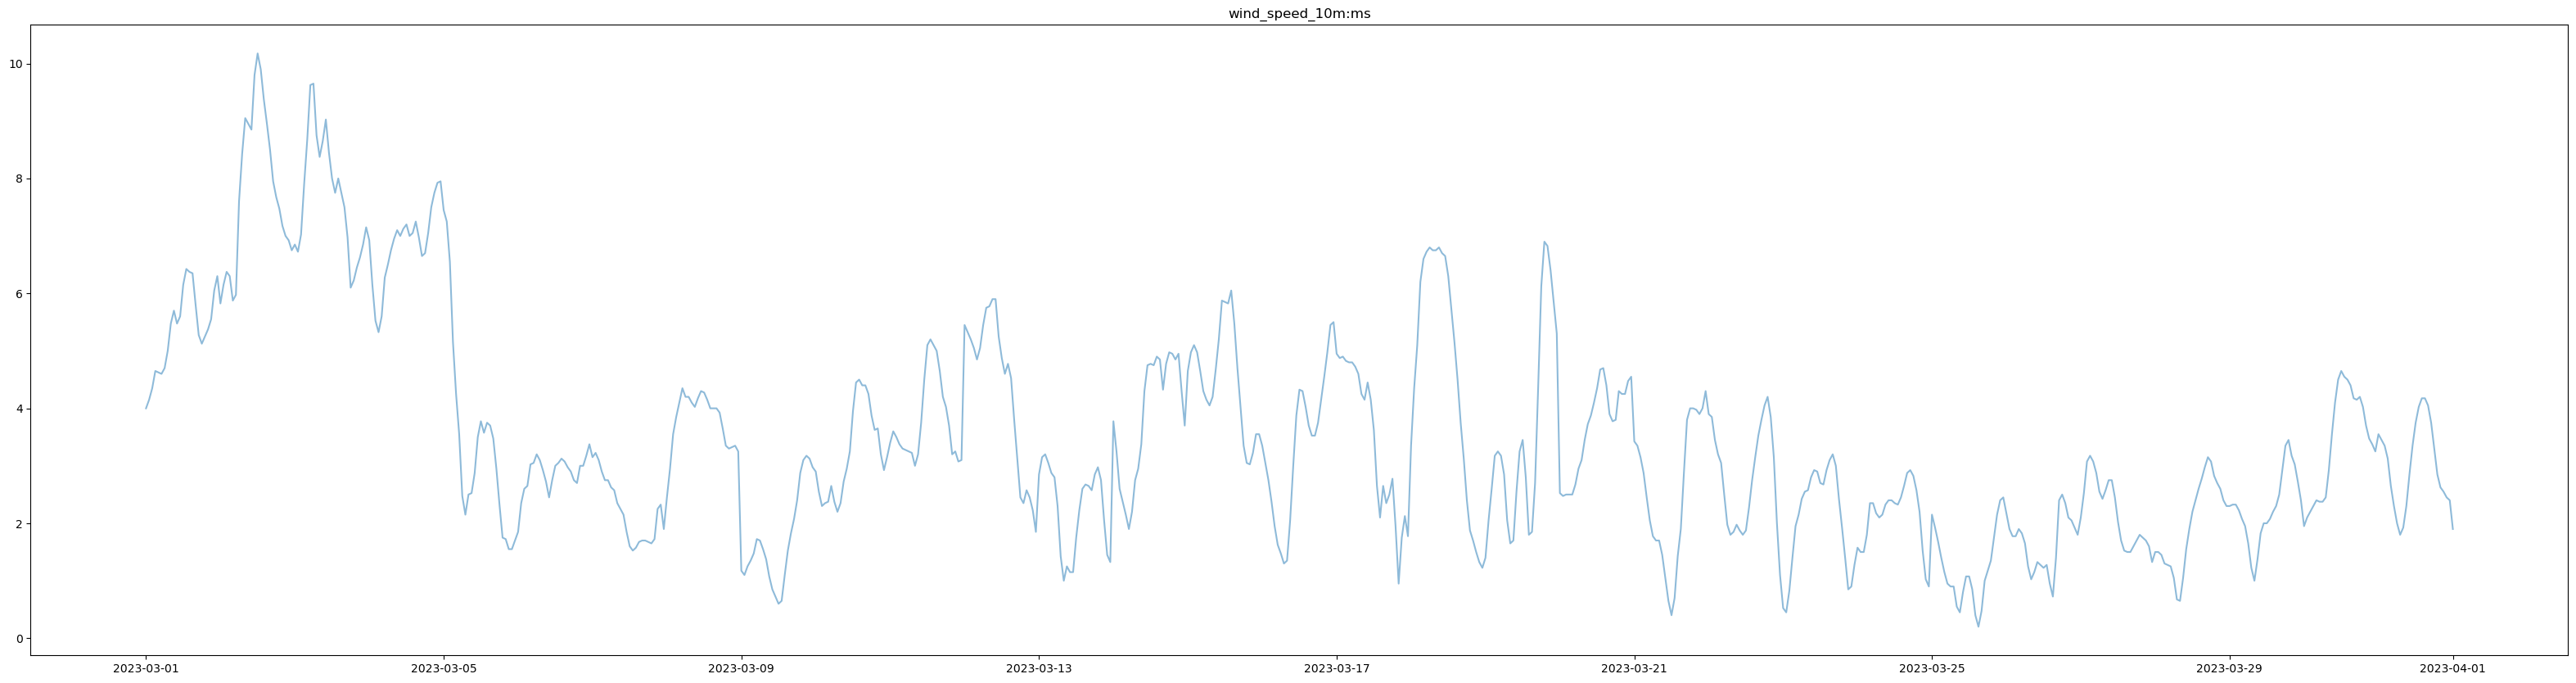

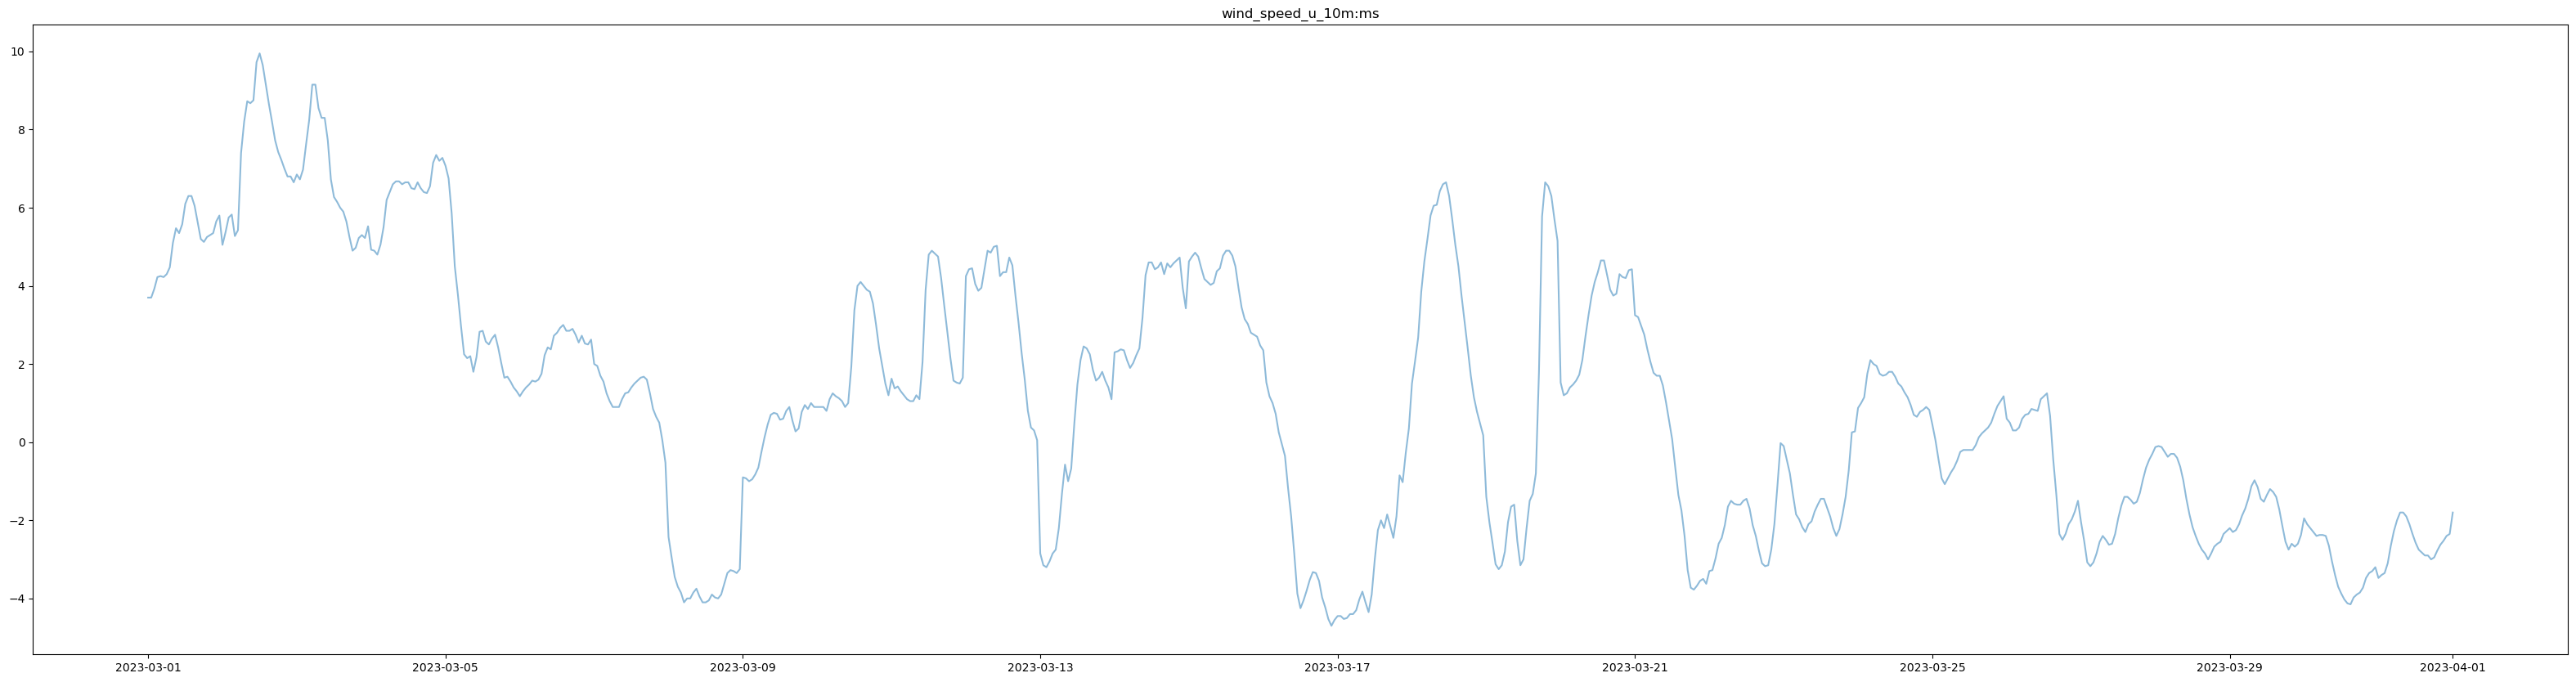

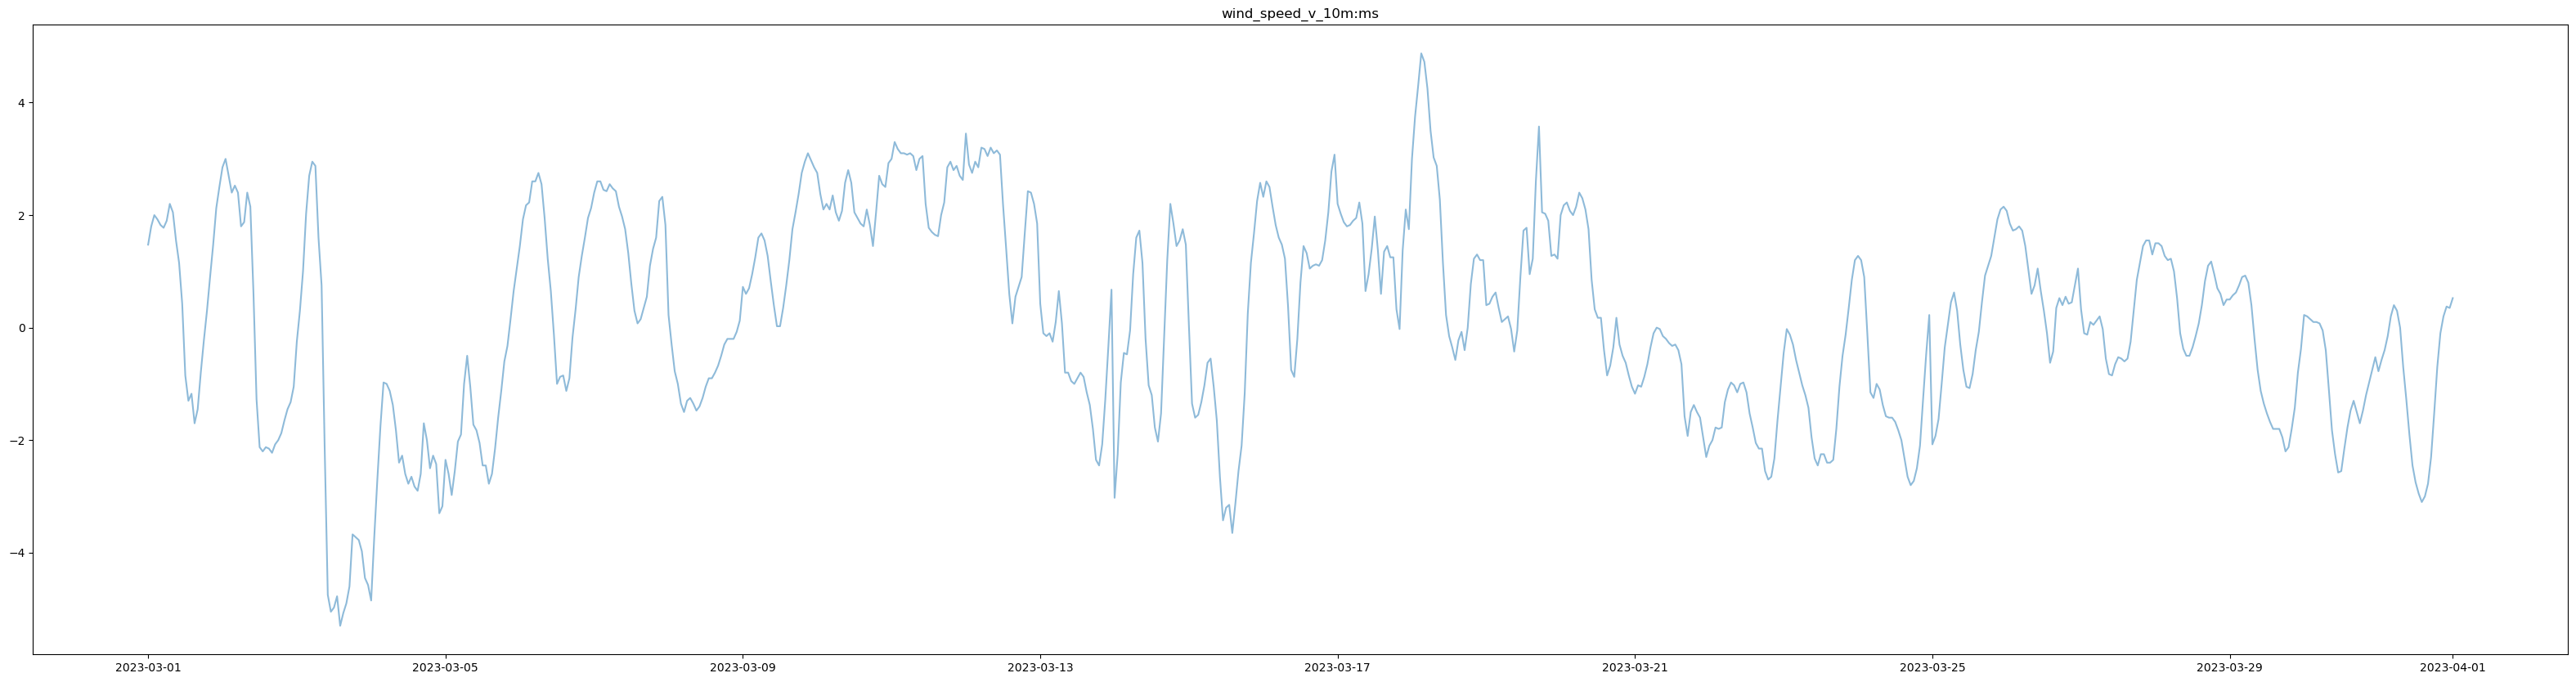

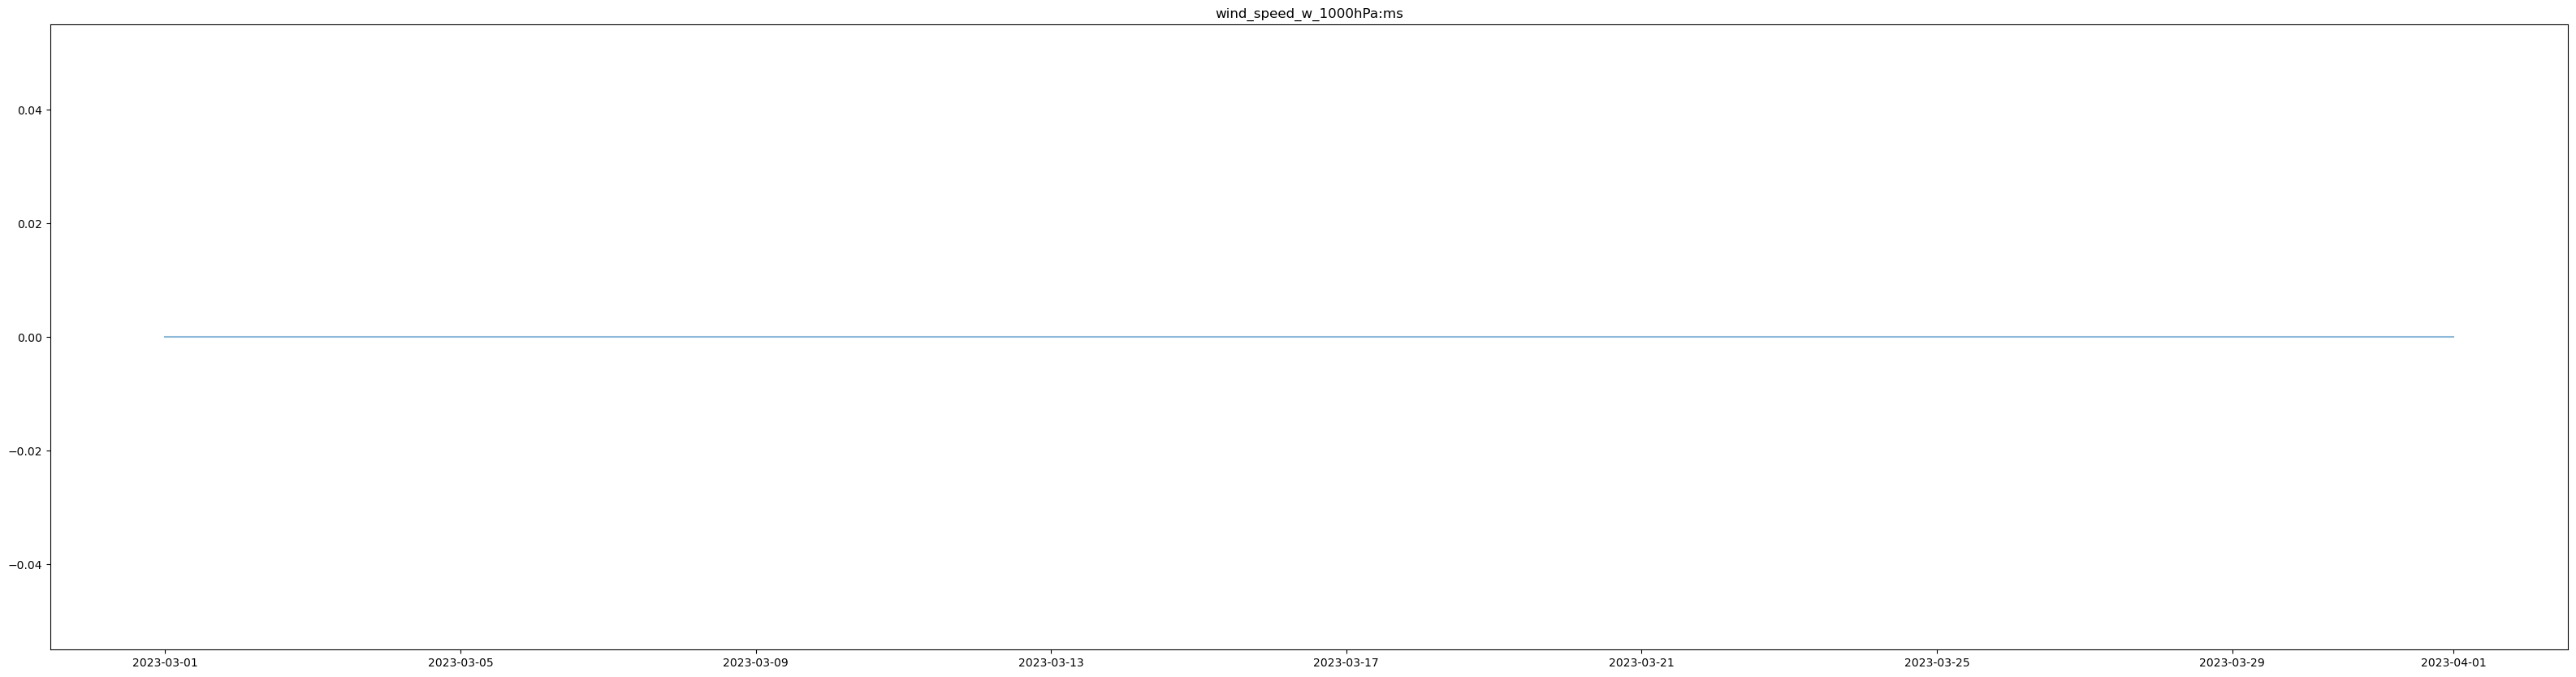

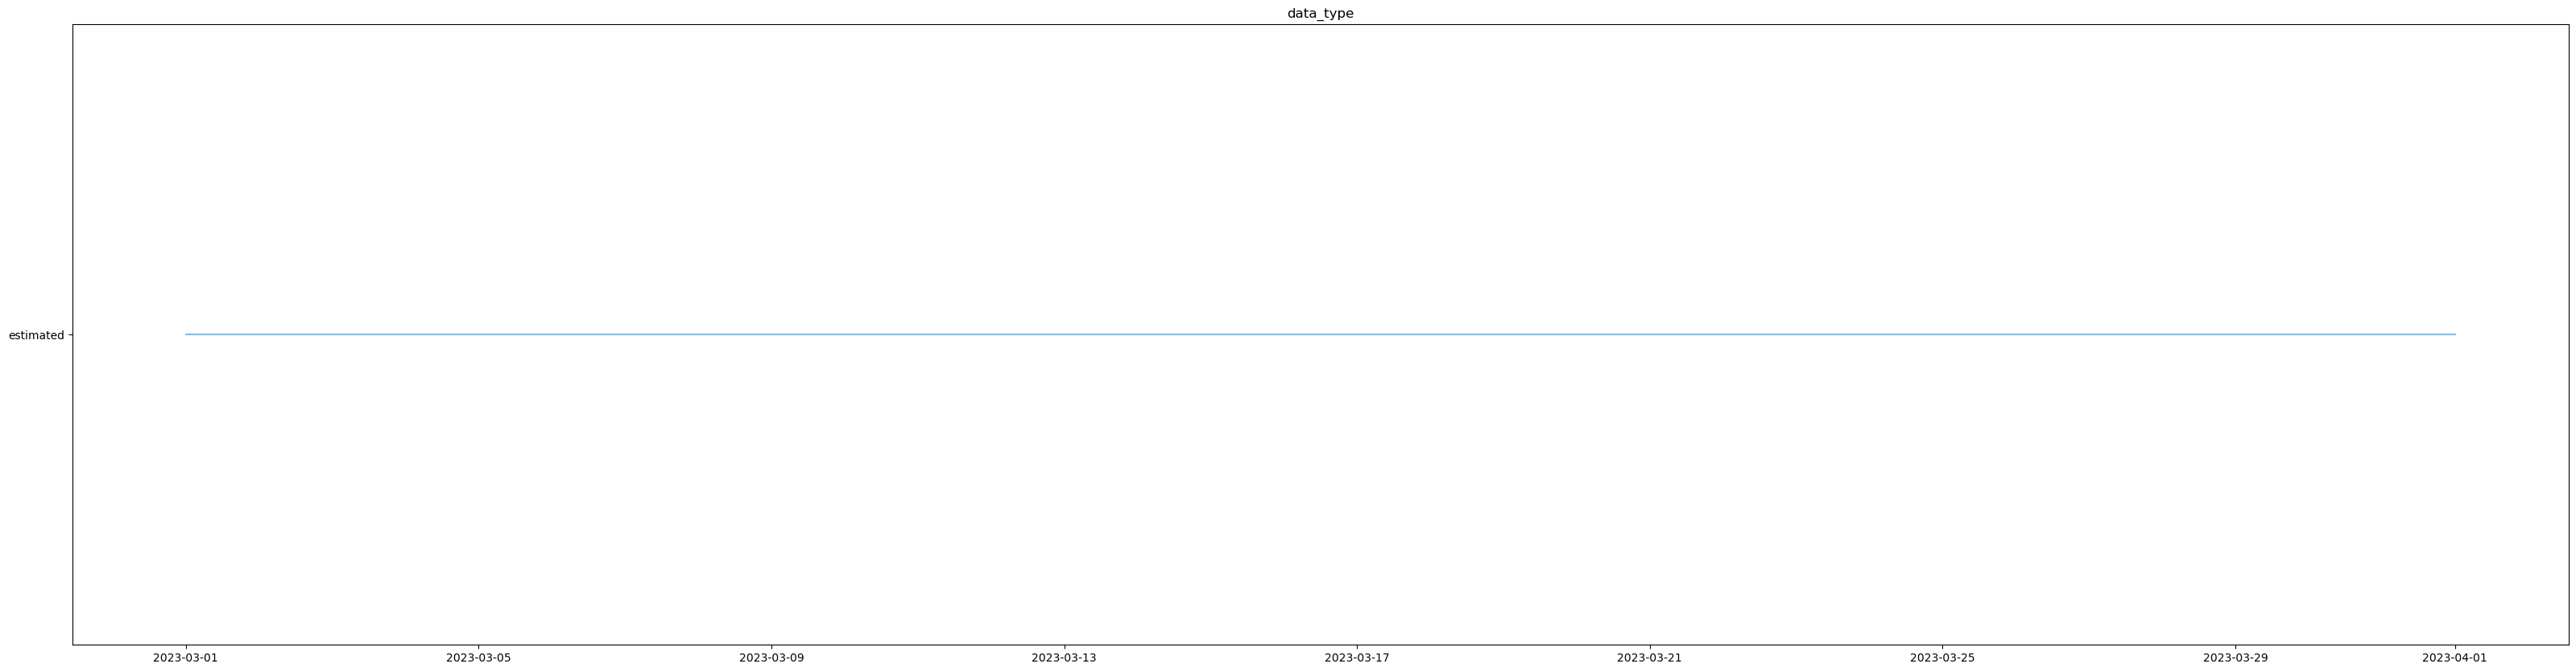

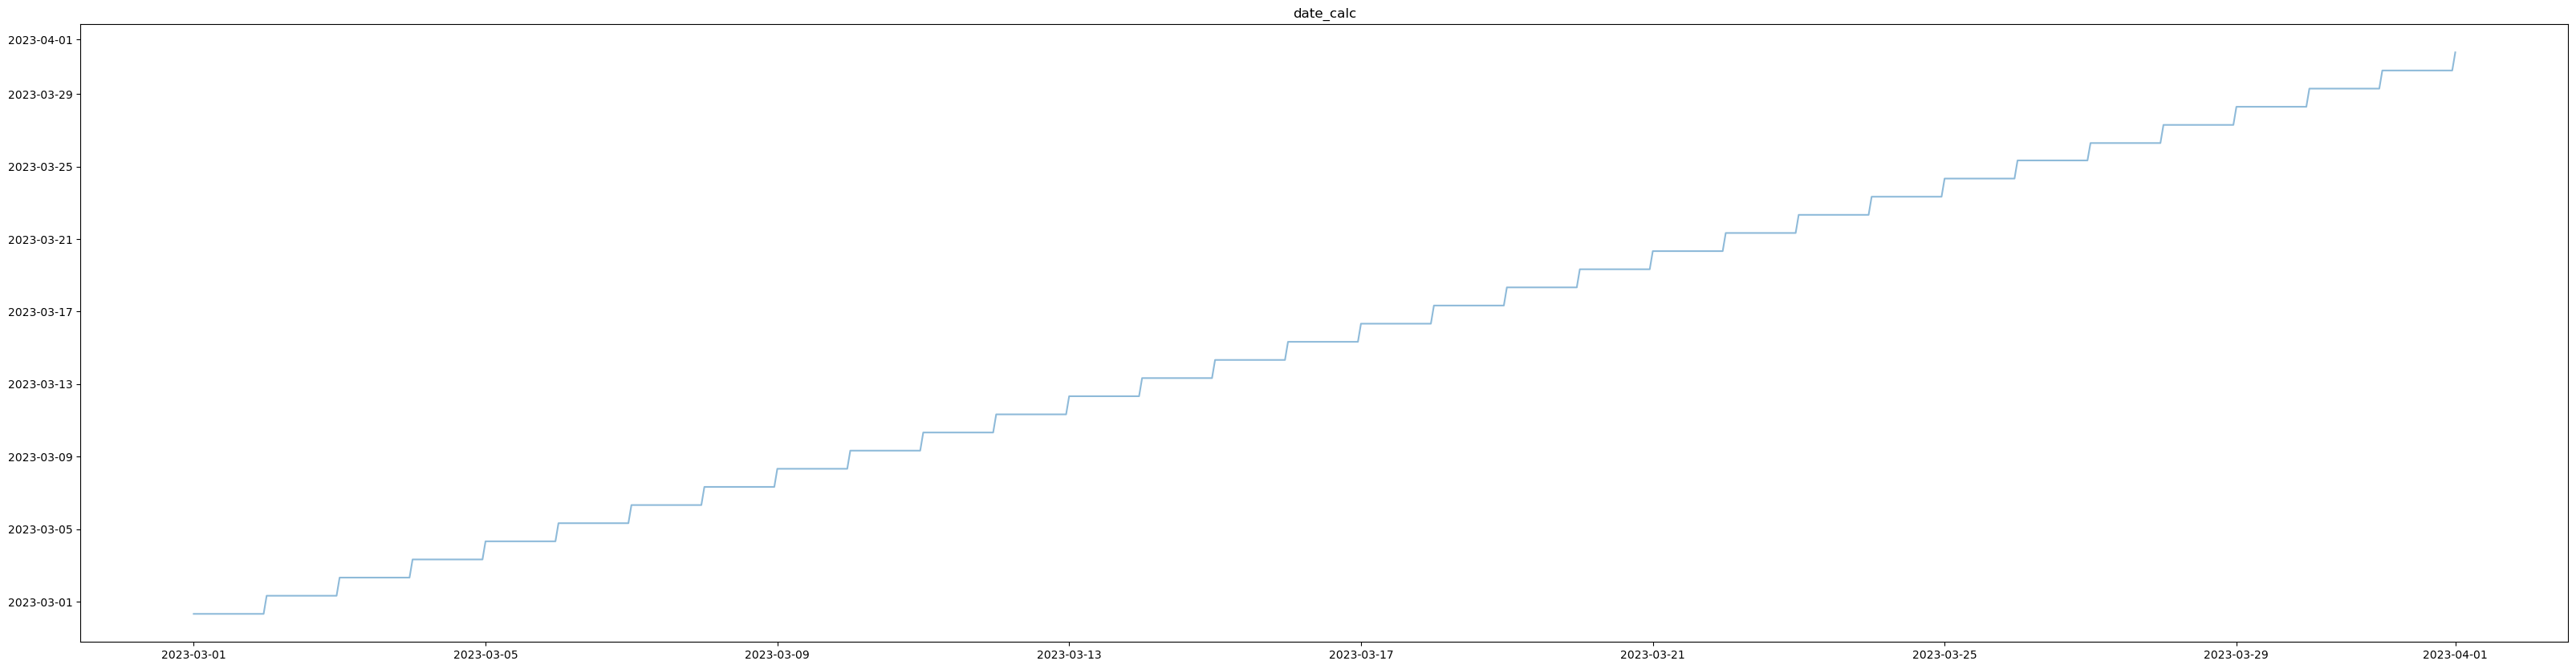

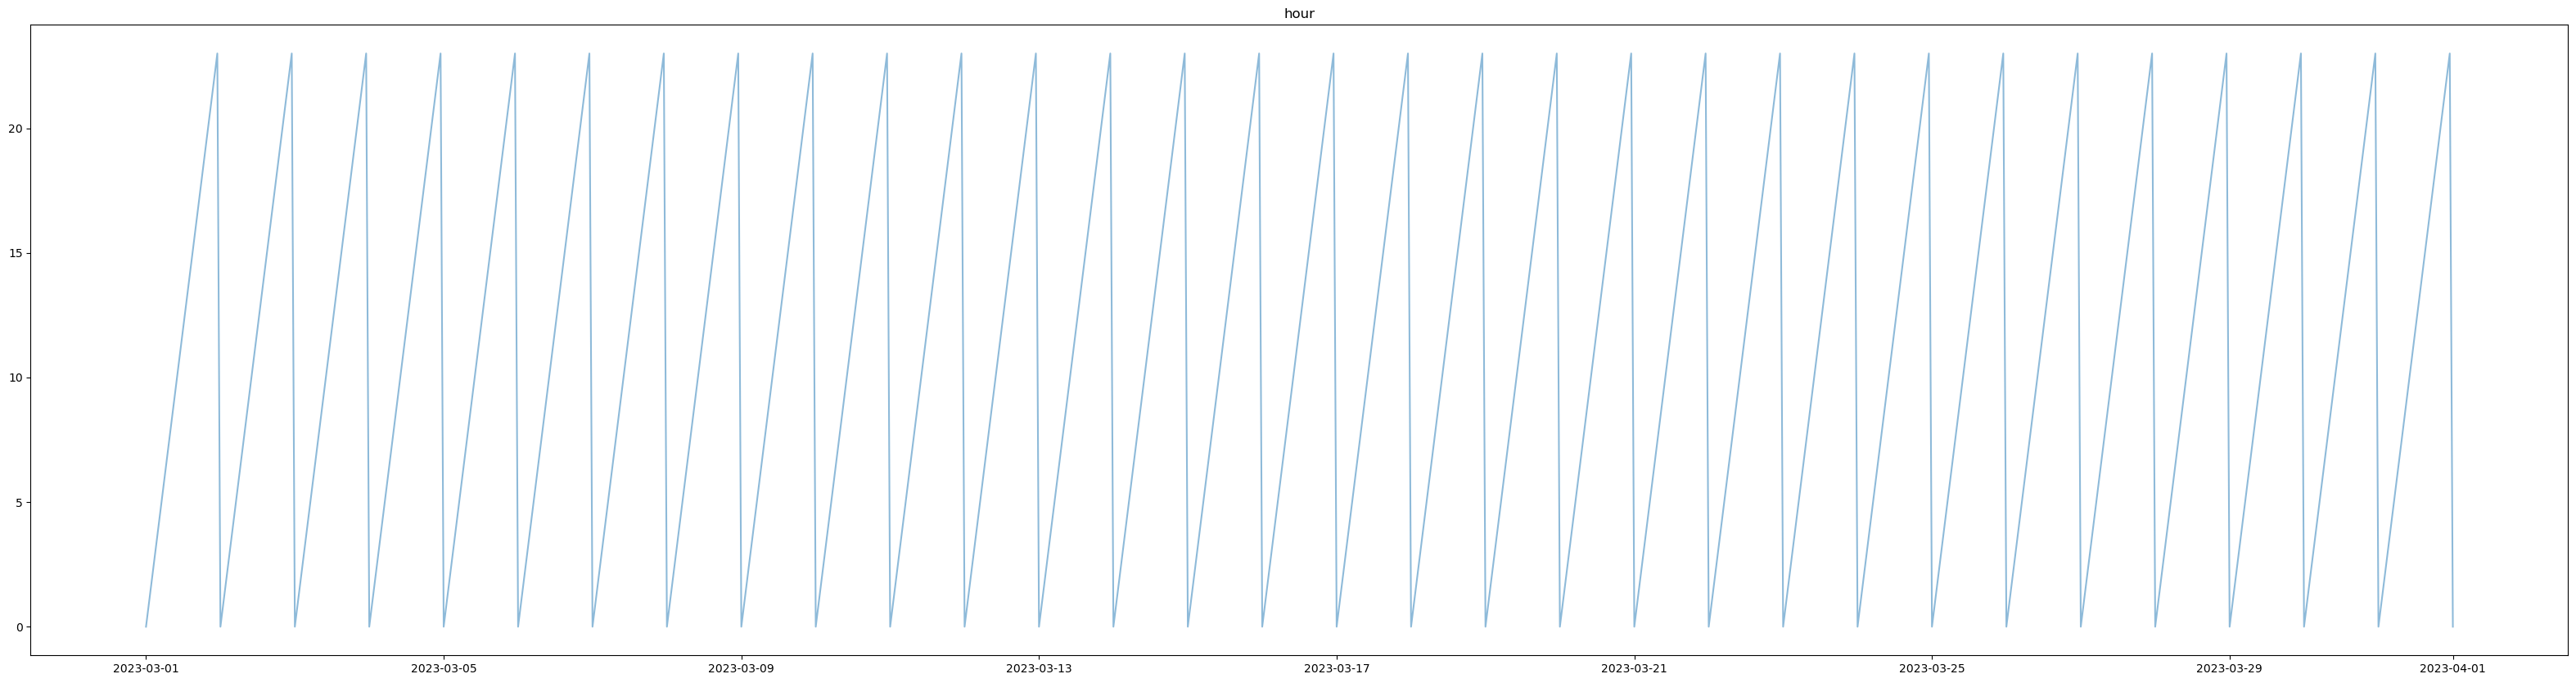

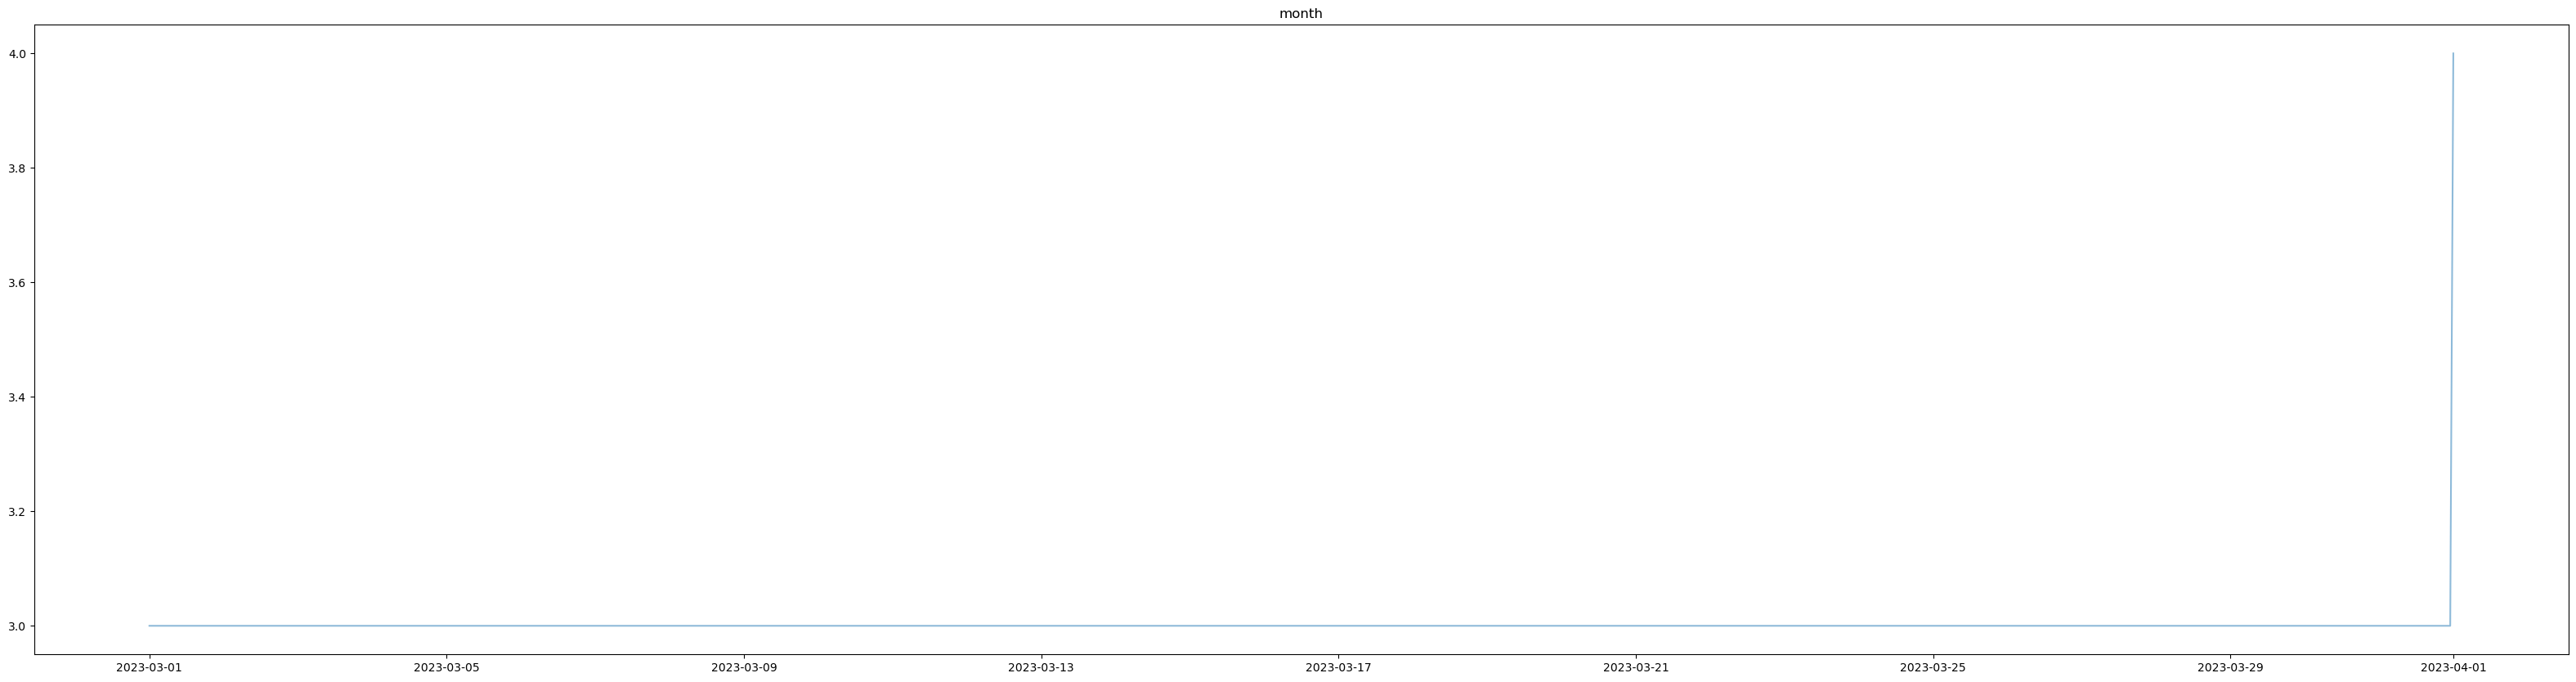

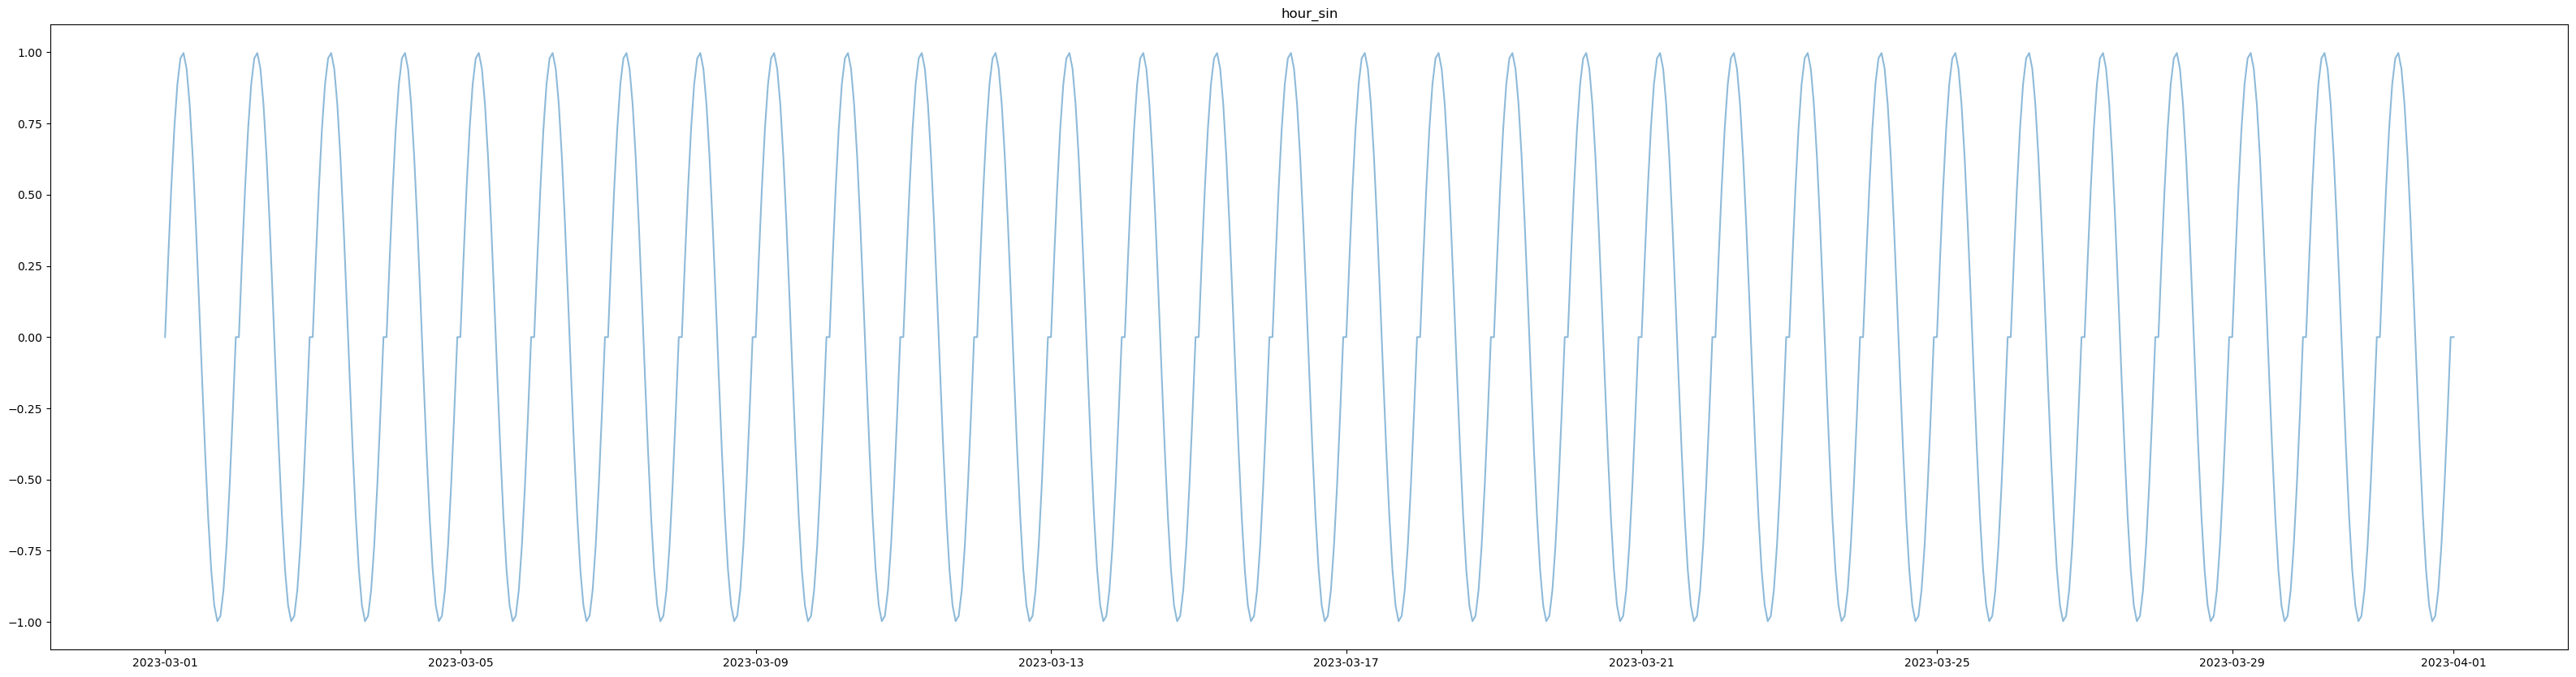

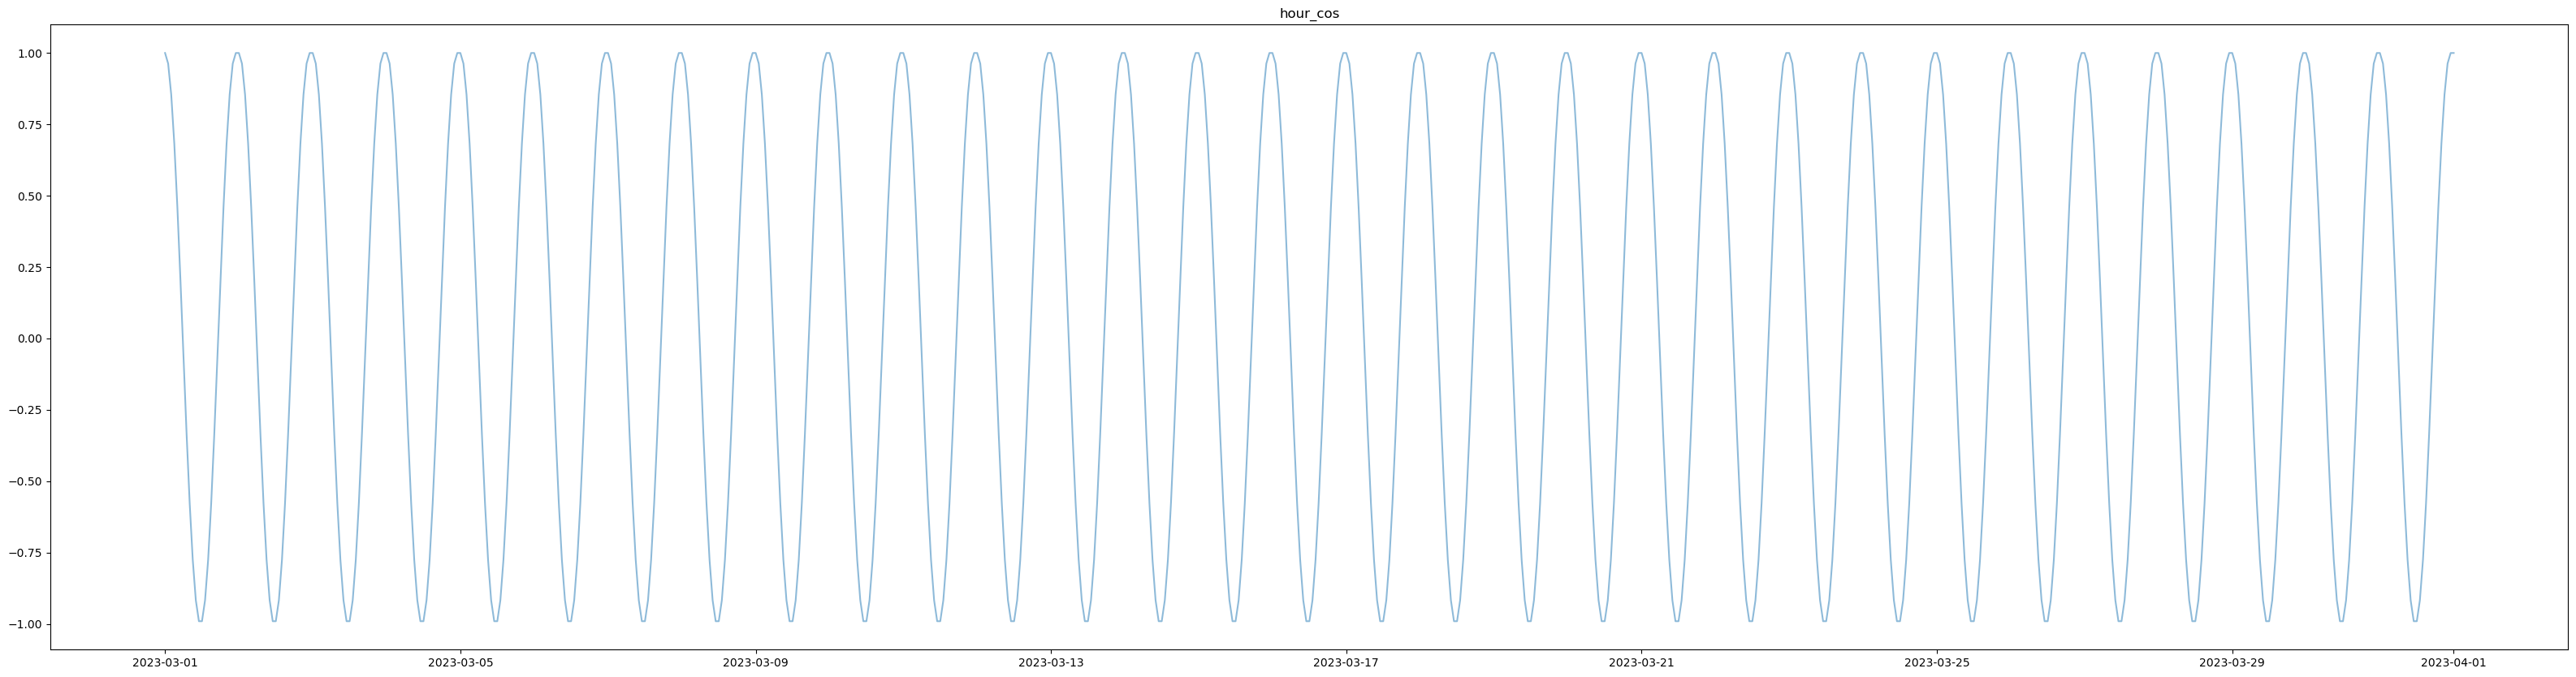

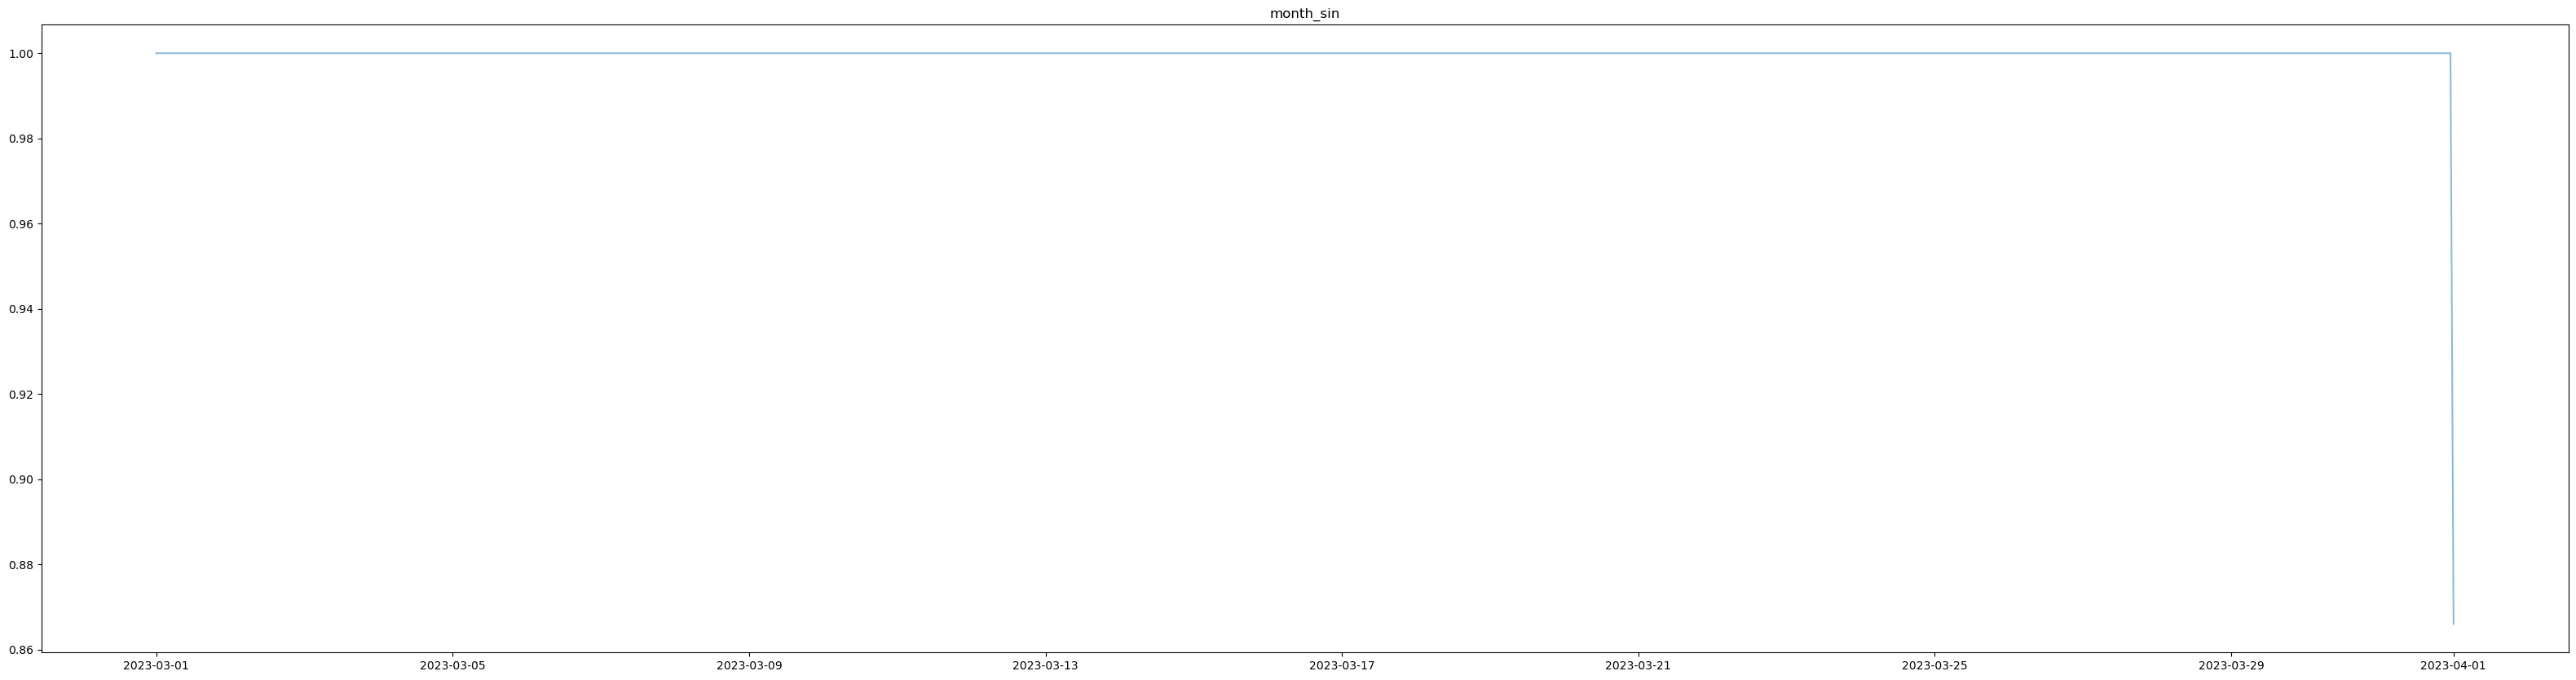

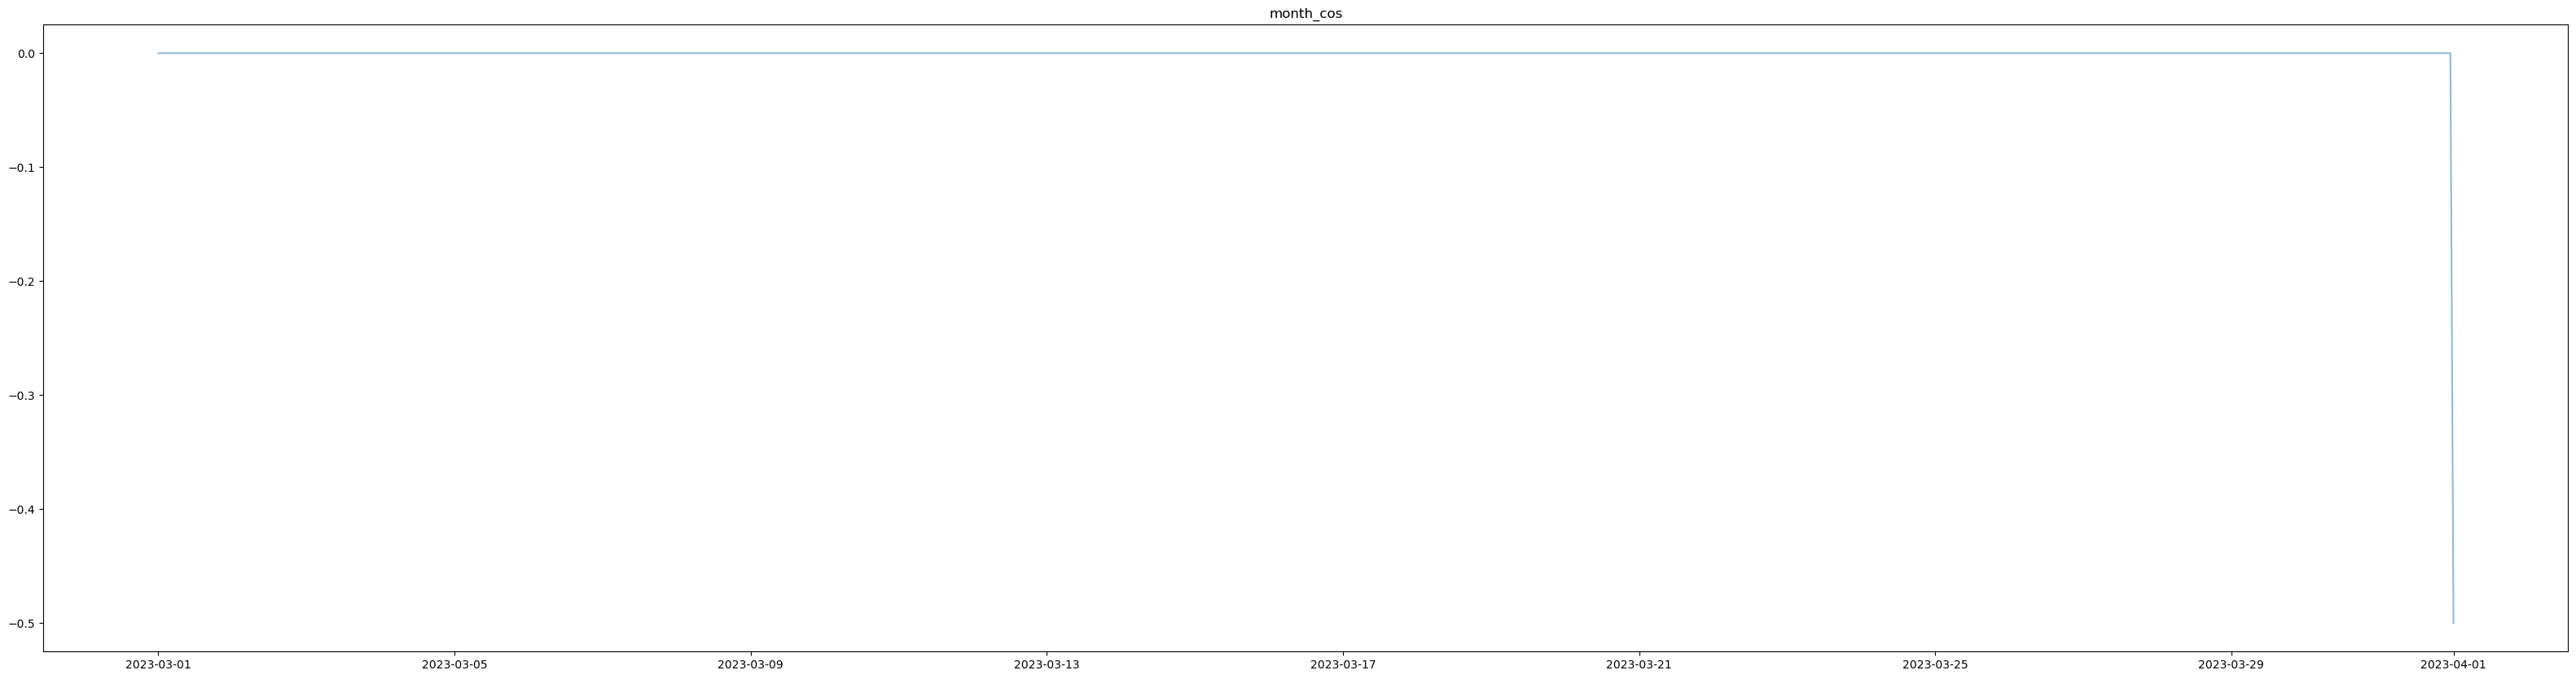

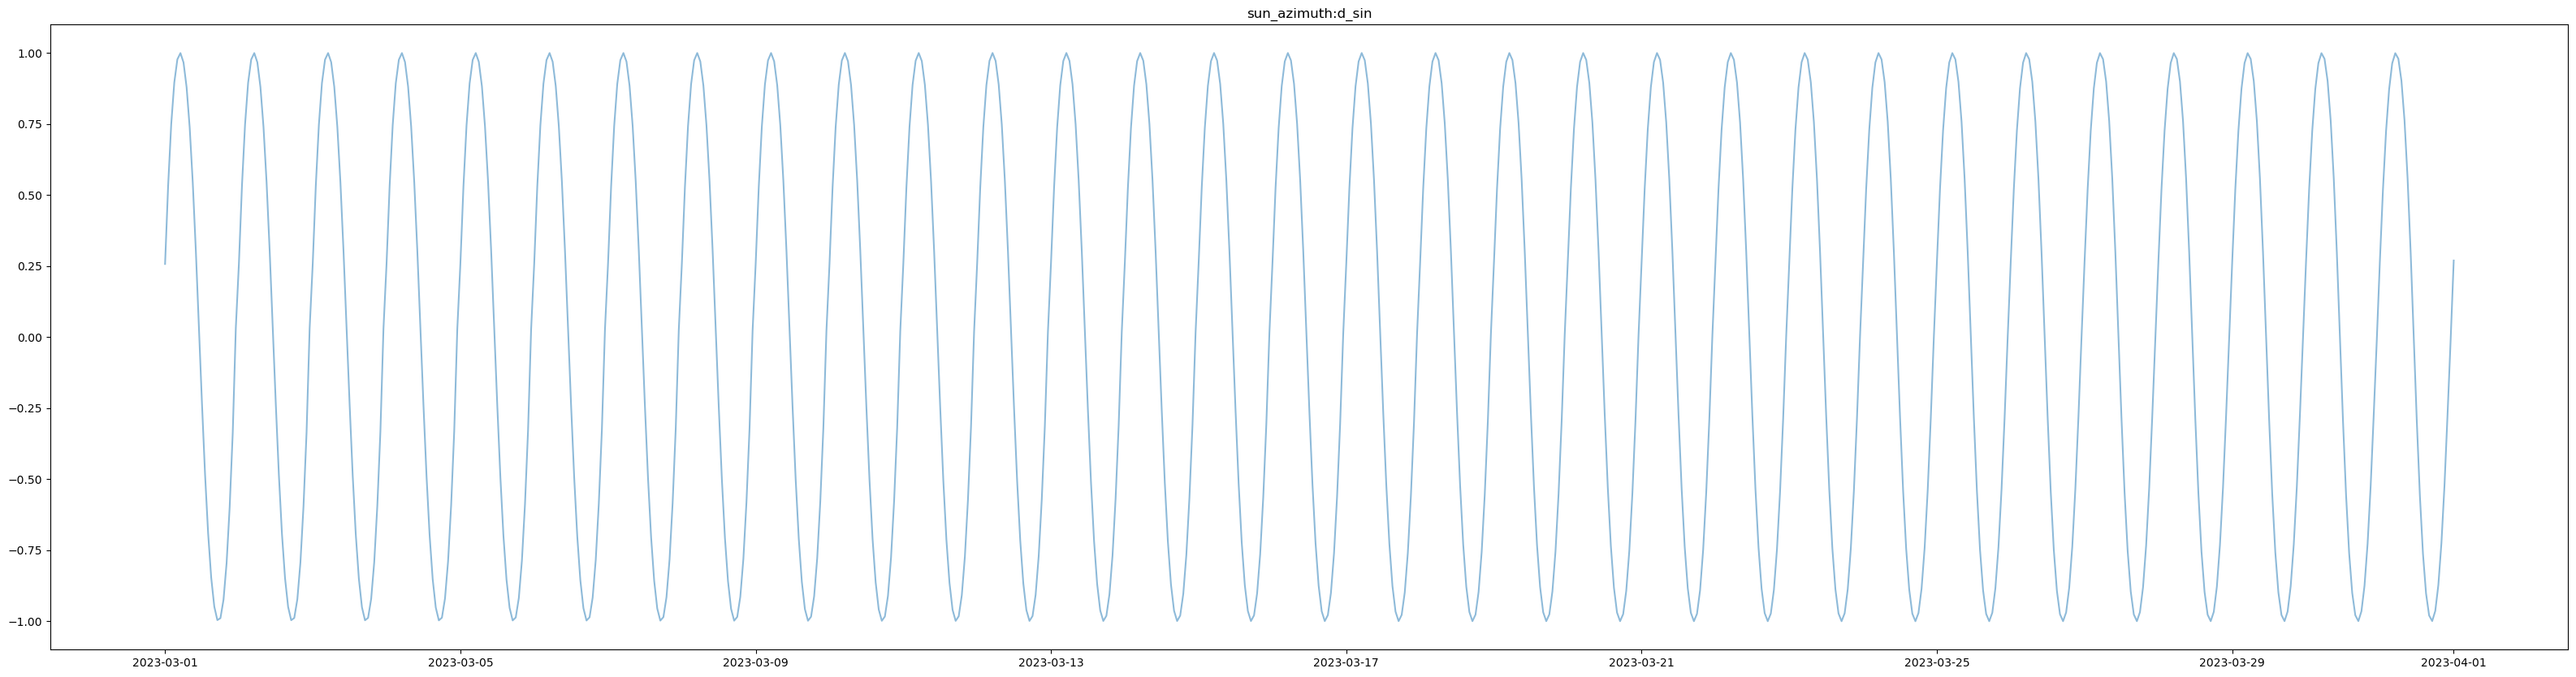

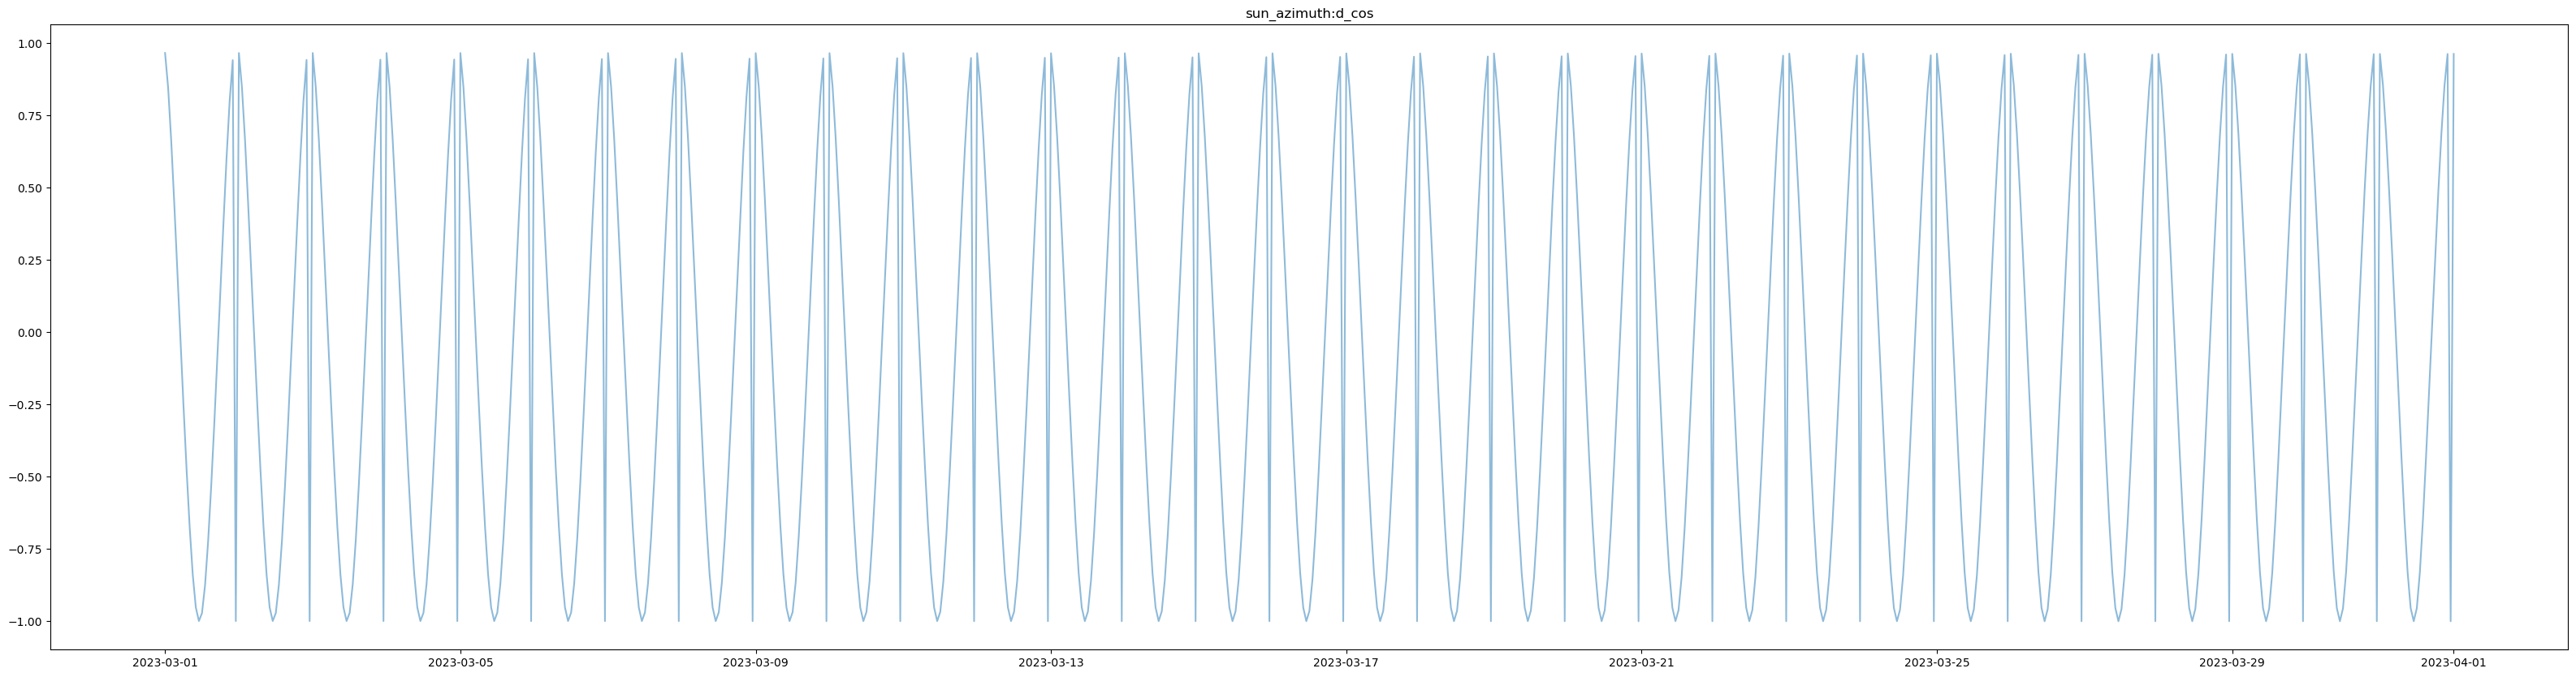

In [9]:
plot_data = plot_data[
    (plot_data["date_forecast"] >= "2023-03-01")
    & (plot_data["date_forecast"] <= "2023-04-01")
]

for column in plot_data.columns:
    if column not in ["date_forecast", "pv_measurement"]:
        plt.figure(figsize=(40, 10))
        # for location in plot_data["location"].unique():
        #     plt.plot(
        #         plot_data[plot_data["location"] == location]["date_forecast"],
        #         plot_data[plot_data["location"] == location][column],
        #         alpha=0.5,
        #     )
        plt.plot(
            plot_data[plot_data["location"] == location]["date_forecast"],
            plot_data[plot_data["location"] == location][column],
            alpha=0.5,
        )
        plt.title(column)
        plt.show()